### ``The Equity Impact on Employee Attrition``

``Created by: Mijail Q. Mariano``

``18AUGUST2022``

----

In [1]:
# notebook dependencies
%matplotlib inline
import matplotlib as mlp
mlp.rcParams['figure.dpi'] = 300

# diasbling warning messages
import warnings
warnings.filterwarnings("ignore")

# importing key libraries
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format

# numpy import
import numpy as np
import random

# importing acquire module
import acquire
import prepare

# importing data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

# file cleaning modules
from skimpy import clean_columns

# stats/math modules
import scipy.stats as stats

# sklearn data science library
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.inspection import permutation_importance

# modules used in modeling
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, RFE, RFECV, f_regression, chi2

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer

# reporting
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.svm import SVC

### **<u>``Project Description``</u>**

I attempt to understand how socioeconomic data at the state county level can impact company-employee attrition.

I use socioeconomic data from Harvard University's "Opportunity Atlas" platform which tracks anonymized metrics of social-mobility of children born in the years from 1978 - 1983 through adulthood at the local level.

I combine these metrics of social-mobility with an employee dataset of a medium-sized business originally created by IBM's AI "Watson" to help investigate potential drivers of employee attrition.


**<u>Exploration Questions:</u>**

1. How much does an employee's geographical background such as where they live or grow up impact their decision to remain or leave their company?

2. Whare are the socioeconomic-employee demographic differences between those employees who leave the company and those who remain?

3. How can organizations think about employee attrition in the context of local-counties social-mobility?

-----

**<u>``Project Assumptions``</u>**

I make several assumptions throughout the analysis. Here are some of the key underlying assumptions that should be considered when interpreting its findings.

**``Employee Attrition``**

Employee attrition can typically be categorized into two (2) broad-ranging measures, which are "voluntary" and "involuntary" attrition. Though not recorded in the IBM dataset, I ultimately made the decision to classify "attrition" in the data as voluntary resignation. This means that any employee recorded as having left the company made this decision without any influence of the business.

**``Geographical Assignment``**

I make the assumption that the employee data is from a mid-sized business in the United States, specifically the New York City, NY area. I also assume that its employees live or are from counties within a 30 mile commute radius of this business. 

Due to random county assignment for all employees, the analysis does not determine the directionality of socioeconomic impact on attrition. This is due to the uncertainty around employees' exact home-of-record locations and how other variables such as an employee's age, company tenure, and ultimately their decision to remain or leave the company are directly impacted by their county's social-mobility metrics.

-----

### **``Data Acquisition & Preparation``**

``Highlights:``

1470 Unique Records & 46 Unique Features

In [2]:
# acquiring dataset for analysis

df = acquire.get_employee_df()
df.head()

initial df shape: (1470, 46)


Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  state       cty  household_income_at_35  high-school_graduation_rate  \
0  ...     NY  cty36047                   37229                        0.838   
1  ...     NY  cty36005                   32542                        0.778   
2  ...     NY  cty36047                   37229                        0.838   
3  ...     NY  cty36047                   37229                        0.838   
4  ...     NY  cty36061                   37826                        0.813   

   percentage_married_by_35 incarceration_rate  women_teenage_birthrate  \
0                     0.320              0.014                    0.196   
1                     0.222              0.016                    0.277   
2                     0.320              0.014                    0.196   
3                     0.320              0.014                    0.196   
4                     0.290              0.011                    0.192   

  poverty_rate  employment_rates_at_35yrs  single_parent_frac  
0        0.229                      0.732               0.381  
1        0.305                      0.742               0.591  
2        0.229                      0.732               0.381  
3        0.229                      0.732               0.381  
4        0.174                      0.728               0.345  

[5 rows x 46 columns]

In [3]:
# initial df cleaning

df = prepare.clean_employee_df(df)
df.head() # 12 features/columns removed

shape after cleaning: (1470, 34)


attrition  employee_age  monthly_income  percent_salary_hike  \
1       True            41            5993                   11   
2      False            49            5130                   23   
4       True            37            2090                   15   
5      False            33            2909                   11   
7      False            27            3468                   12   

   total_working_years  training_times_last_year  years_at_company  \
1                    8                         0                 6   
2                   10                         3                10   
4                    7                         3                 0   
5                    8                         3                 8   
7                    6                         3                 2   

   household_income_at_35  high_school_graduation_rate  \
1                   37229                        0.838   
2                   32542                        0.778   
4                   37229                        0.838   
5                   37229                        0.838   
7                   37826                        0.813   

   percentage_married_by_35  ...               job_role  job_satisfaction  \
1                     0.320  ...        Sales Executive                 4   
2                     0.222  ...     Research Scientist                 2   
4                     0.320  ...  Laboratory Technician                 3   
5                     0.320  ...     Research Scientist                 3   
7                     0.290  ...  Laboratory Technician                 2   

   marital_status  performance_rating  relationship_satisfaction  state  \
1          Single                   3                          1     NY   
2         Married                   4                          4     NY   
4          Single                   3                          2     NY   
5         Married                   3                          3     NY   
7         Married                   3                          4     NY   

  stock_option_level work_life_balance years_in_current_role  \
1                  0                 1                     4   
2                  1                 3                     7   
4                  0                 3                     0   
5                  0                 3                     7   
7                  1                 3                     2   

  years_with_curr_manager  
1                       5  
2                       7  
4                       0  
5                       0  
7                       2  

[5 rows x 34 columns]

In [4]:
# returning summary of lower/upperbounds outlier dataframe

prepare.get_lower_and_upper_bounds(df).sort_values(by="upper_outliers", ascending=False).reset_index(drop = True)

dataframe shape: (17, 7)


column column type       iqr  lower_bound  \
0      training_times_last_year       int64     1.000        0.500   
1            single_parent_frac     float64     0.084        0.171   
2                monthly_income       int64  5468.000    -5291.000   
3    years_since_last_promotion       int64     3.000       -4.500   
4              years_at_company       int64     6.000       -6.000   
5           total_working_years       int64     9.000       -7.500   
6         years_in_current_role       int64     5.000       -5.500   
7       years_with_curr_manager       int64     5.000       -5.500   
8                  poverty_rate     float64     0.097       -0.013   
9     employment_rates_at_35yrs     float64     0.053        0.652   
10                 employee_age       int64    13.000       10.500   
11      women_teenage_birthrate     float64     0.074        0.010   
12           incarceration_rate     float64     0.006       -0.001   
13  high_school_graduation_rate     float64     0.101        0.661   
14       household_income_at_35       int64 14544.000    15413.000   
15          percent_salary_hike       int64     6.000        3.000   
16     percentage_married_by_35     float64     0.133        0.091   

    lower_outliers  upper_bound  upper_outliers  
0               54        4.500             184  
1                5        0.506             123  
2                0    16581.000             114  
3                0        7.500             107  
4                0       18.000             104  
5                0       28.500              63  
6                0       14.500              21  
7                0       14.500              14  
8                0        0.374               0  
9                0        0.864               0  
10               0       62.500               0  
11               0        0.307               0  
12               0        0.023               0  
13               0        1.066               0  
14               0    73589.000               0  
15               0       27.000               0  
16               0        0.622               0

In [5]:
# treating dataset for upperbound outliers w/1.5 fence

df = prepare.df_outliers(df)
df.head() # 240 records removed or ~16% of original df

shape after outliers: (1230, 34)


attrition  employee_age  monthly_income  percent_salary_hike  \
1       True            41            5993                   11   
2      False            49            5130                   23   
4       True            37            2090                   15   
5      False            33            2909                   11   
7      False            27            3468                   12   

   total_working_years  training_times_last_year  years_at_company  \
1                    8                         0                 6   
2                   10                         3                10   
4                    7                         3                 0   
5                    8                         3                 8   
7                    6                         3                 2   

   household_income_at_35  high_school_graduation_rate  \
1                   37229                        0.838   
2                   32542                        0.778   
4                   37229                        0.838   
5                   37229                        0.838   
7                   37826                        0.813   

   percentage_married_by_35  ...               job_role  job_satisfaction  \
1                     0.320  ...        Sales Executive                 4   
2                     0.222  ...     Research Scientist                 2   
4                     0.320  ...  Laboratory Technician                 3   
5                     0.320  ...     Research Scientist                 3   
7                     0.290  ...  Laboratory Technician                 2   

   marital_status  performance_rating  relationship_satisfaction  state  \
1          Single                   3                          1     NY   
2         Married                   4                          4     NY   
4          Single                   3                          2     NY   
5         Married                   3                          3     NY   
7         Married                   3                          4     NY   

  stock_option_level work_life_balance years_in_current_role  \
1                  0                 1                     4   
2                  1                 3                     7   
4                  0                 3                     0   
5                  0                 3                     7   
7                  1                 3                     2   

  years_with_curr_manager  
1                       5  
2                       7  
4                       0  
5                       0  
7                       2  

[5 rows x 34 columns]

#### **``Outlier Observations``**

**Since the socioeconomic/opportunity atlas data represents the only 'real' figures in the dataset, I intetionally choose to leave outliers in the dataset for testing and evaluating against attrition.**

<u>Ater applying an interquartile range with k value (fence) of 1.5, I will apply/ommit the following outlier cleaning:</u>

**monthly_income:** upperbound $16581.00

- this signals to me that these employees are either contractors or senior leaders at the company. If they are senior leaders, my assumption is that they are more reluctant to make an employment change due to their potential leadership responsibilities, role, and stated salary. 

**year_since_last_promotion:** upperbound 7.50 years

- this signals to me that these employees may already be seeking other opportunities elsewhere - potentially with an employer that is willing to offer them a better position with greater responsibilities, and salary. I will ommit employees over the dataset upperbound.

**years_at_company:** upperbound 18.00 years

- this signals to me that these employees may be reluctant to leave their current employer given the length of their tenure. Additionally, the current median employee tenure in the US is ~5 years, I will ommit employees over this upperbound.

**total_working_years:** upperbound 28.50 year

- similar to above, these employees may also be enroute to retirement or are simply less willing to make a career/employment shift given this late into their careers. Additionally, they might have also learned ways in which they can successfully navigate the socioeconomic challenges apparent in their communities. I will ommit employees over this upperbound.

**years_in_current_role:** upperbound 14.50 years

- given the median US employee/employer tenure, I assume that these employees 1. may already be seeking other opportunities or 2. are comfortable in their current roles and thefore are less willing to take socioeconomic factors as reason to leave their company. 

**years_with_curr_manager:** upperbound 14.50 years

- same as above, yet there could also be a relationship factor thats prevelant in the employees' tenure. Employees may have a good working relationship with their managers where they potentially feel "heard" and are having their socioeconomic concerns addressed. I will ommit employees over this upperbound.

----

``References:``

- https://www.bls.gov/news.release/tenure.nr0.htm


In [6]:
# examining the df and data types

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1230 entries, 1 to 2068
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   attrition                    1230 non-null   bool   
 1   employee_age                 1230 non-null   int64  
 2   monthly_income               1230 non-null   int64  
 3   percent_salary_hike          1230 non-null   int64  
 4   total_working_years          1230 non-null   int64  
 5   training_times_last_year     1230 non-null   int64  
 6   years_at_company             1230 non-null   int64  
 7   household_income_at_35       1230 non-null   int64  
 8   high_school_graduation_rate  1230 non-null   float64
 9   percentage_married_by_35     1230 non-null   float64
 10  incarceration_rate           1230 non-null   float64
 11  women_teenage_birthrate      1230 non-null   float64
 12  poverty_rate                 1230 non-null   float64
 13  employment_rates_a

In [7]:
# summary statistics

summary_stats = df.describe().T
summary_stats["range"] = summary_stats["max"] - summary_stats["min"]
summary_stats.sort_index()

count      mean      std       min       25%  \
employee_age                1230.000    35.278    8.520    18.000    29.000   
employment_rates_at_35yrs   1230.000     0.759    0.030     0.728     0.732   
high_school_graduation_rate 1230.000     0.859    0.049     0.778     0.813   
household_income_at_35      1230.000 43566.984 9001.588 32542.000 37229.000   
incarceration_rate          1230.000     0.011    0.004     0.003     0.008   
monthly_income              1230.000  5086.472 2933.368  1009.000  2742.250   
percent_salary_hike         1230.000    15.270    3.604    11.000    12.000   
percentage_married_by_35    1230.000     0.351    0.079     0.222     0.290   
poverty_rate                1230.000     0.175    0.063     0.046     0.132   
single_parent_frac          1230.000     0.353    0.094     0.164     0.297   
total_working_years         1230.000     8.884    5.202     0.000     5.000   
training_times_last_year    1230.000     2.812    1.304     0.000     2.000   
women_teenage_birthrate     1230.000     0.166    0.060     0.037     0.121   
years_at_company            1230.000     5.368    3.712     0.000     2.000   
years_in_current_role       1230.000     3.564    3.059     0.000     2.000   
years_since_last_promotion  1230.000     1.399    1.956     0.000     0.000   
years_with_curr_manager     1230.000     3.494    3.056     0.000     1.000   

                                  50%       75%       max     range  
employee_age                   34.000    40.000    60.000    42.000  
employment_rates_at_35yrs       0.742     0.785     0.815     0.087  
high_school_graduation_rate     0.838     0.914     0.944     0.166  
household_income_at_35      37826.000 51773.000 65975.000 33433.000  
incarceration_rate              0.011     0.014     0.018     0.015  
monthly_income               4412.000  6384.750 16422.000 15413.000  
percent_salary_hike            14.000    18.000    25.000    14.000  
percentage_married_by_35        0.320     0.423     0.543     0.321  
poverty_rate                    0.174     0.229     0.305     0.260  
single_parent_frac              0.345     0.381     0.591     0.428  
total_working_years             8.000    11.000    28.000    28.000  
training_times_last_year        3.000     3.000     6.000     6.000  
women_teenage_birthrate         0.192     0.196     0.277     0.239  
years_at_company                5.000     8.000    18.000    18.000  
years_in_current_role           2.000     7.000    14.000    14.000  
years_since_last_promotion      1.000     2.000     7.000     7.000  
years_with_curr_manager         2.000     7.000    13.000    13.000

In [8]:
# using a for loop to sample data by feature

prepare.data_samples(df)

Feature/column: attrition
Date type: bool
Missing values: False
Number of unique values: 2
Data Sample: [False, False, False, False, False, True, True]
-------------------------------------------------------------------
Feature/column: employee_age
Date type: int64
Missing values: False
Number of unique values: 43
Data Sample: [27, 32, 33, 37, 41, 49, 59]
-------------------------------------------------------------------
Feature/column: monthly_income
Date type: int64
Missing values: False
Number of unique values: 1120
Data Sample: [2090, 2670, 2909, 3068, 3468, 5130, 5993]
-------------------------------------------------------------------
Feature/column: percent_salary_hike
Date type: int64
Missing values: False
Number of unique values: 15
Data Sample: [11, 11, 12, 13, 15, 20, 23]
-------------------------------------------------------------------
Feature/column: total_working_years
Date type: int64
Missing values: False
Number of unique values: 29
Data Sample: [6, 7, 8, 8, 8, 10, 1

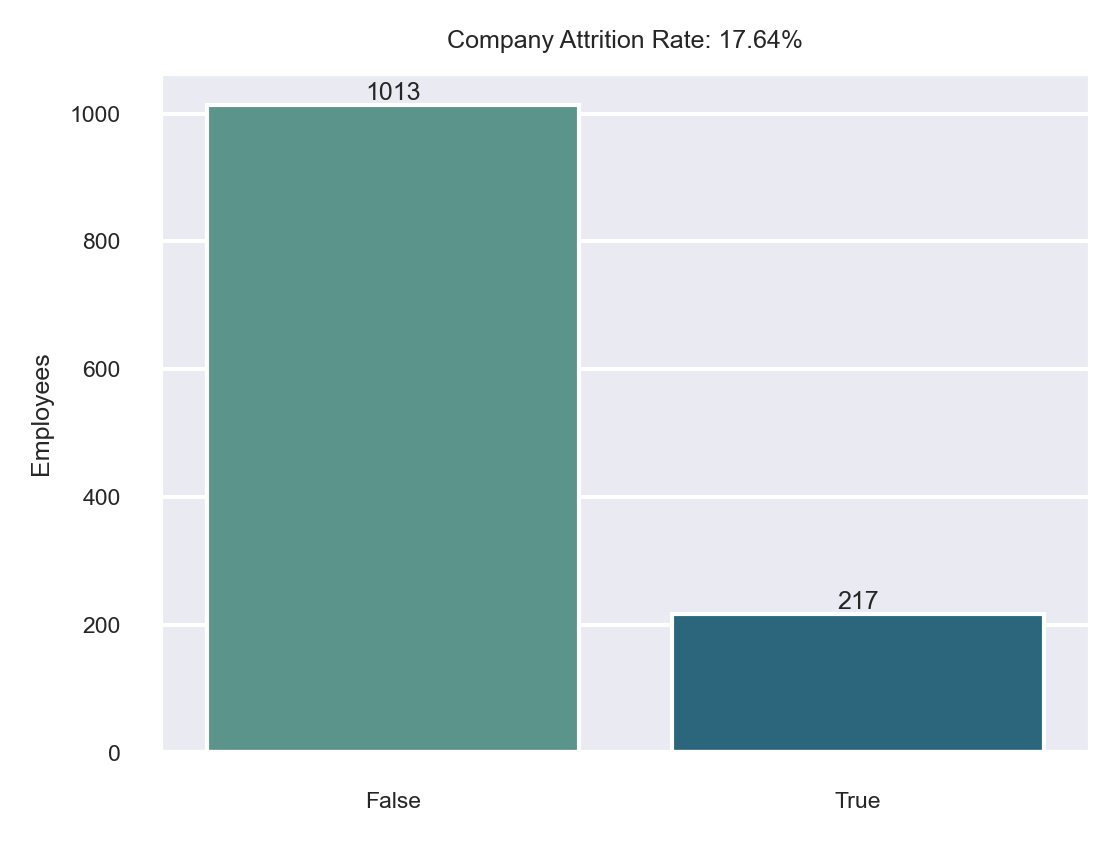

In [9]:
# let's examine the target variable after handling outliers

attrition_mean = df["attrition"].mean()

plt.figure(figsize = (4, 3))
sns.set(font_scale = 0.5)

ax = sns.countplot(
    x = "attrition",
    data = df,
    order = df["attrition"].value_counts().index,
    palette = "crest")

ax.bar_label(ax.containers[0])

plt.title(f'Company Attrition Rate: {attrition_mean:.2%}')
plt.xlabel(None)
plt.ylabel("Employees")

plt.show()

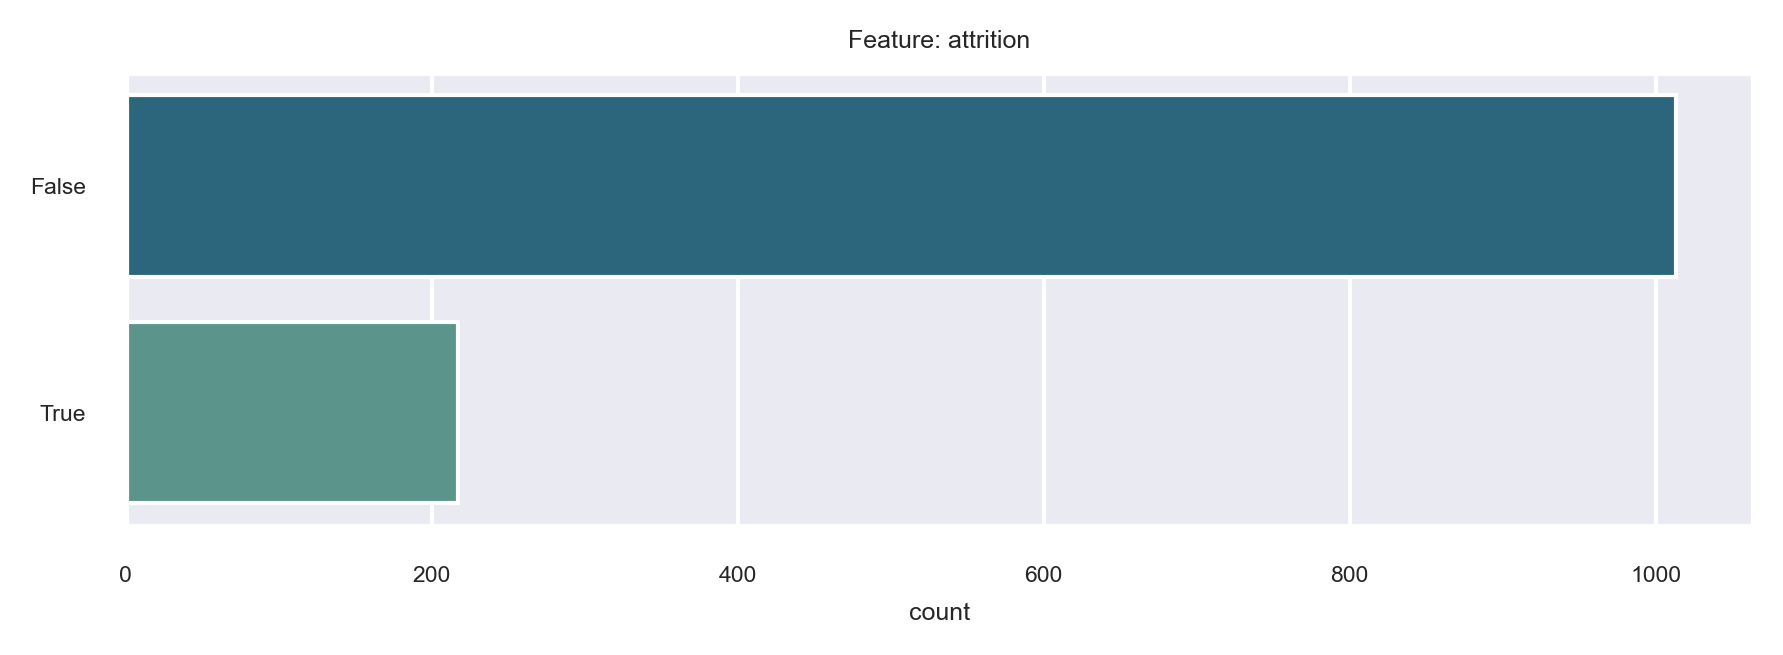

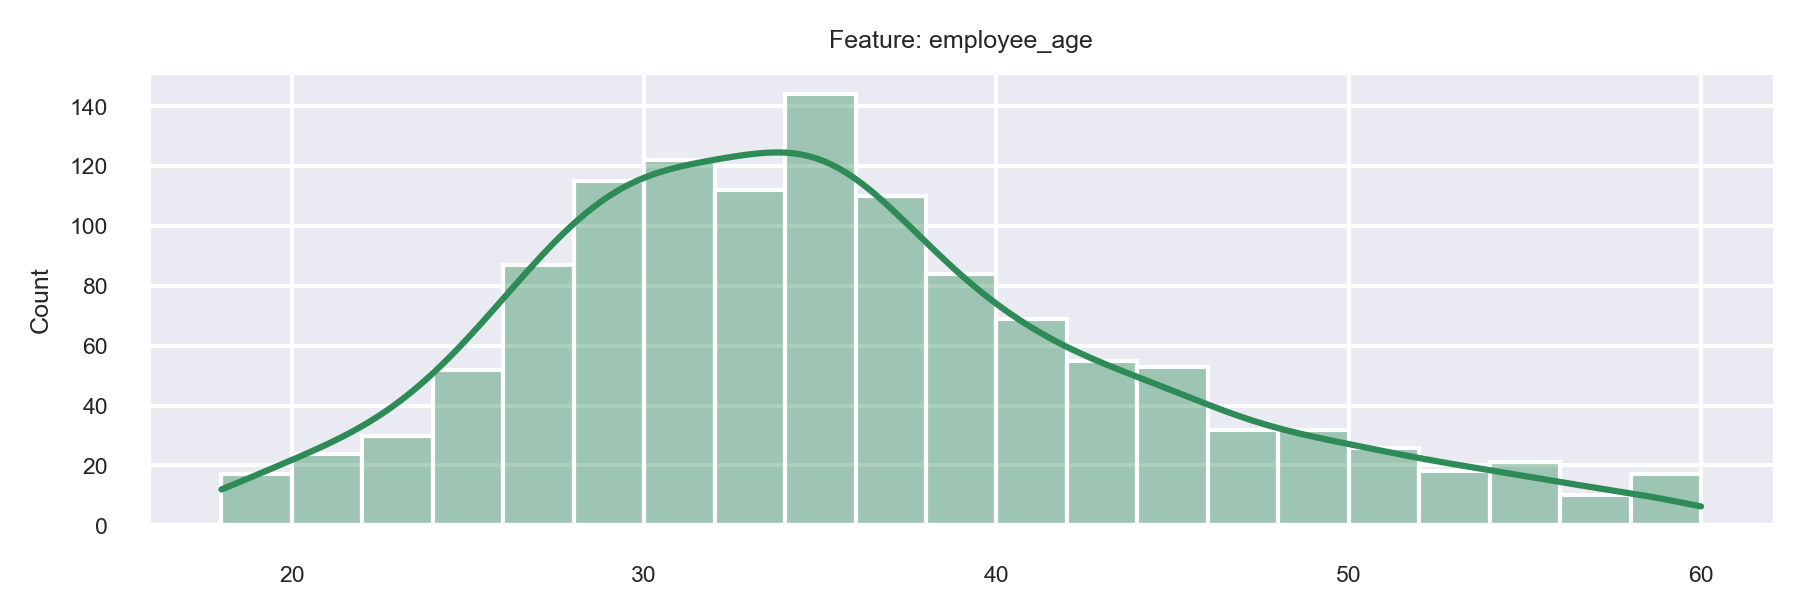

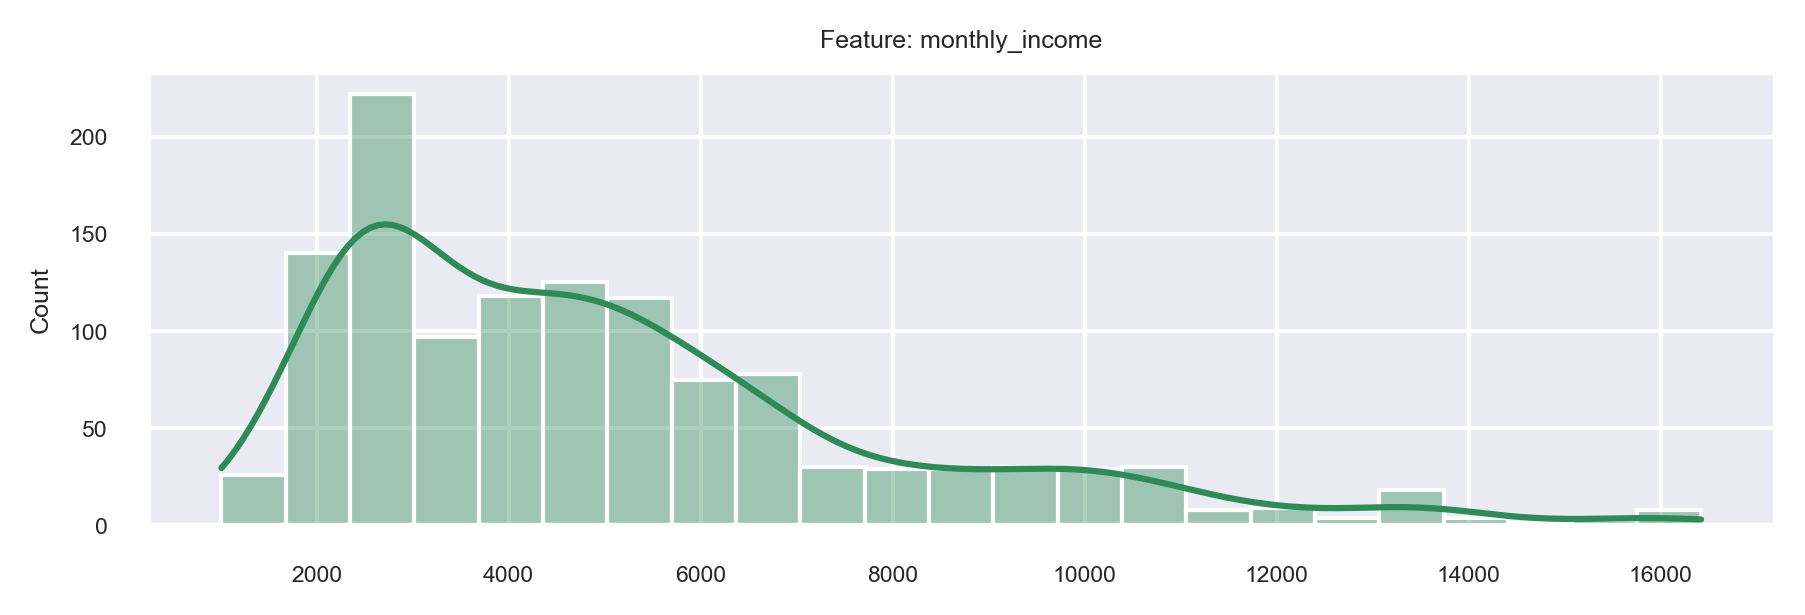

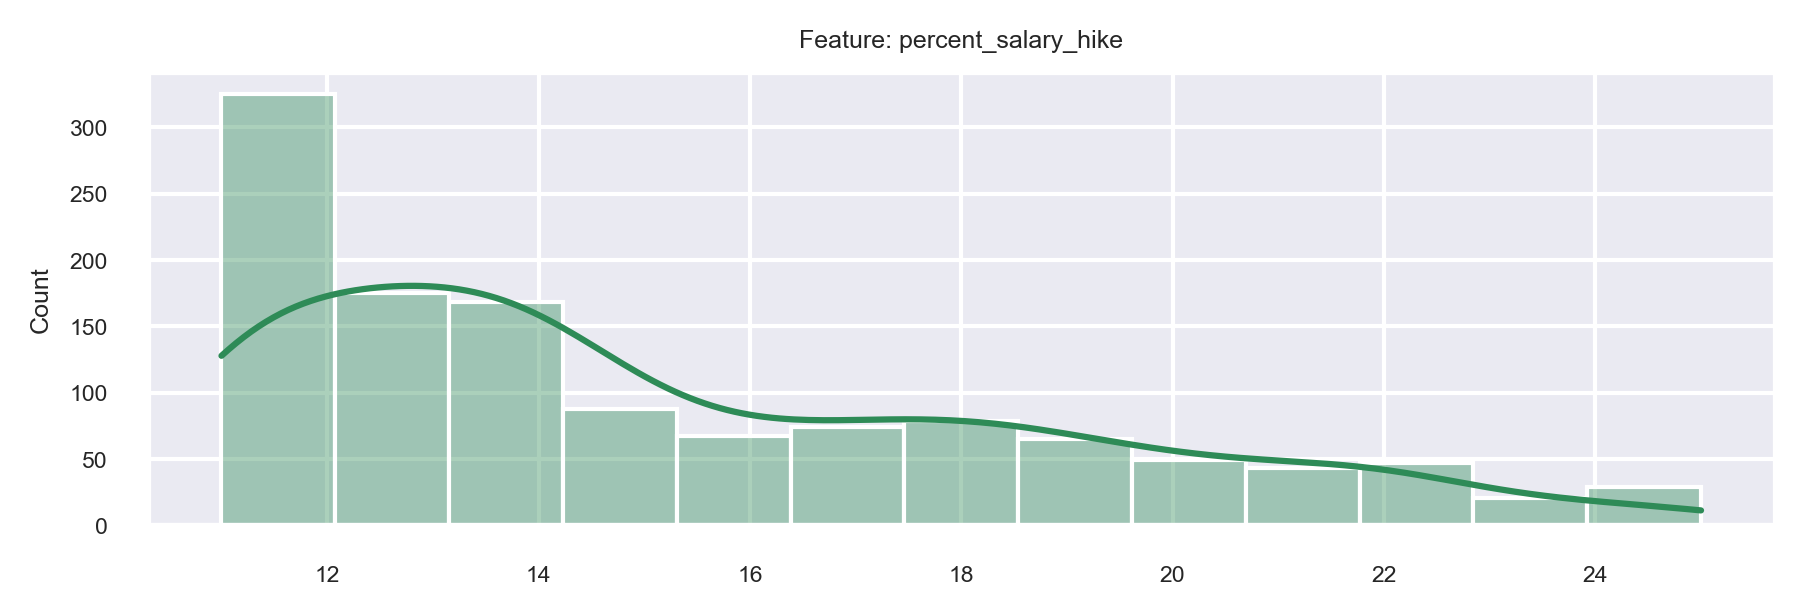

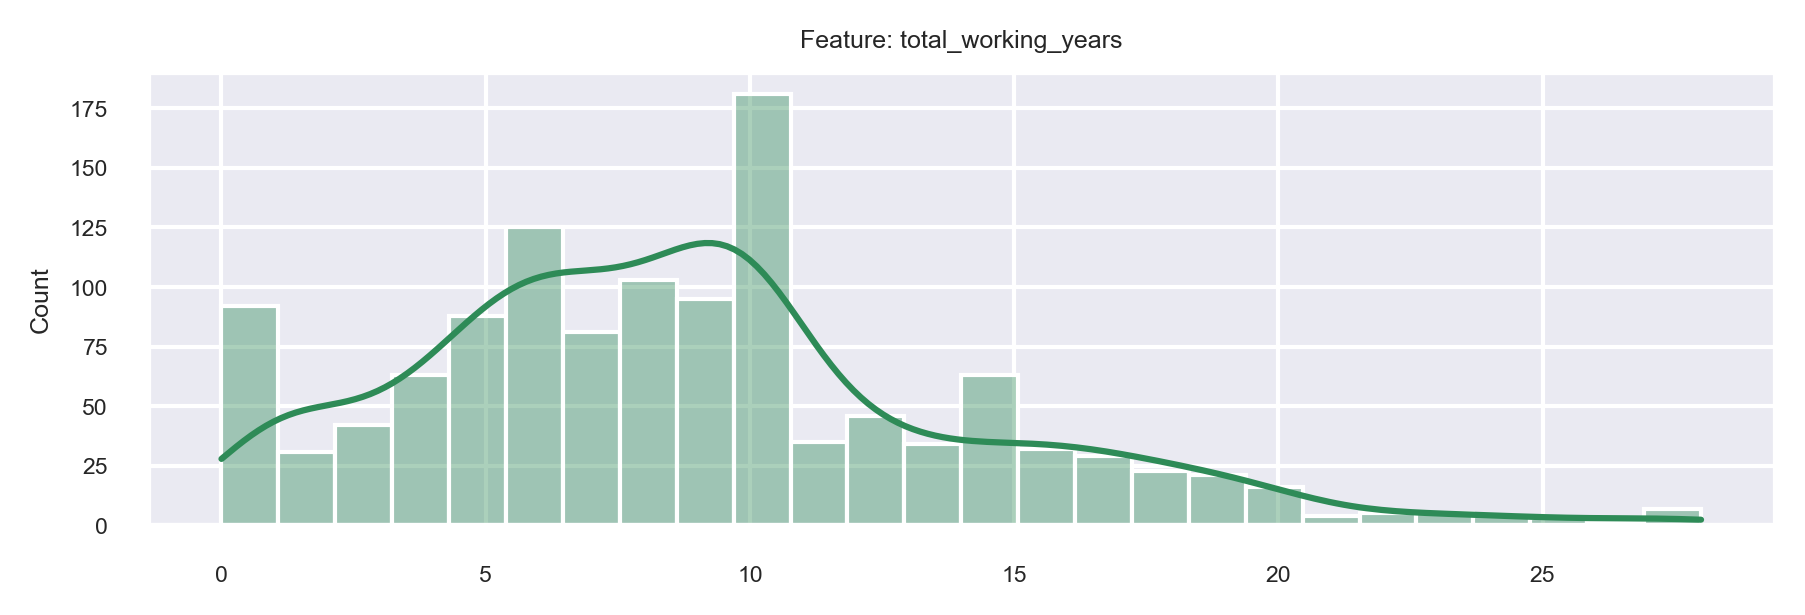

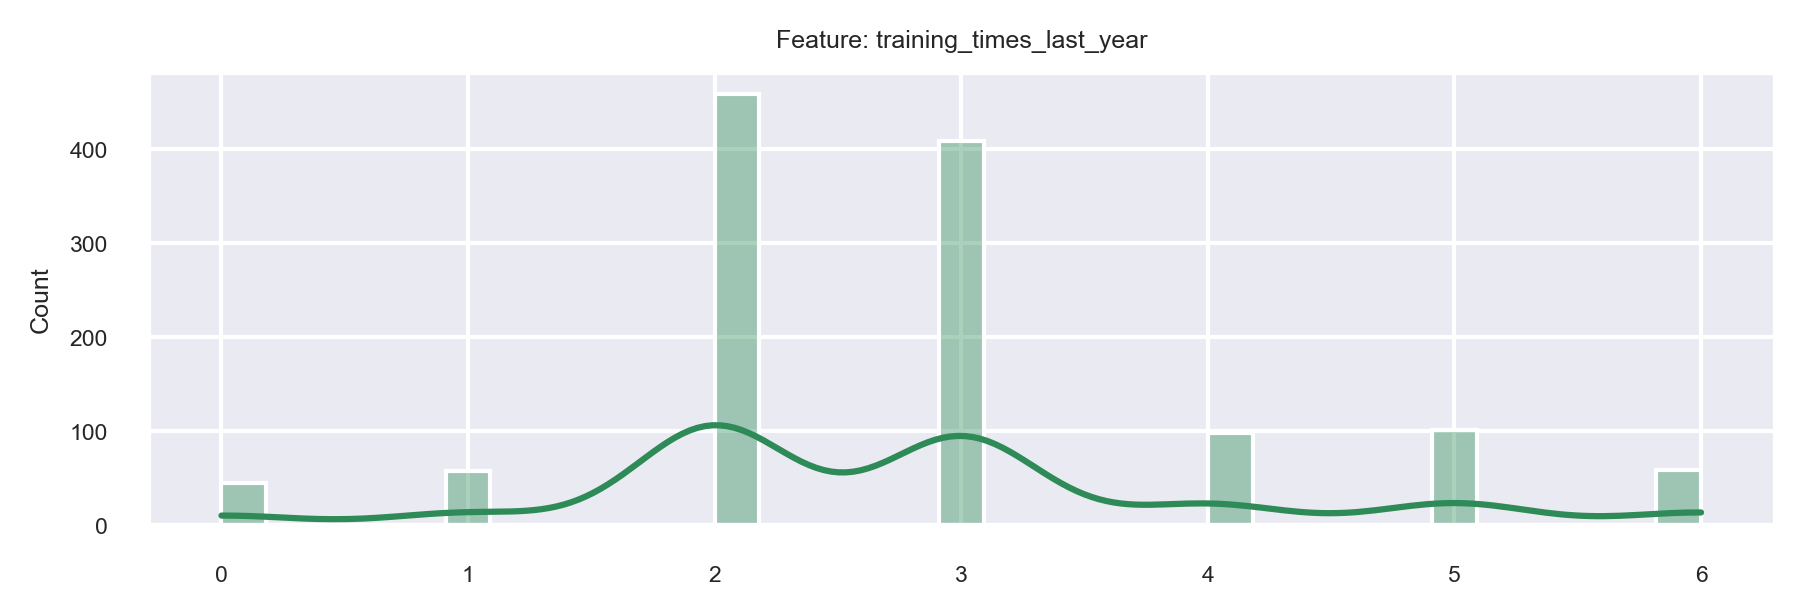

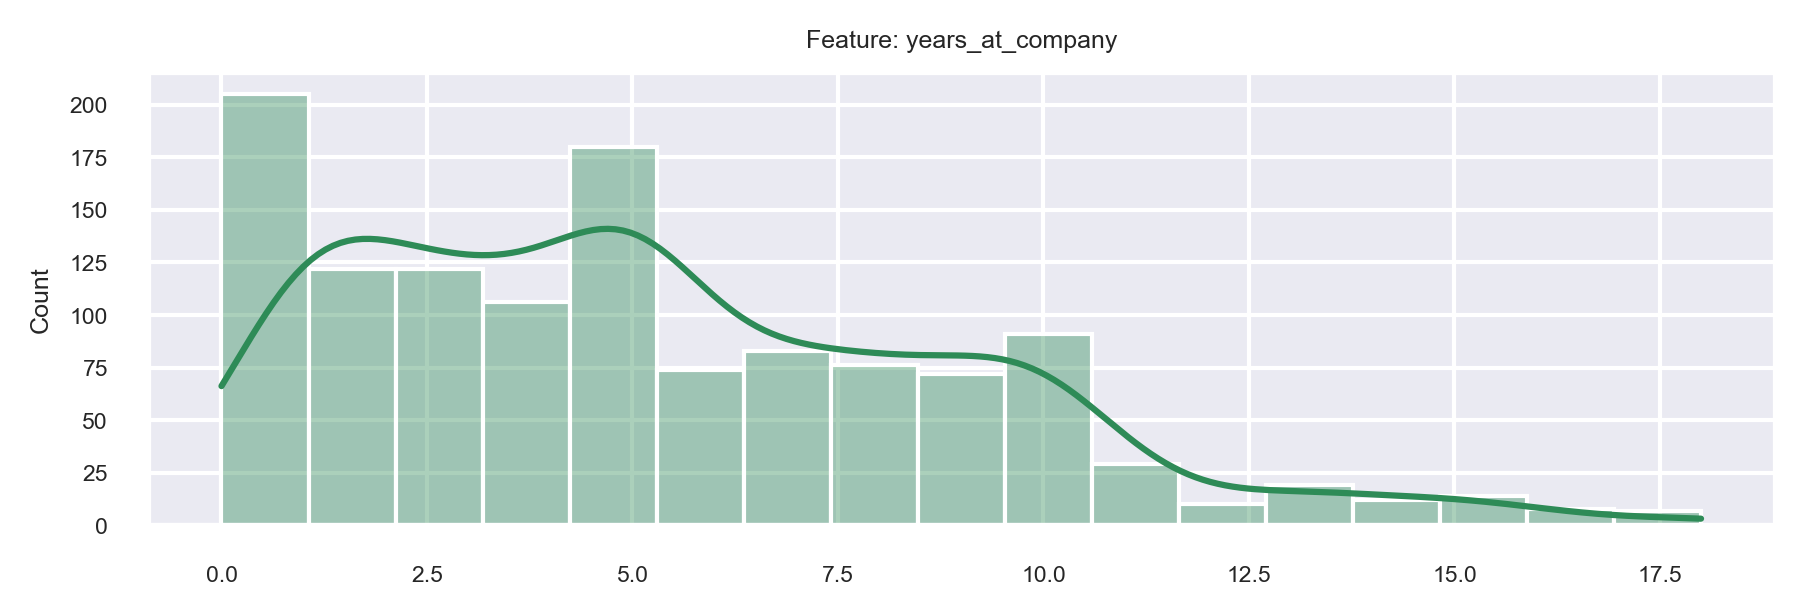

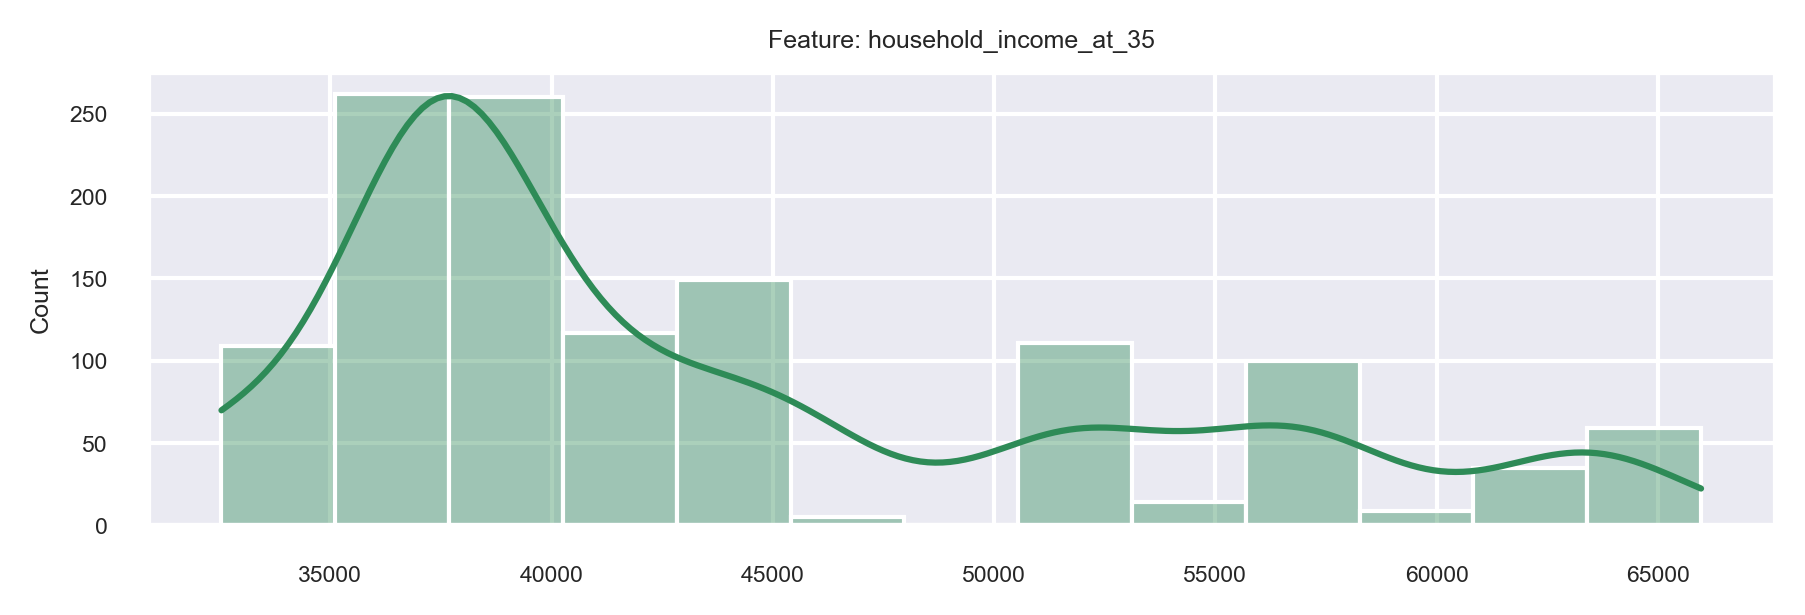

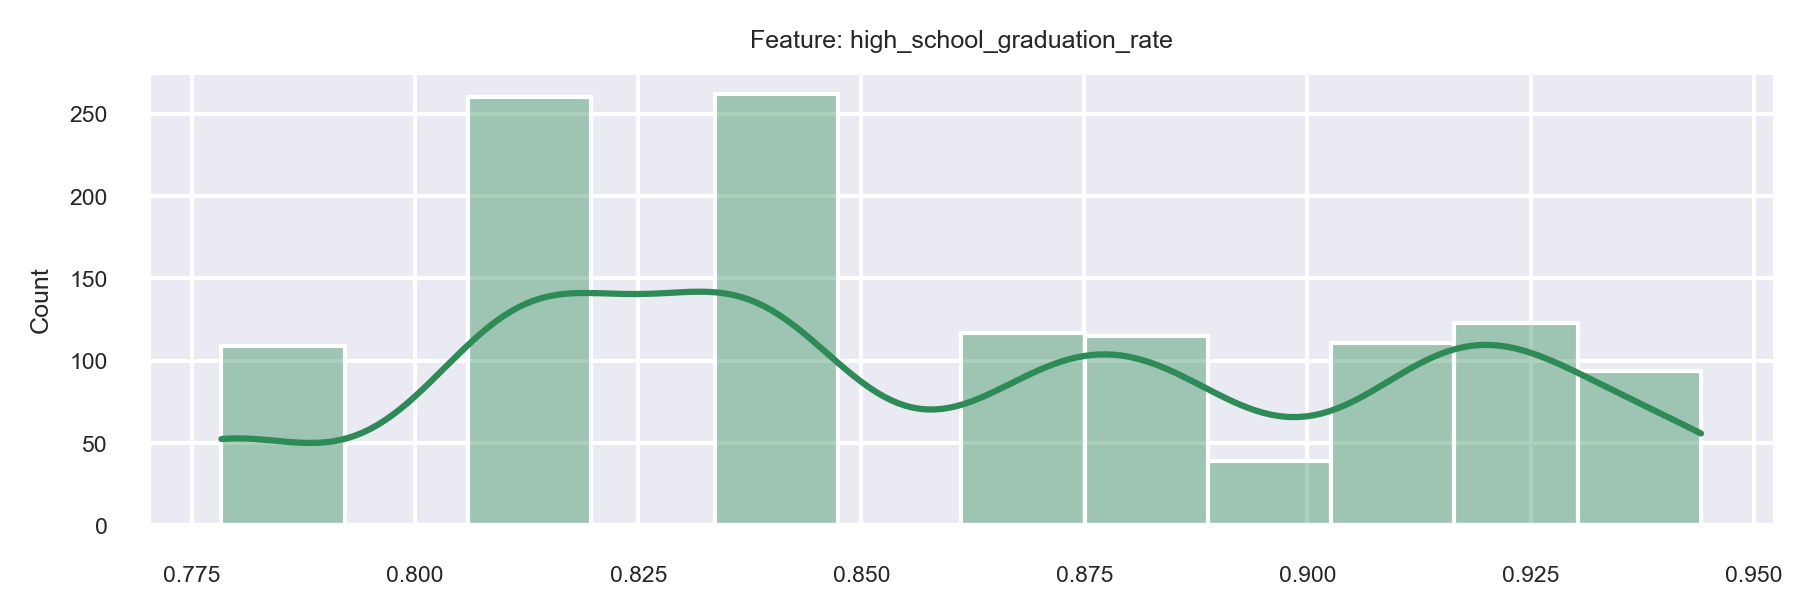

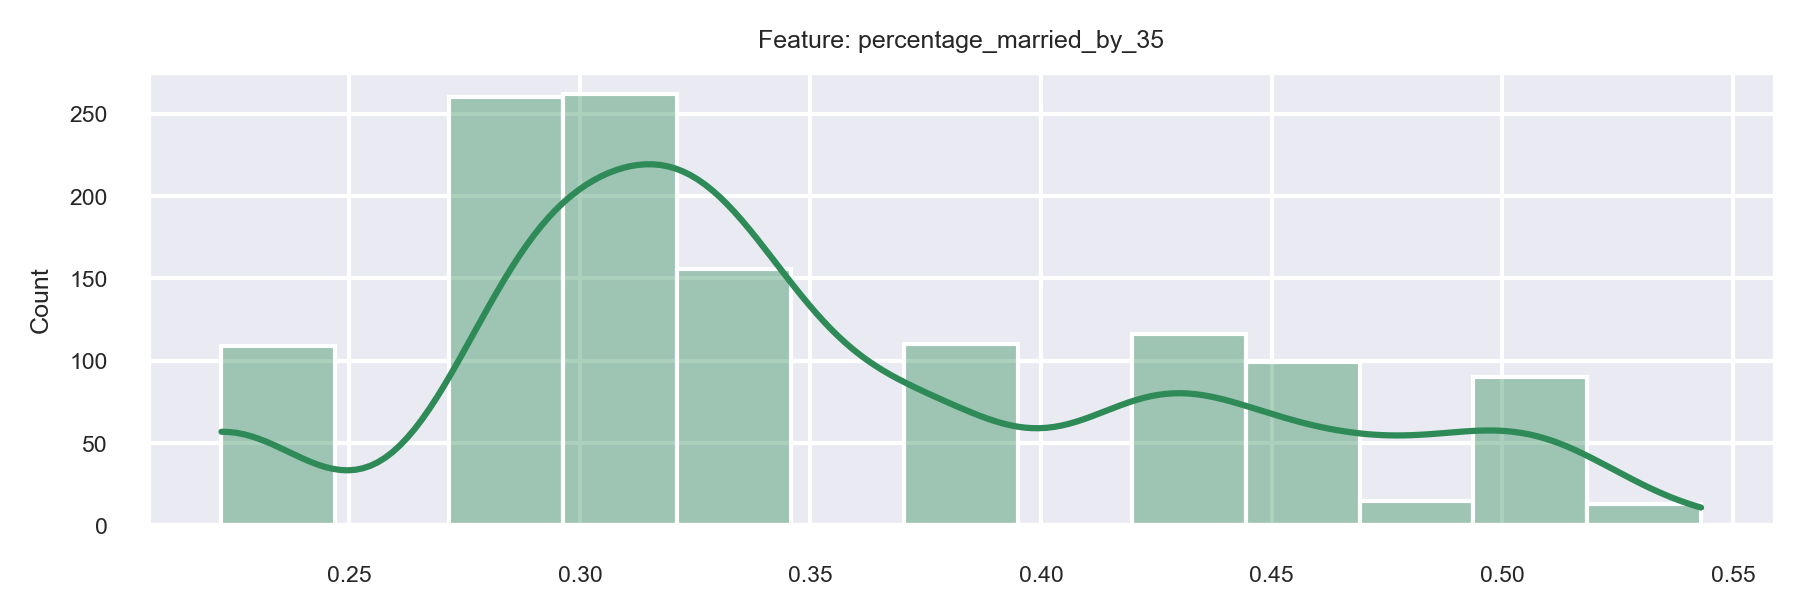

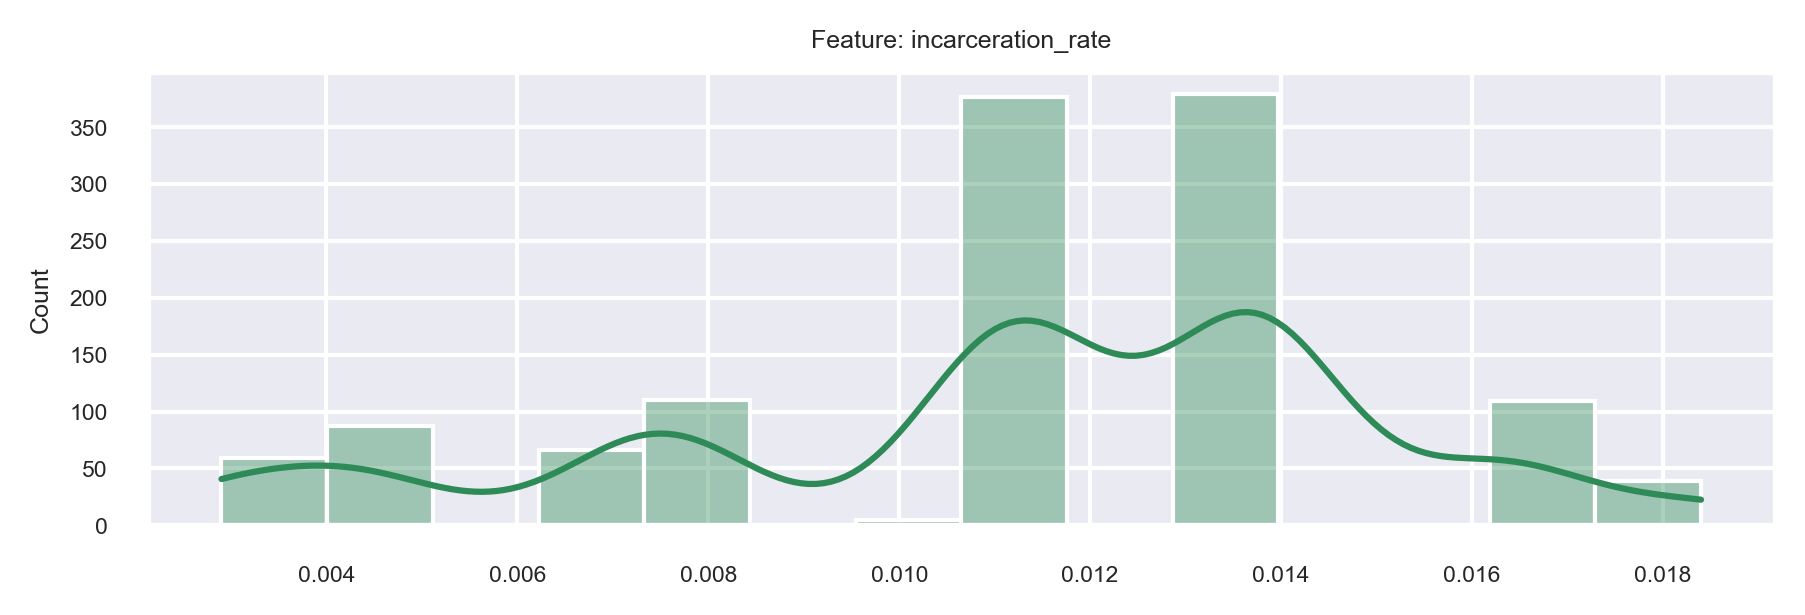

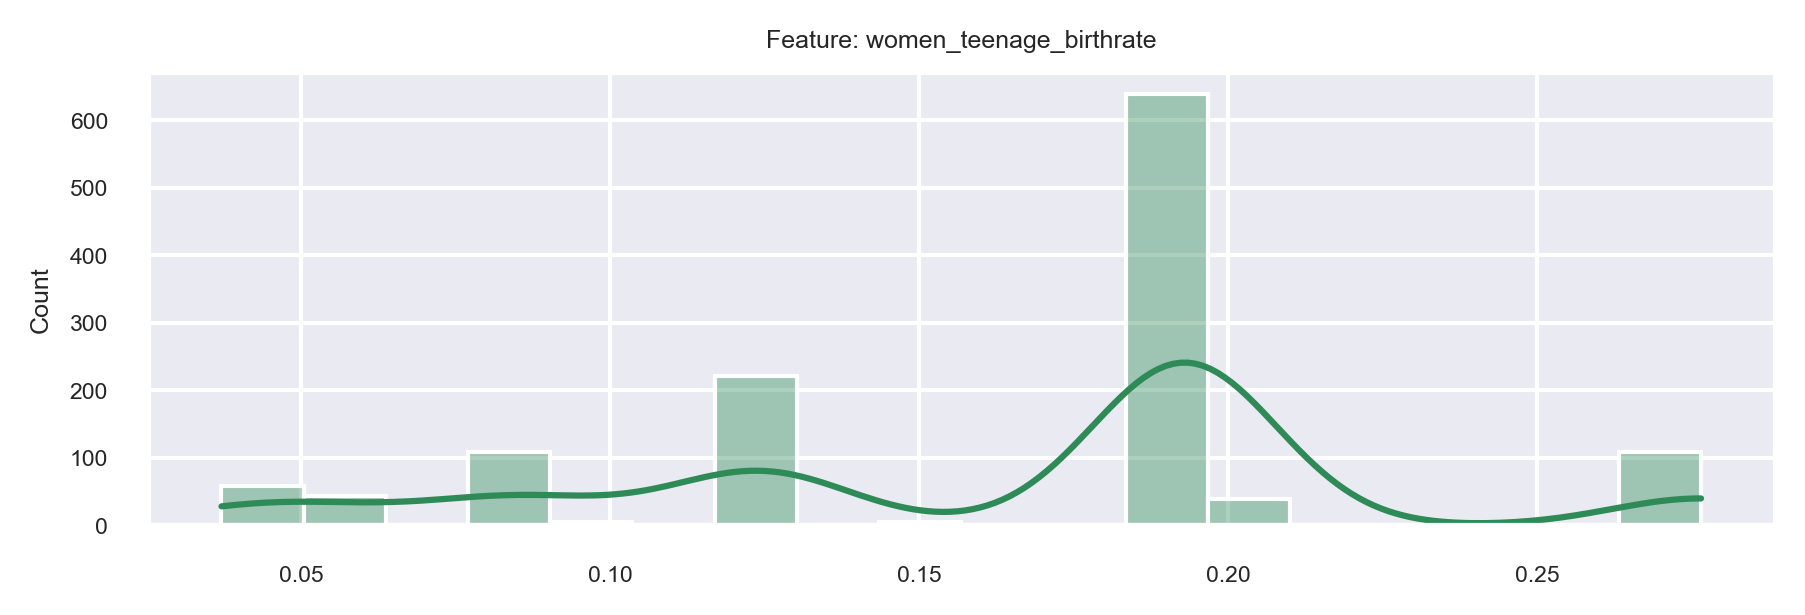

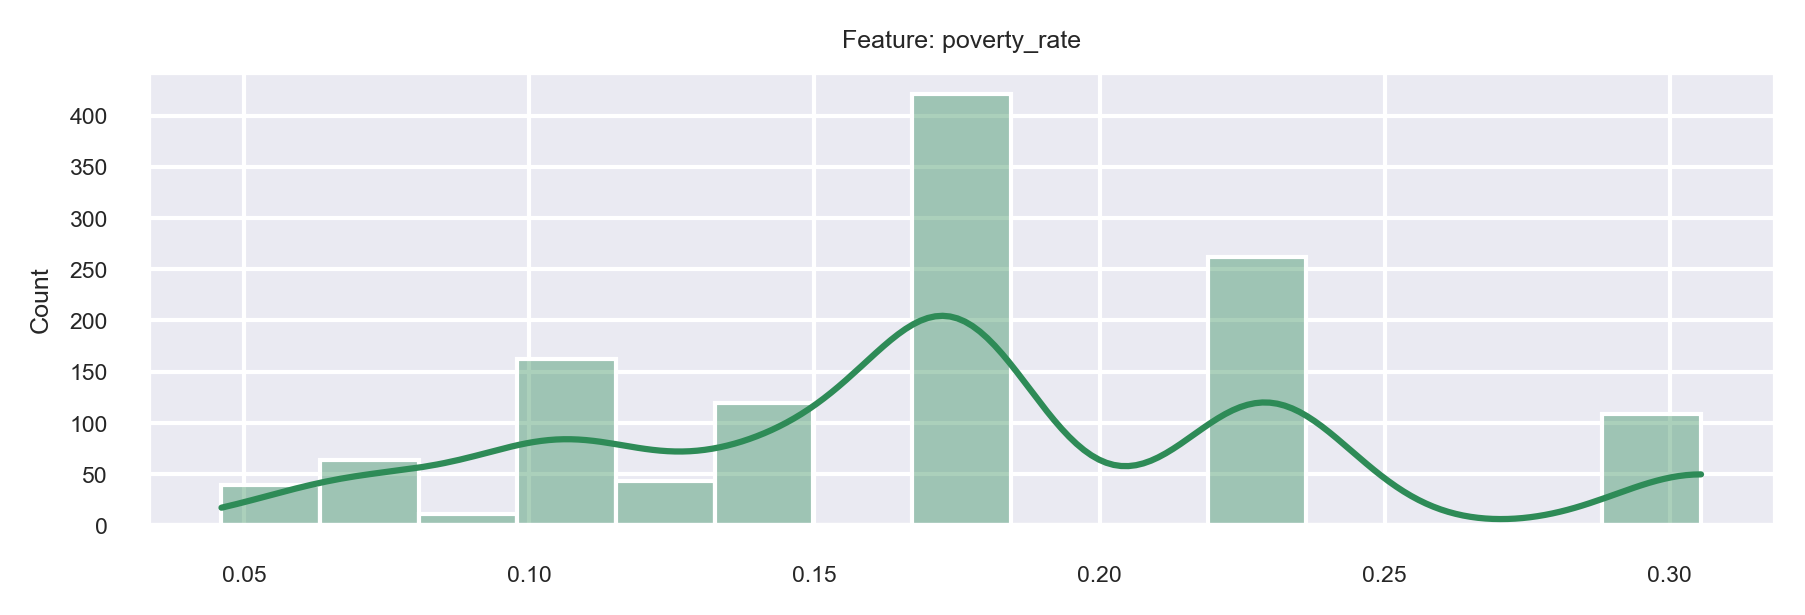

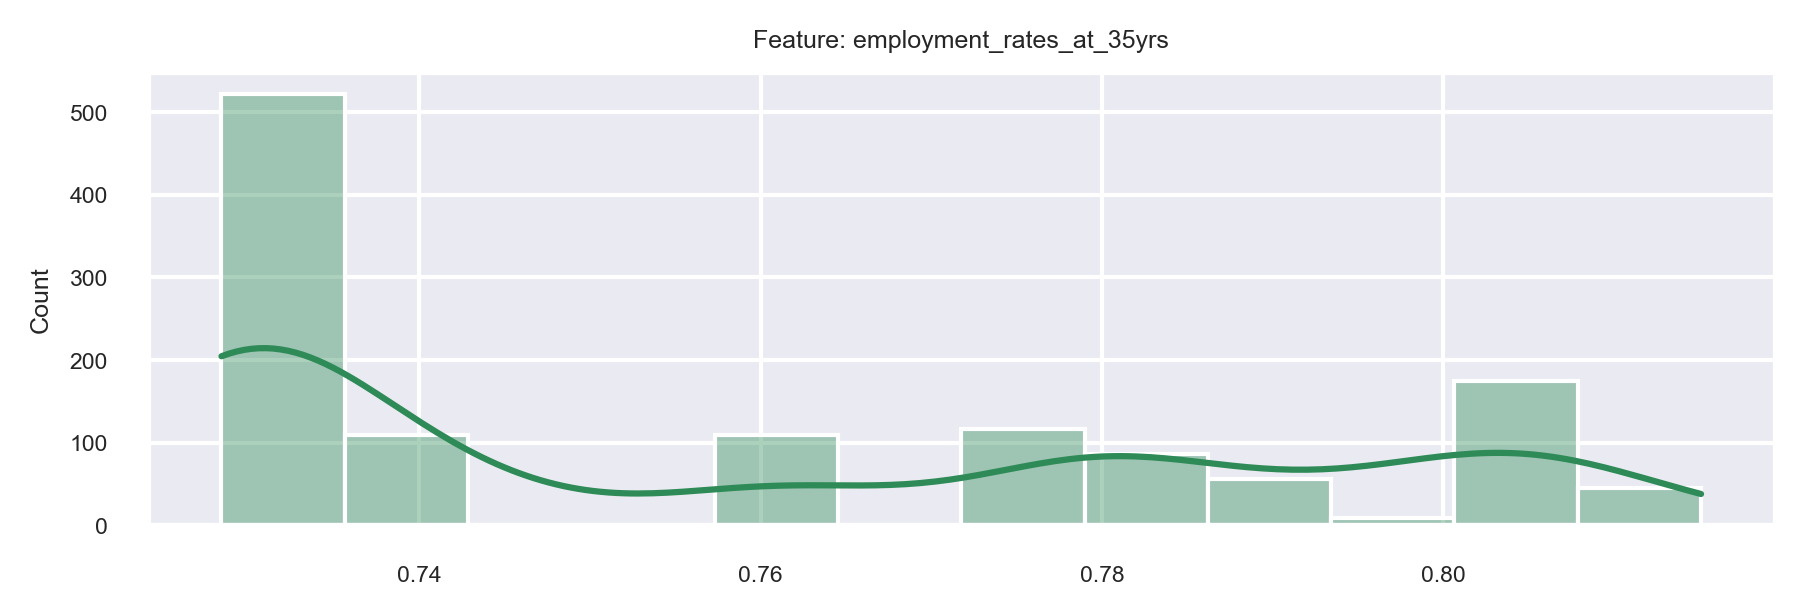

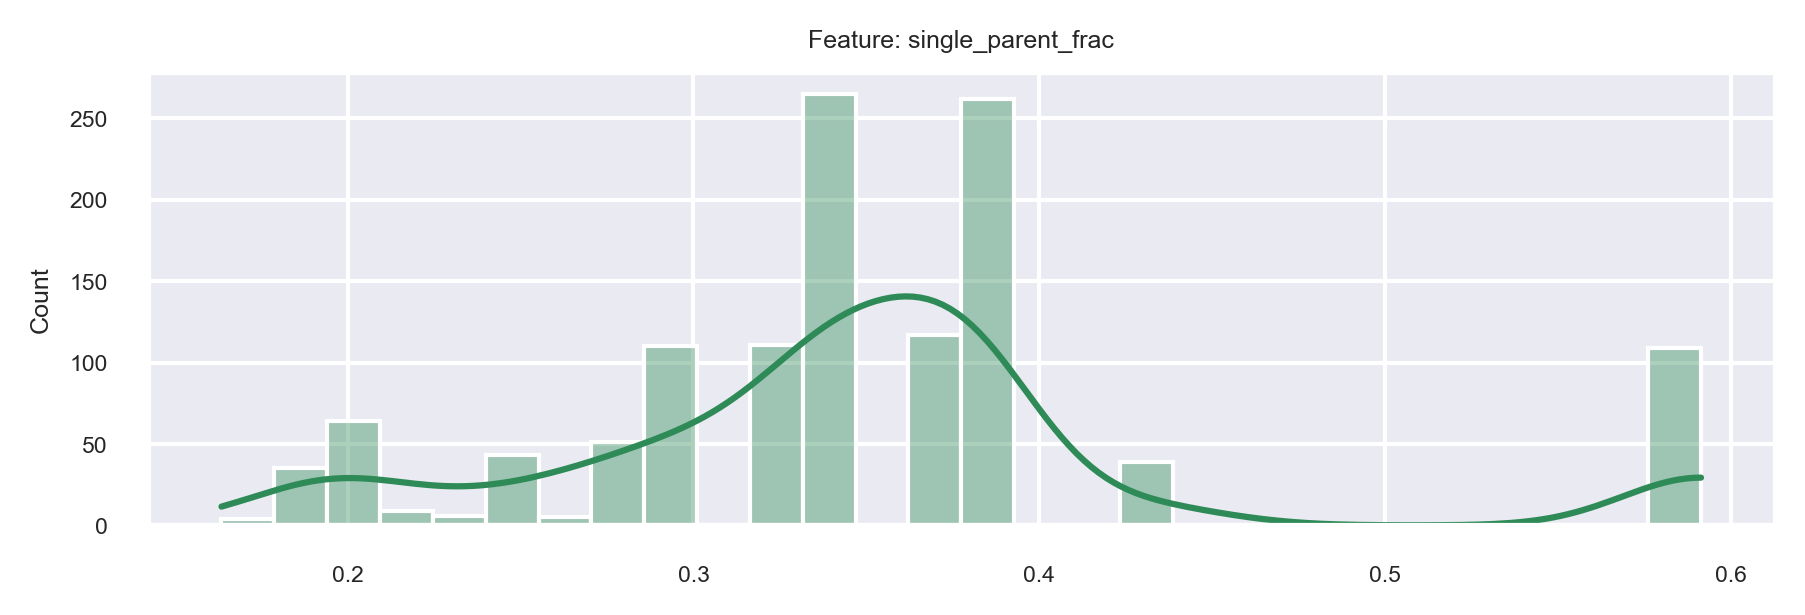

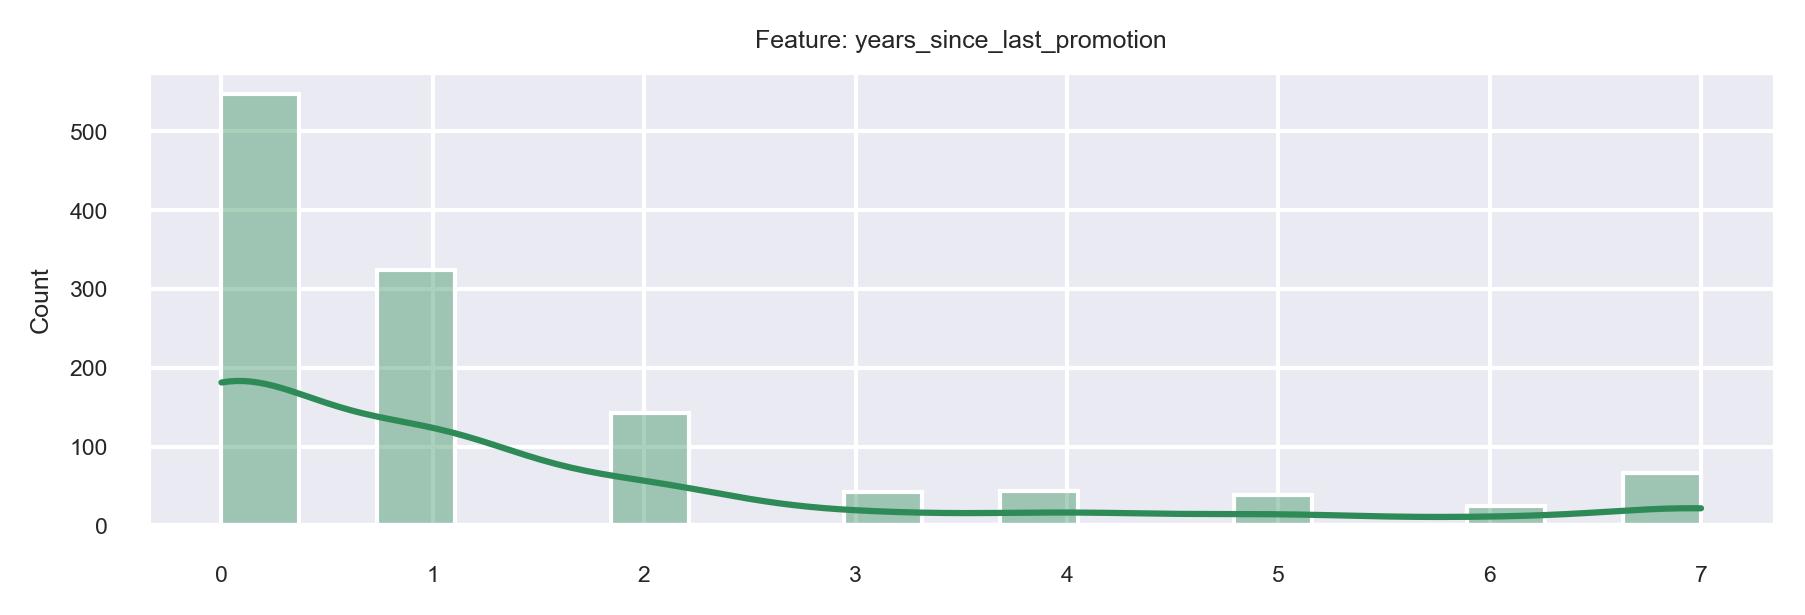

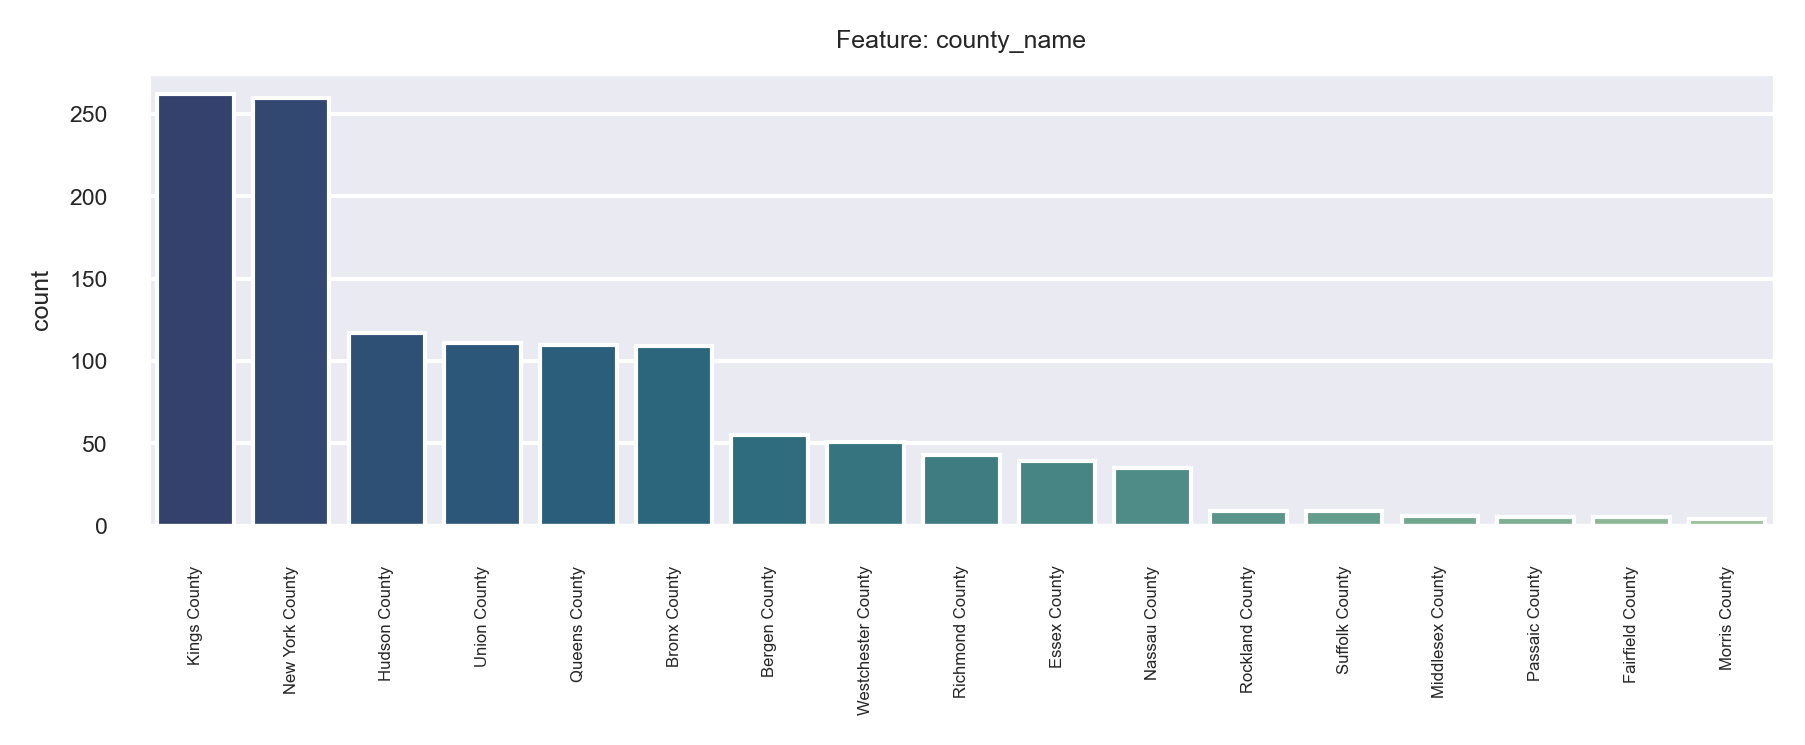

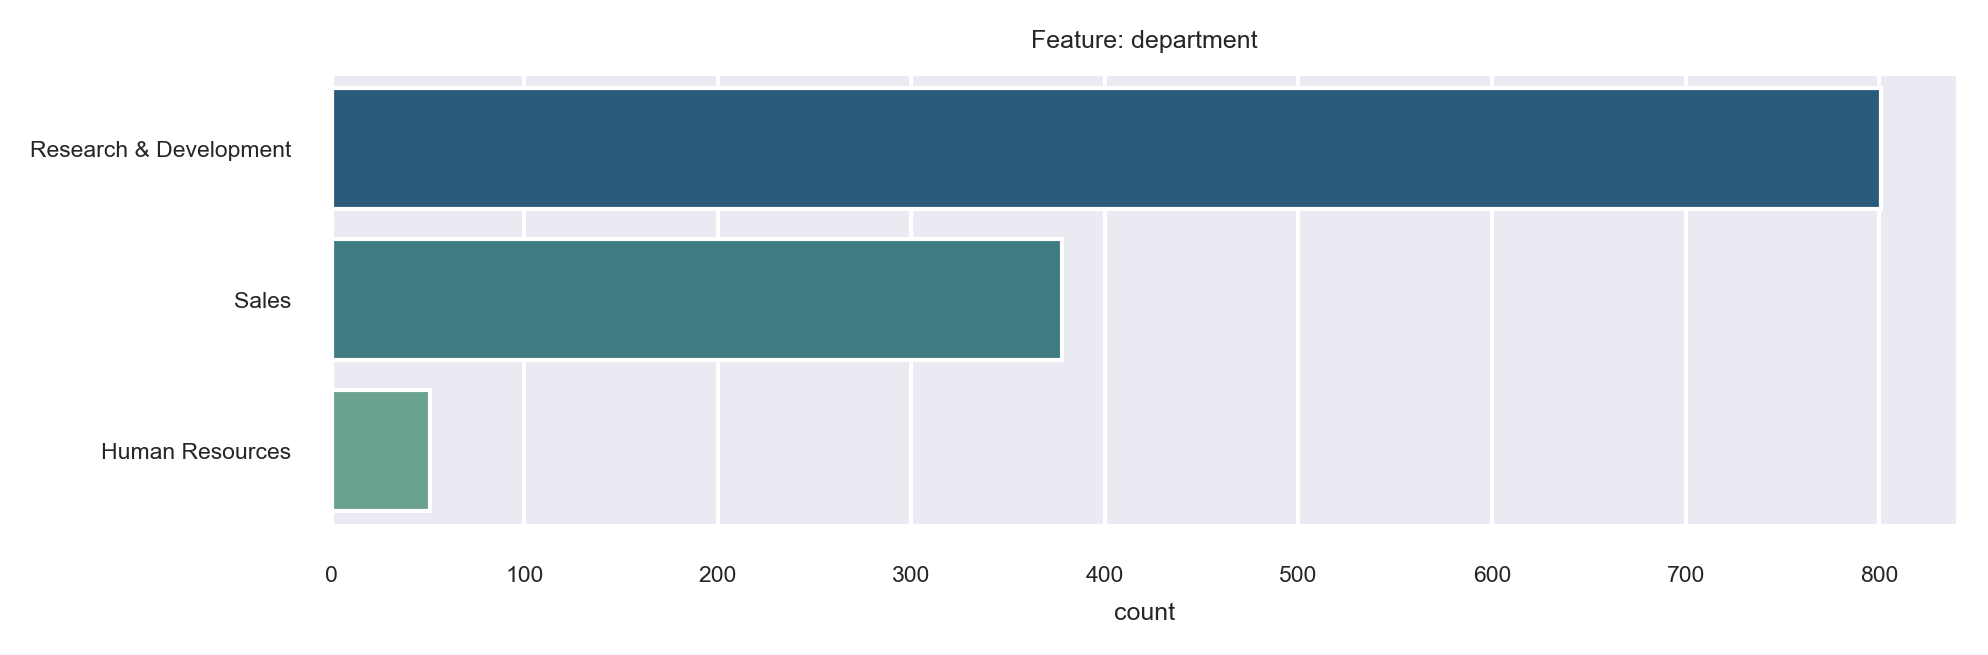

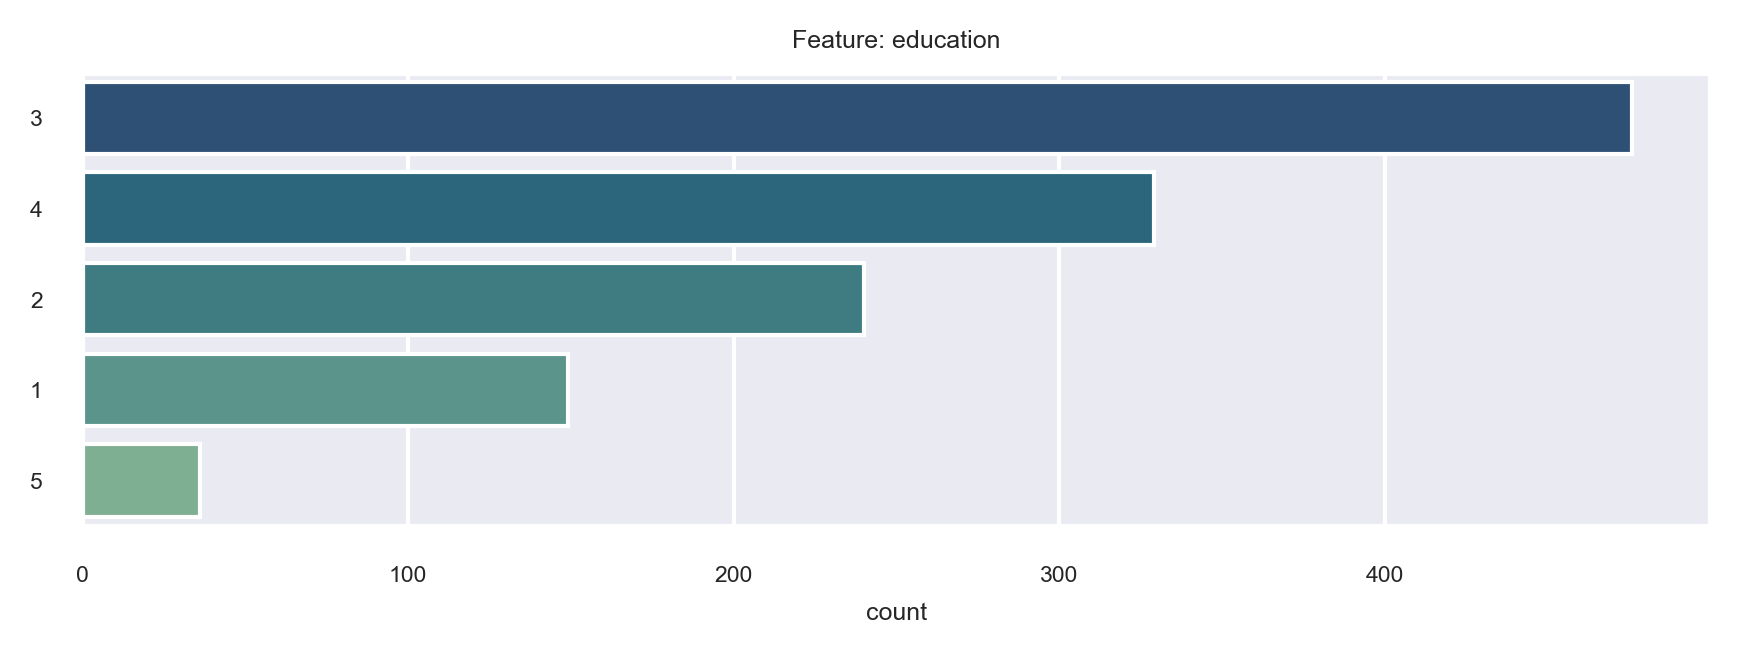

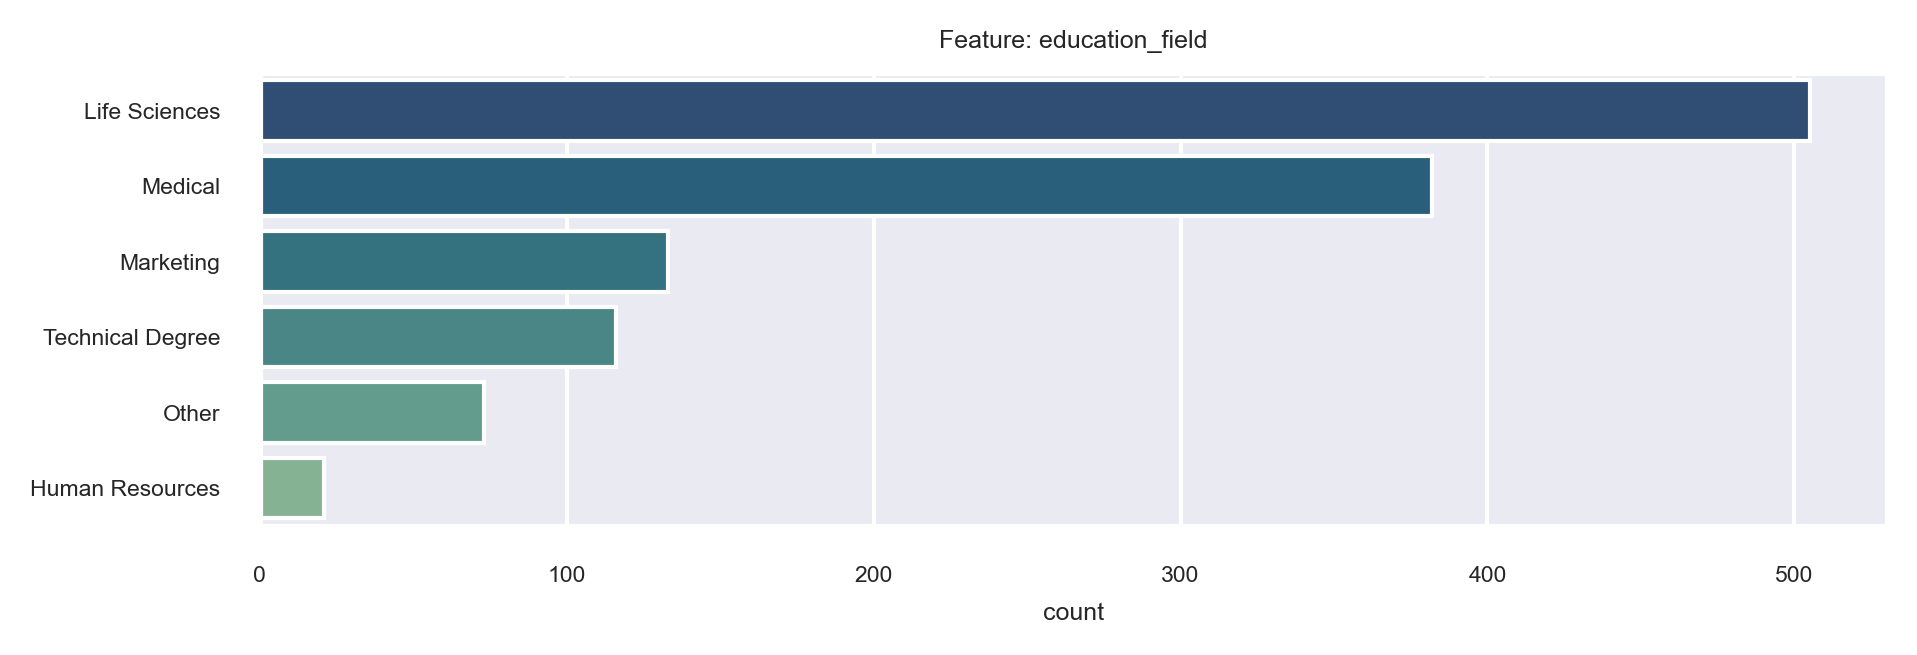

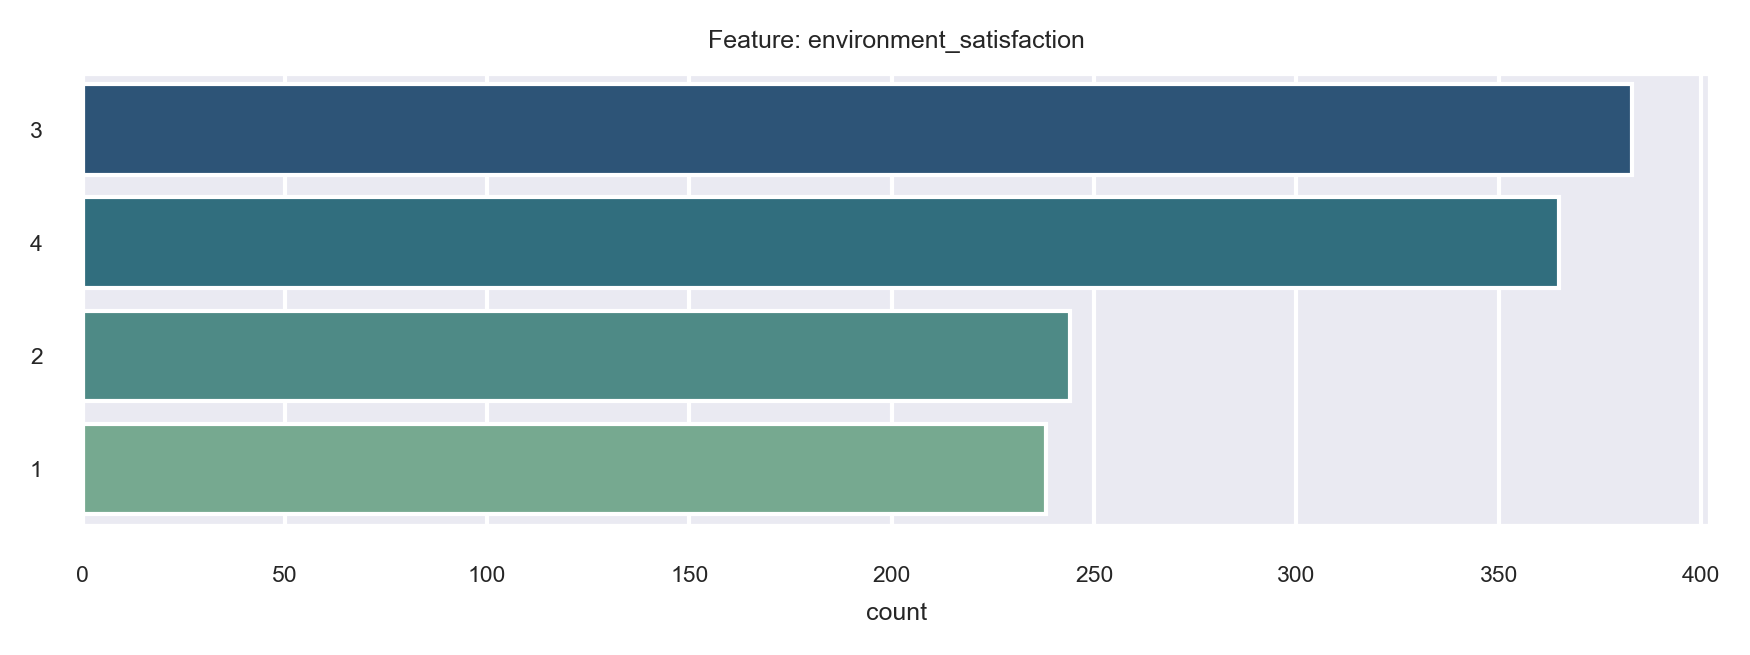

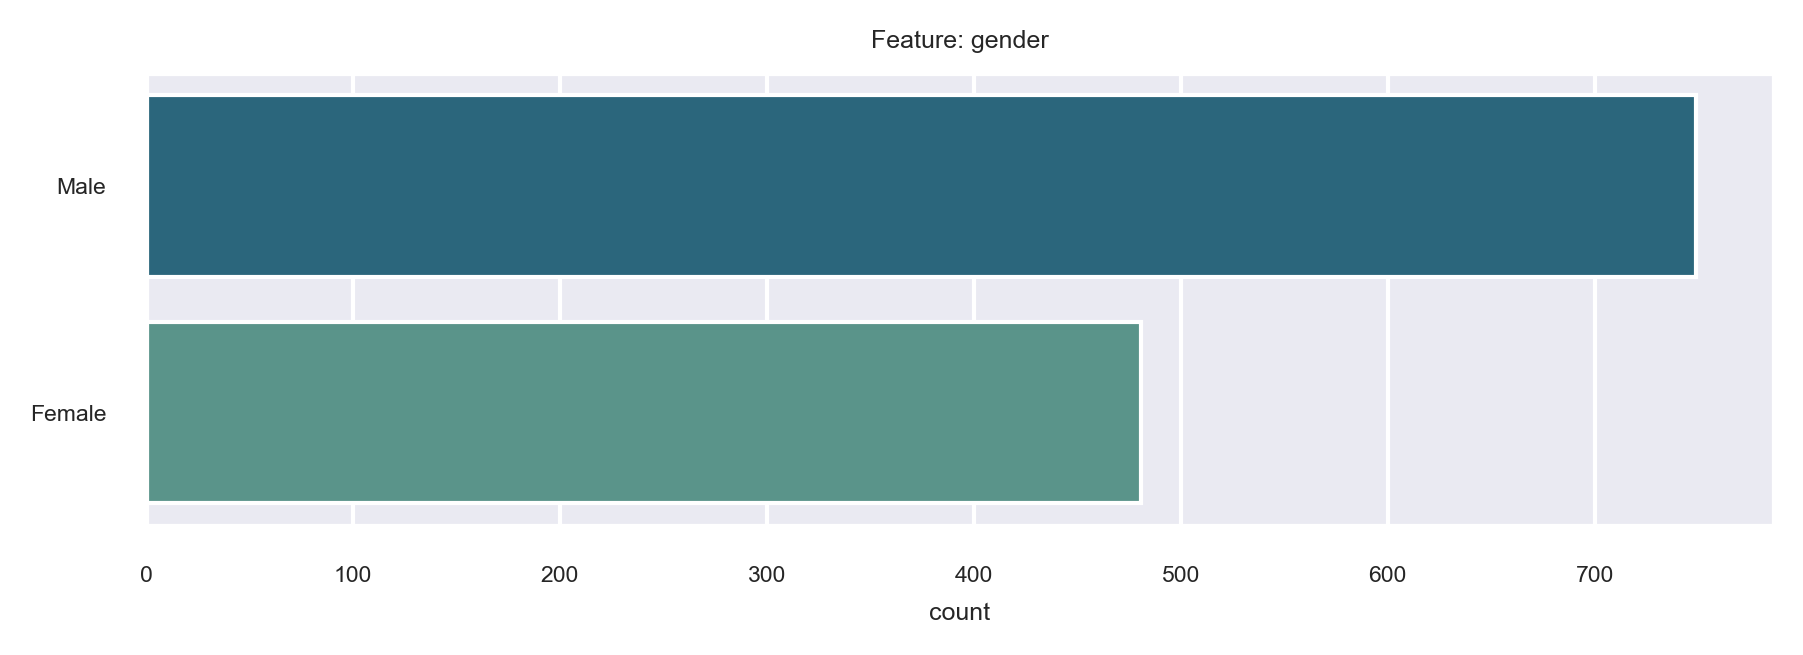

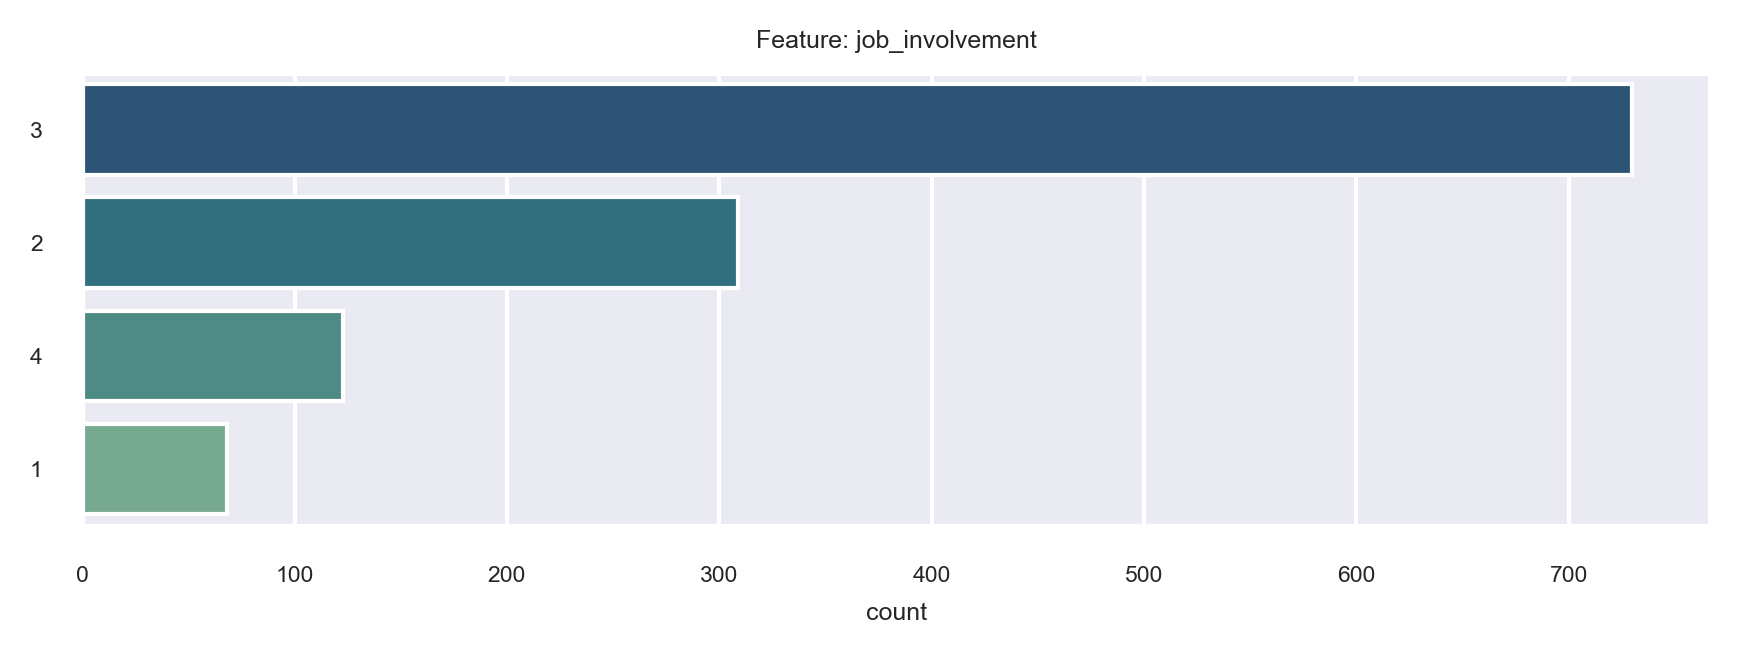

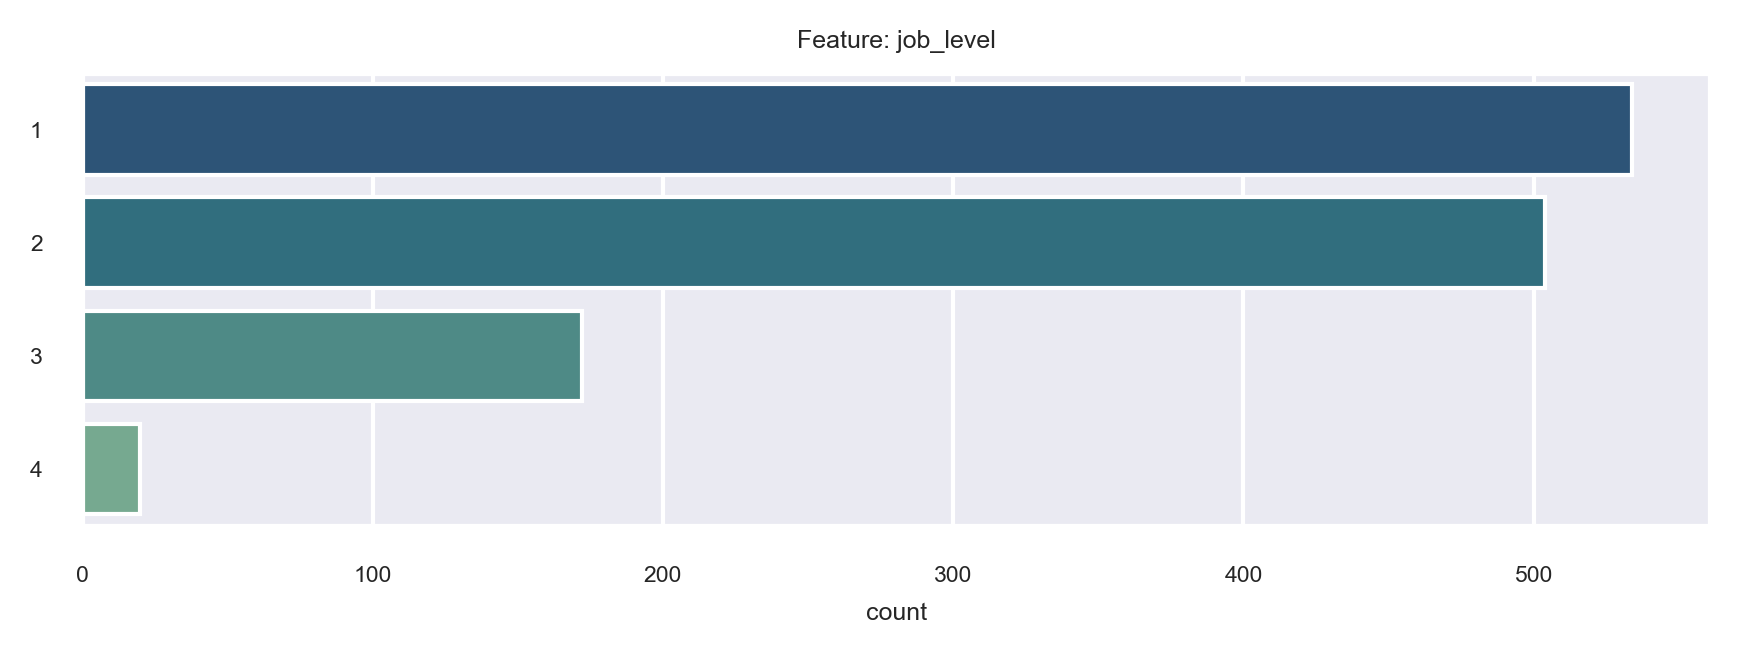

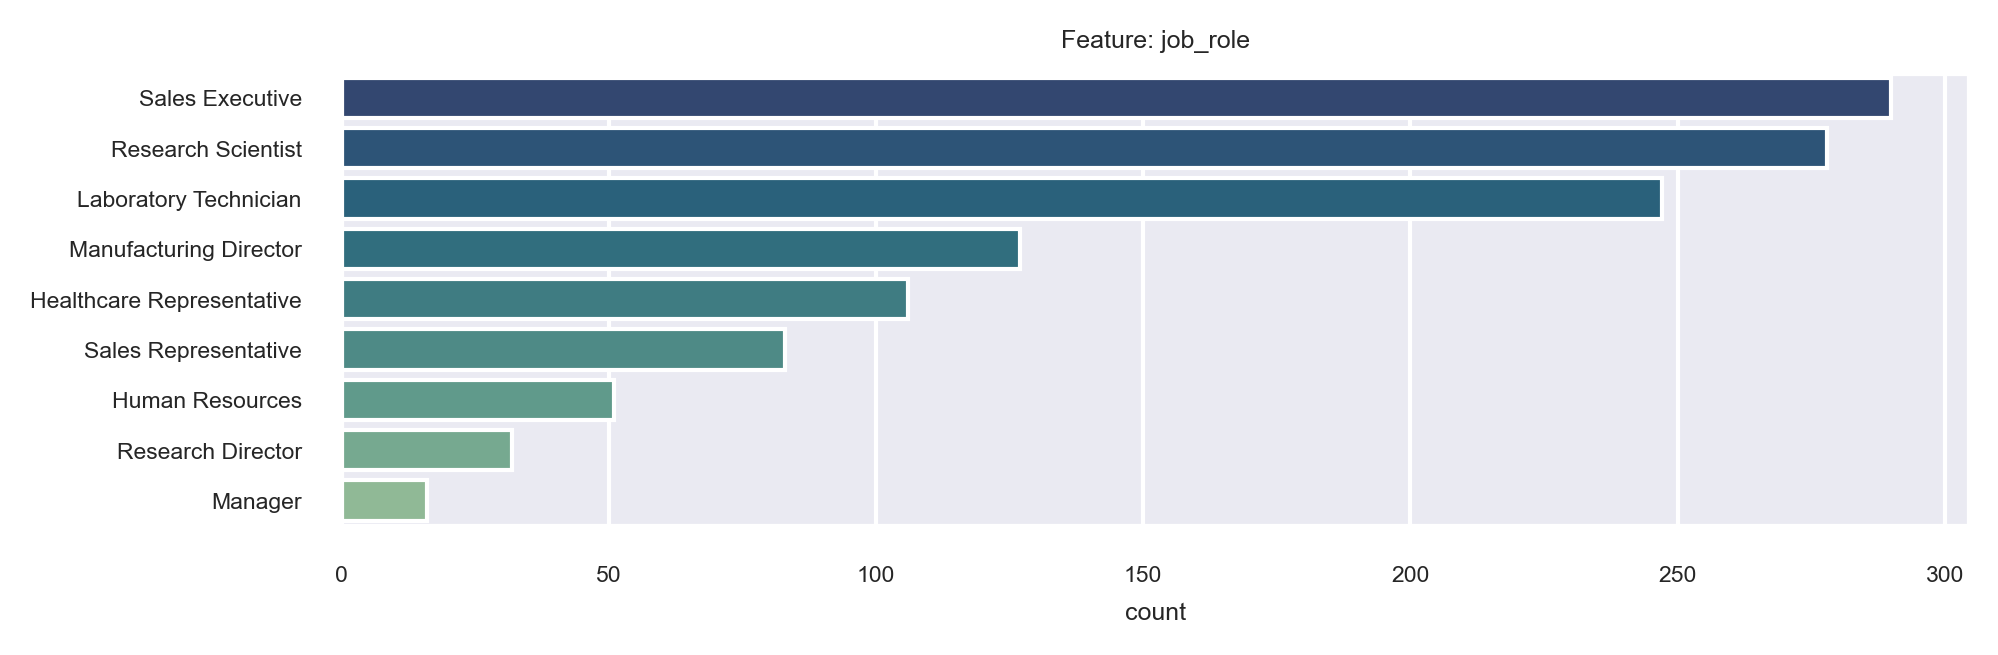

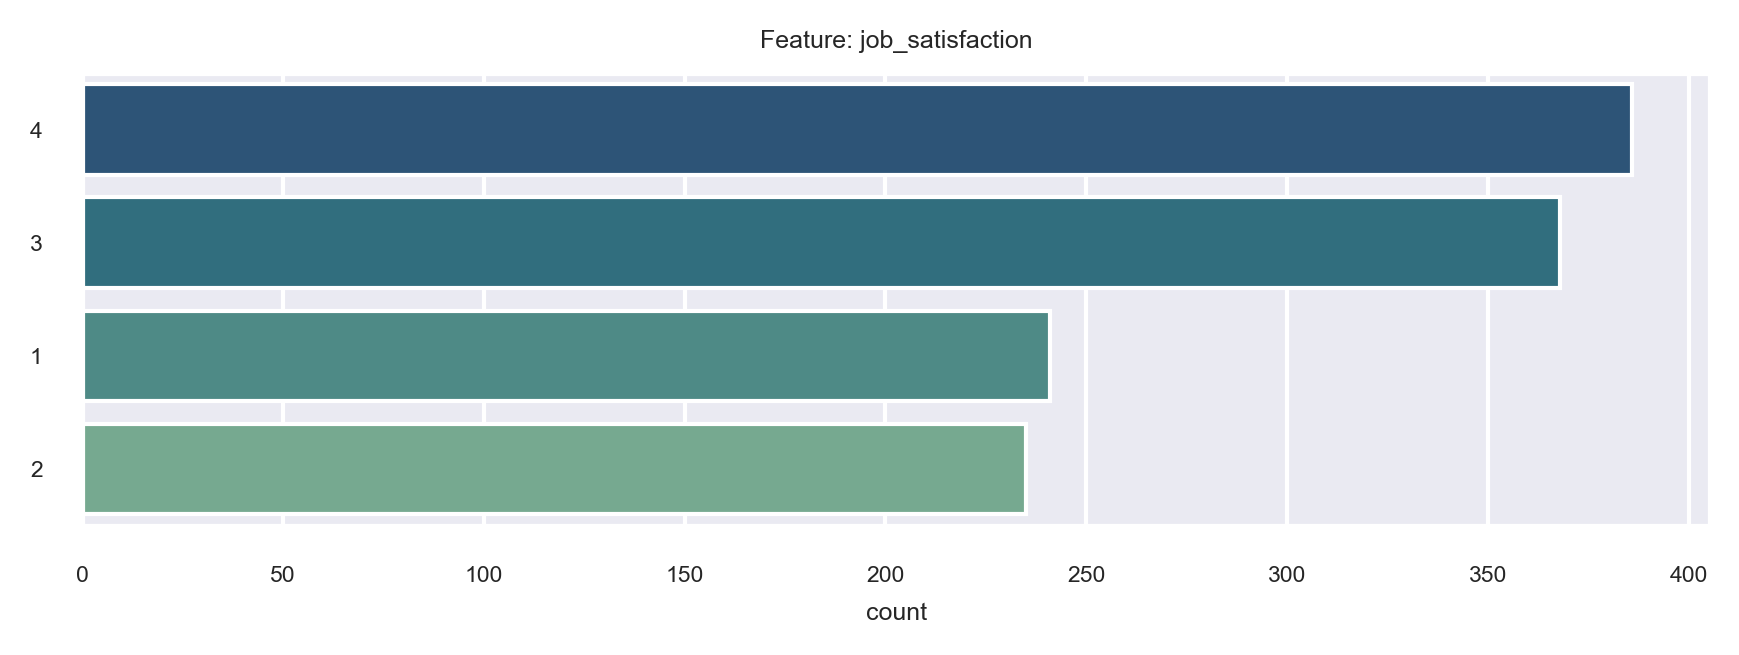

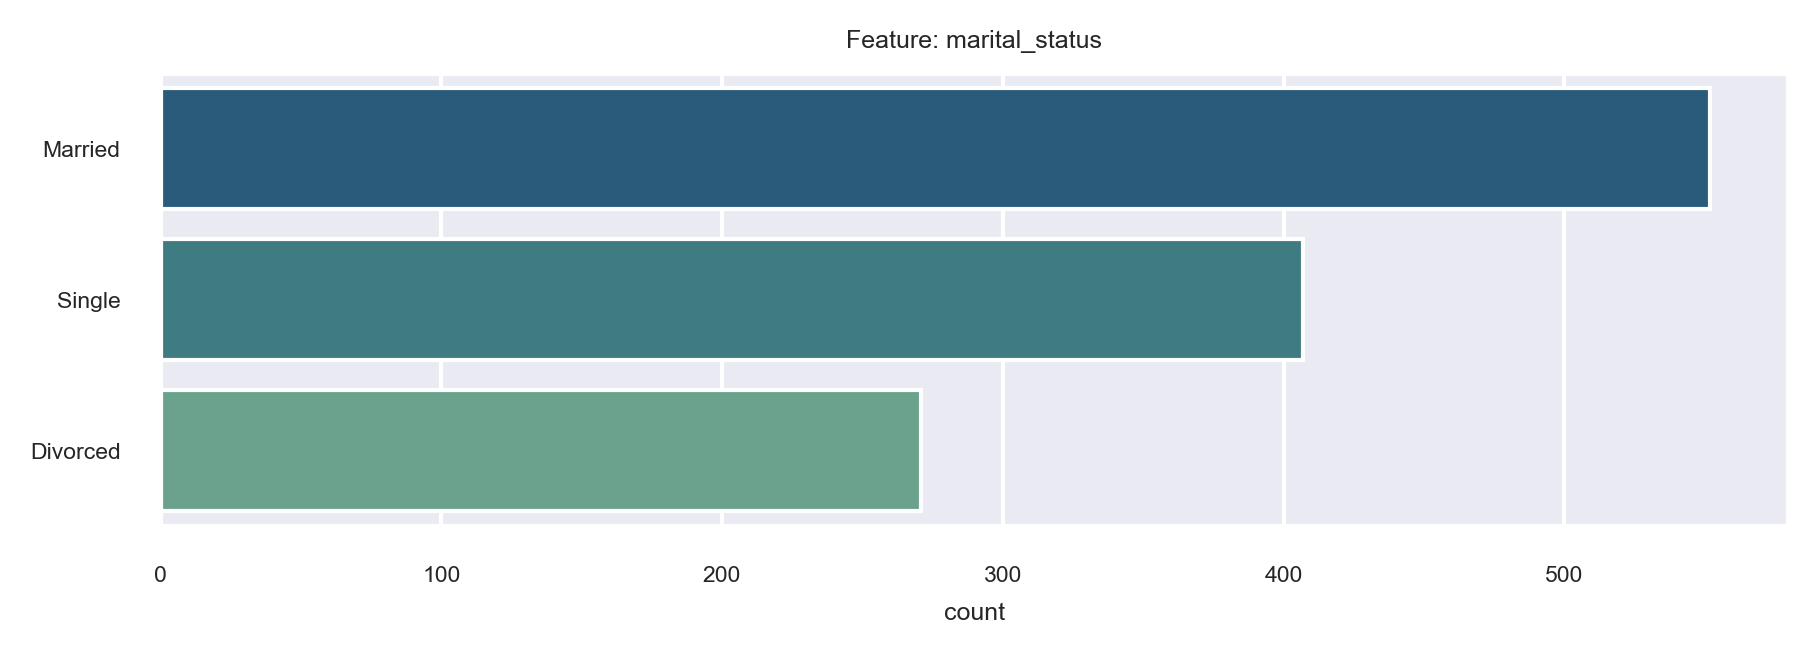

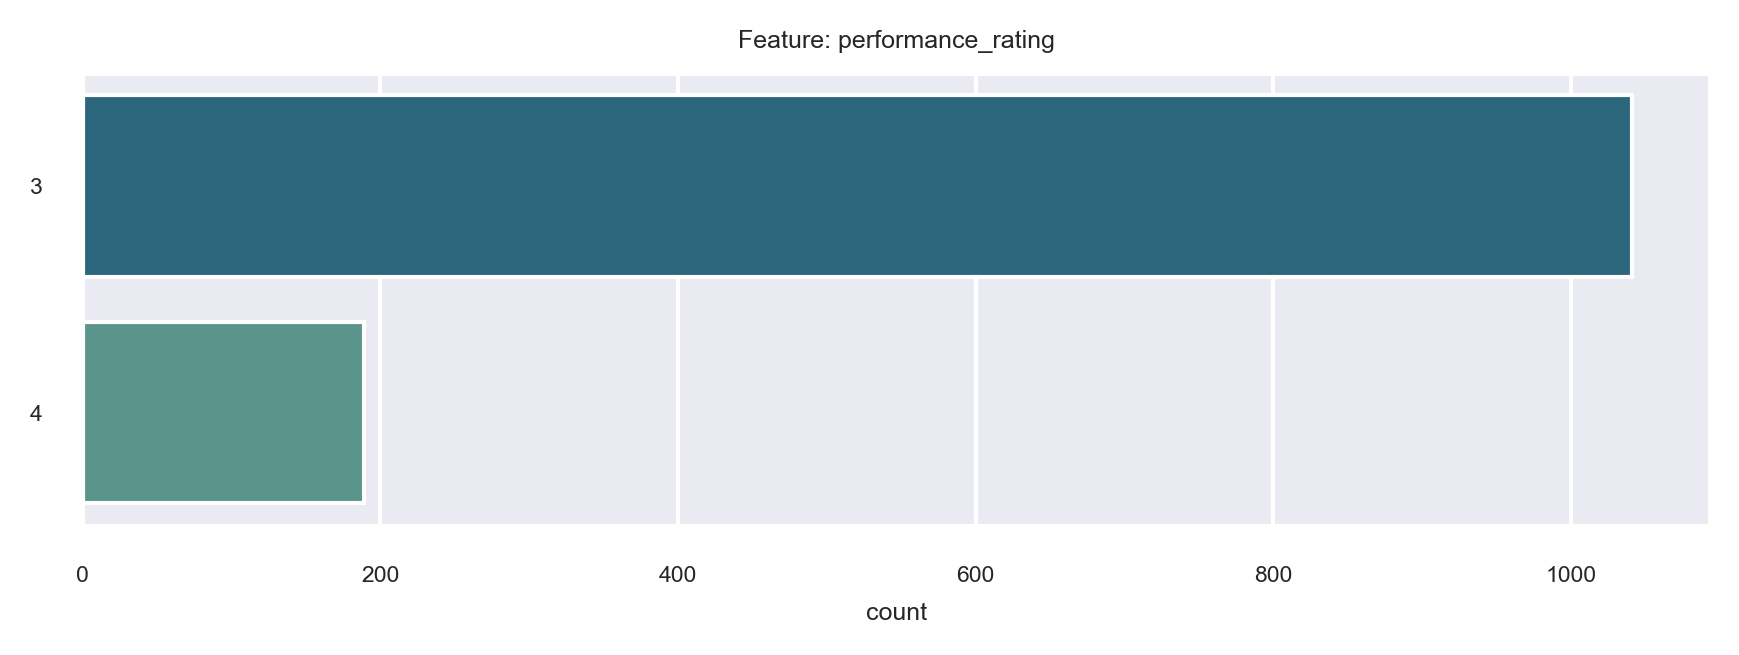

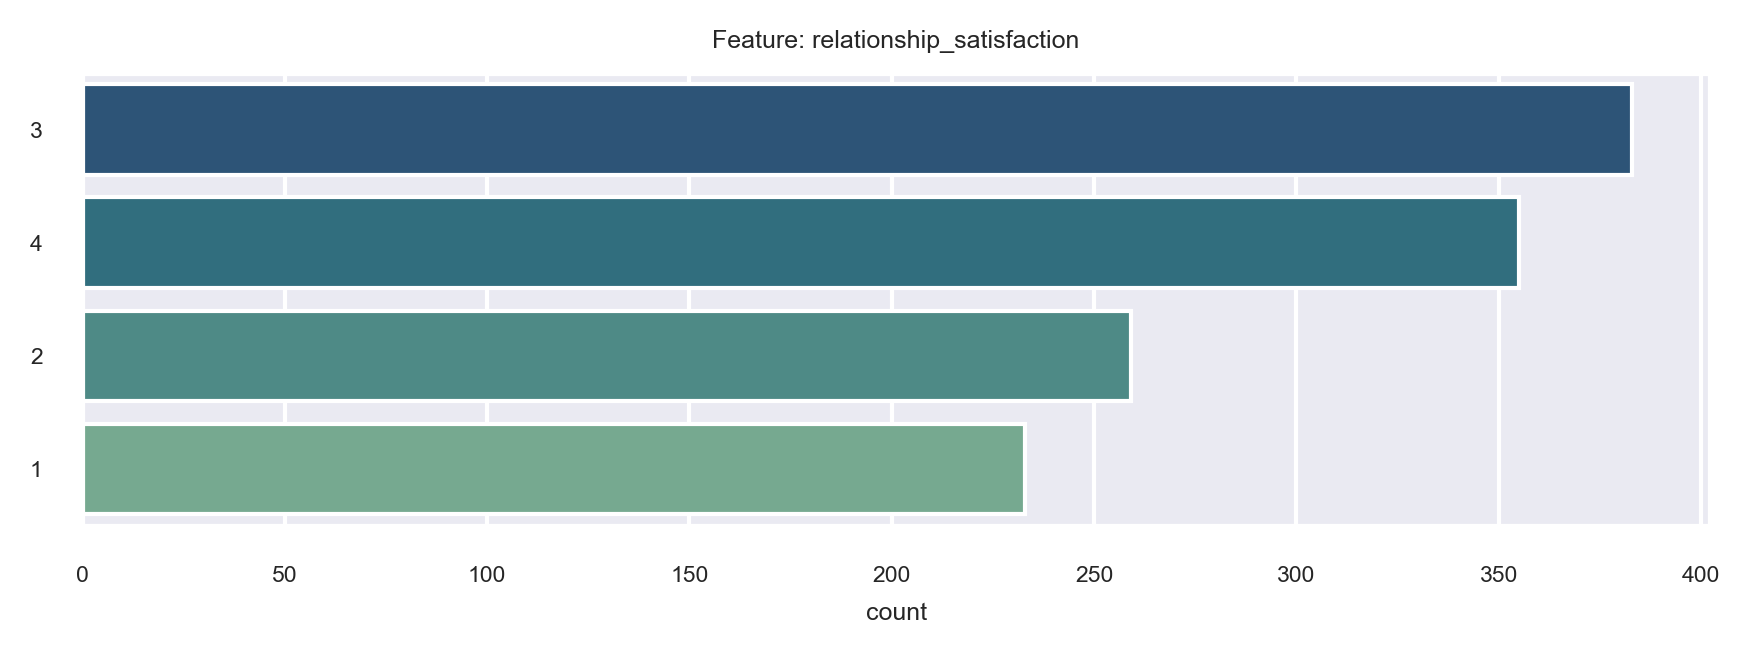

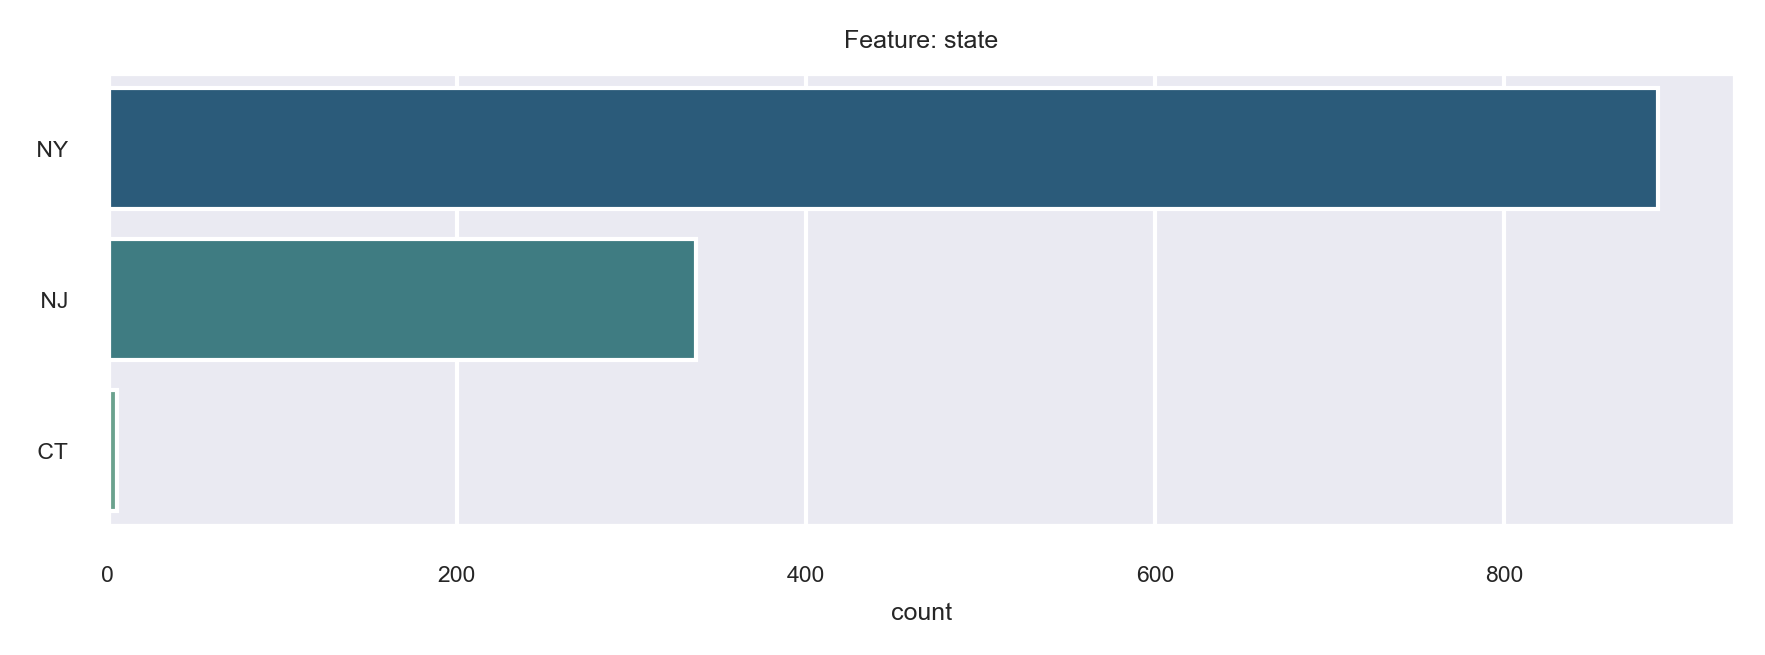

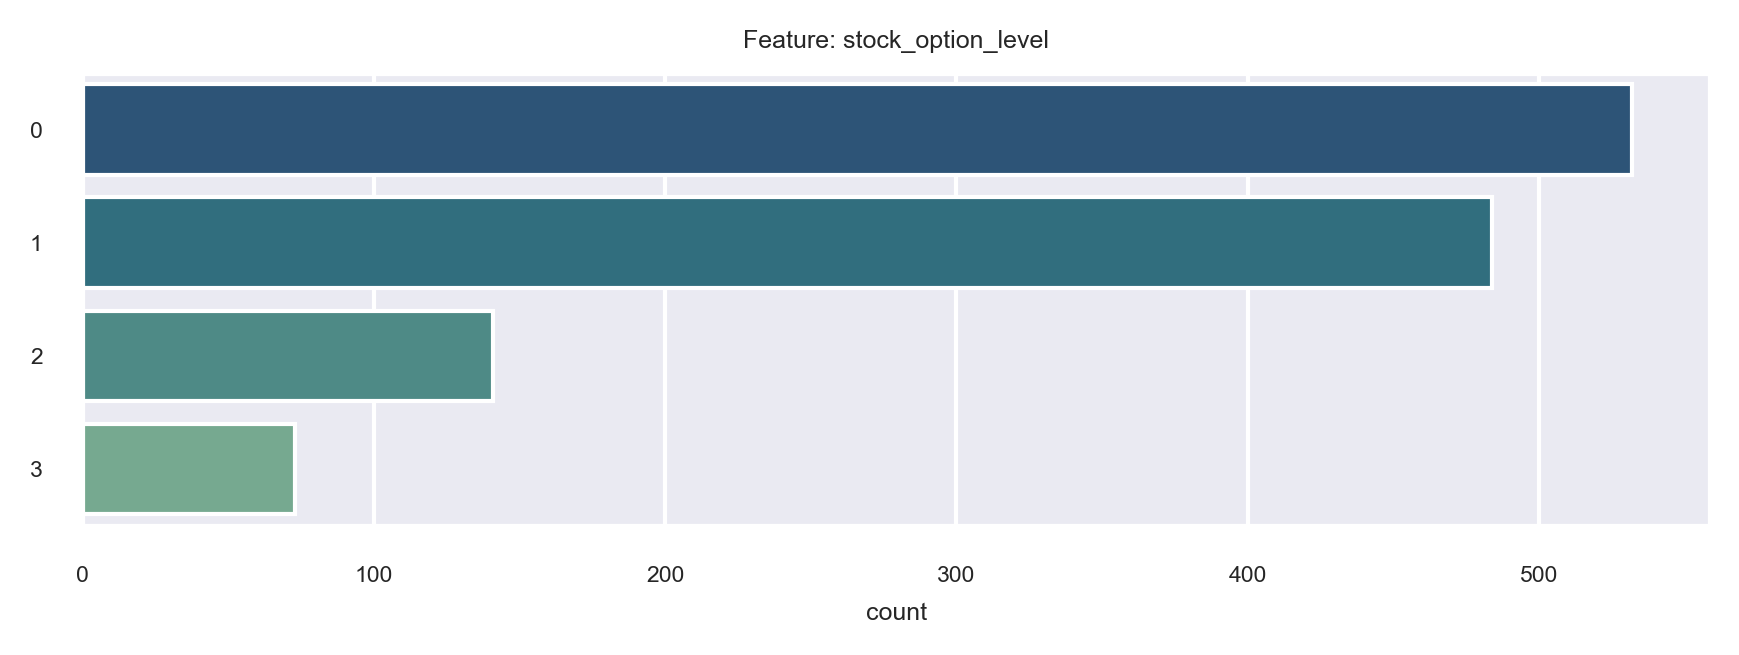

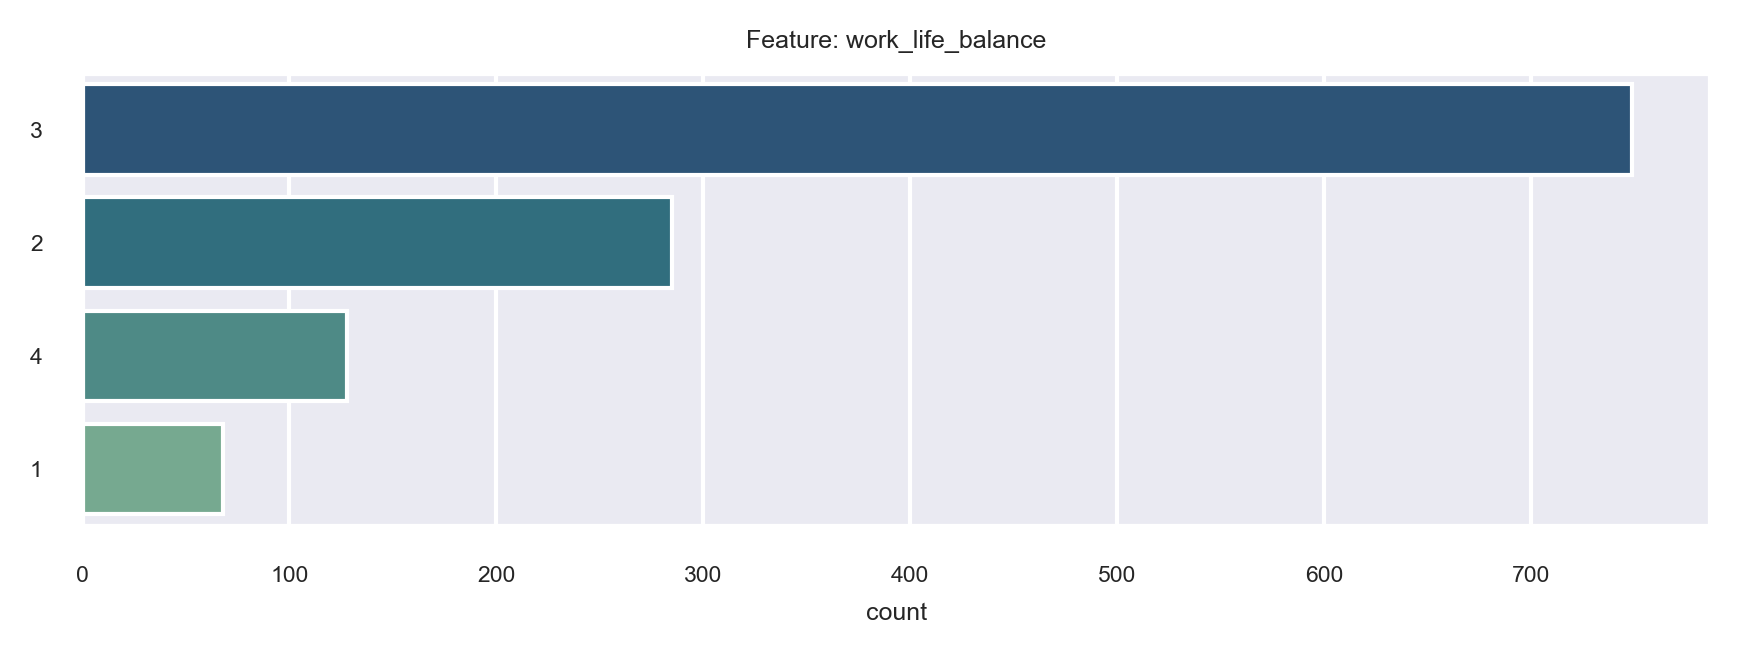

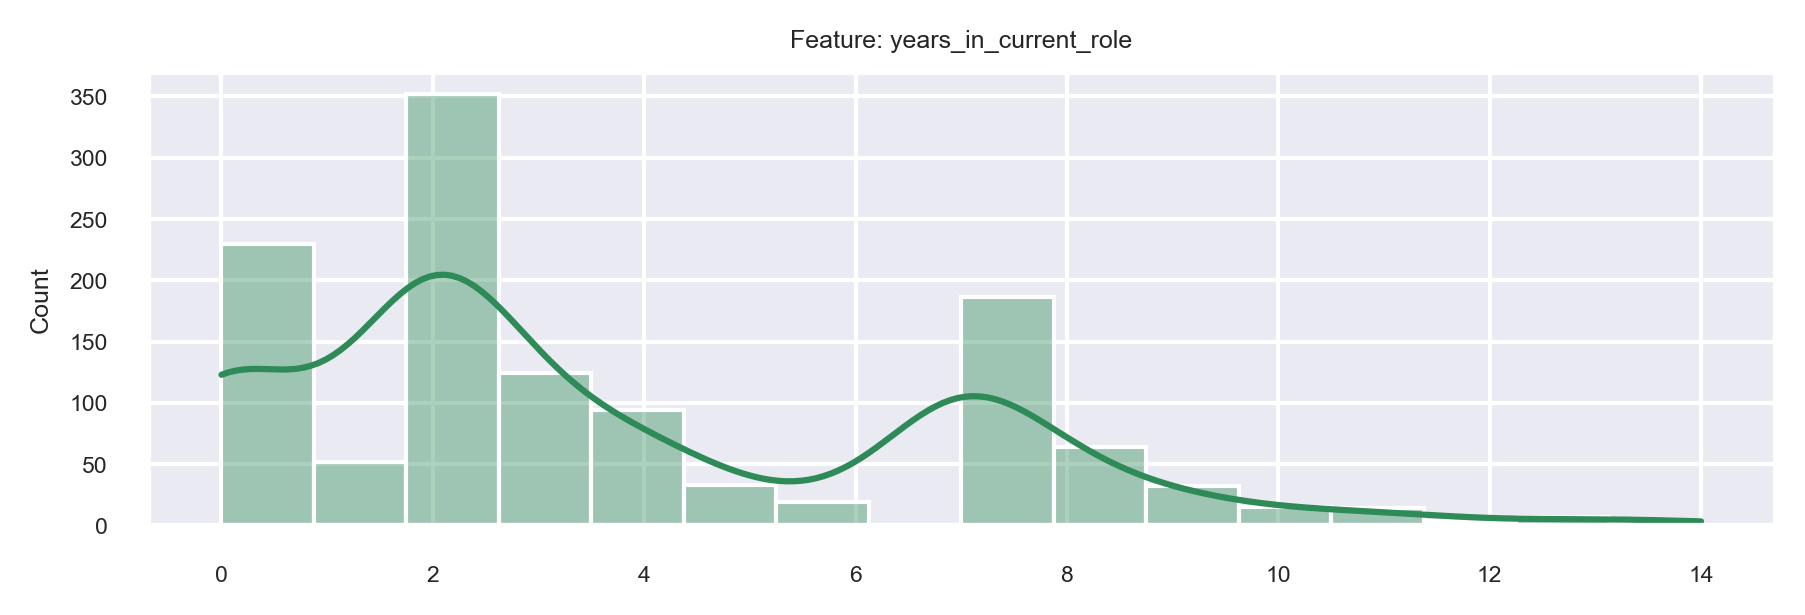

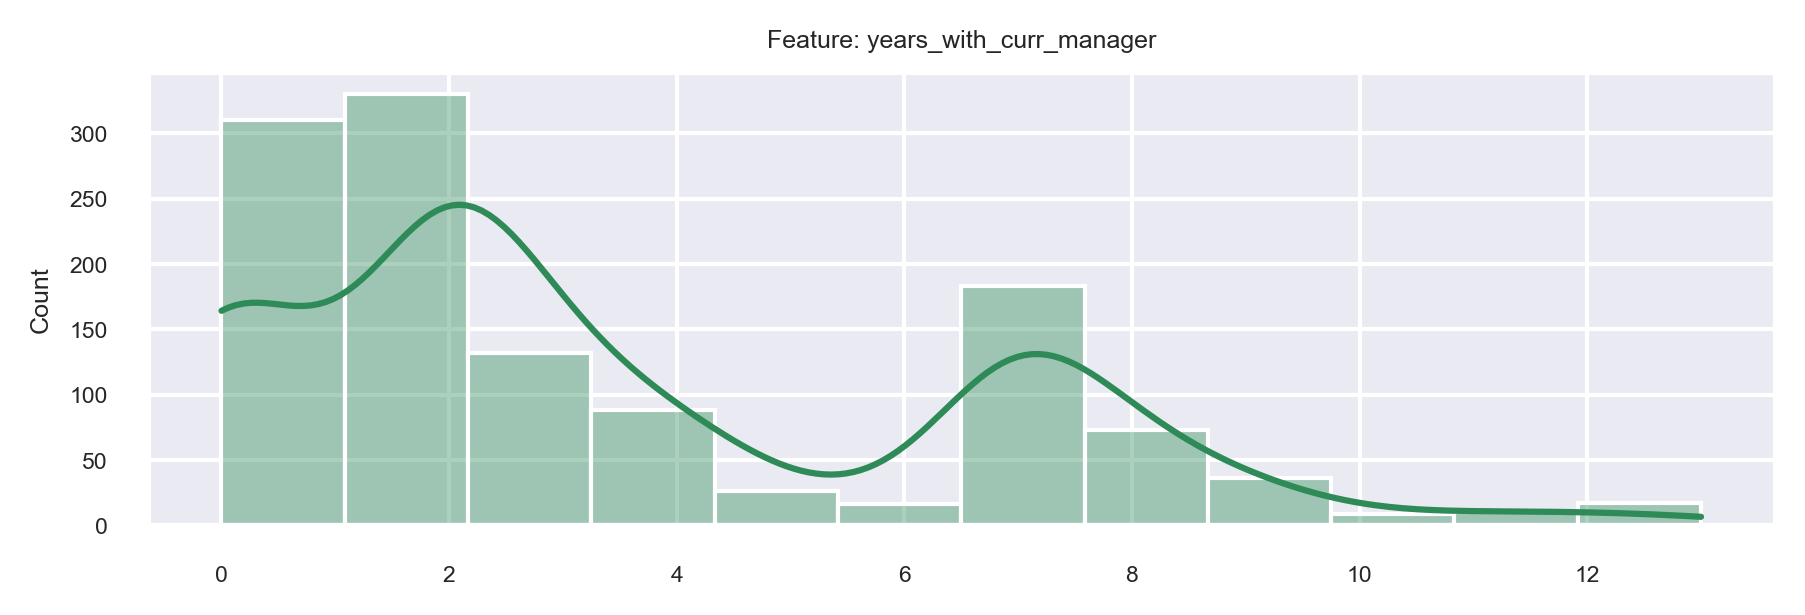

In [10]:
# visually examining the distribution of each feature/column 

prepare.plot_distribution(df)

In [11]:
# classifiying/viewing features by data type: discrete/categorical or continuous 

disc_lst = df.select_dtypes(exclude = "number").columns.sort_values().tolist()
cont_lst = df.select_dtypes(include = "number").columns.sort_values().tolist()

print(f'Discrete/Categorical Variables:\n-----------------------------------\n{disc_lst}')
print()
print(f'Continuous Variables:\n-----------------------------------\n{cont_lst}')

Discrete/Categorical Variables:
-----------------------------------
['attrition', 'county_name', 'department', 'education', 'education_field', 'environment_satisfaction', 'gender', 'job_involvement', 'job_level', 'job_role', 'job_satisfaction', 'marital_status', 'performance_rating', 'relationship_satisfaction', 'state', 'stock_option_level', 'work_life_balance']

Continuous Variables:
-----------------------------------
['employee_age', 'employment_rates_at_35yrs', 'high_school_graduation_rate', 'household_income_at_35', 'incarceration_rate', 'monthly_income', 'percent_salary_hike', 'percentage_married_by_35', 'poverty_rate', 'single_parent_frac', 'total_working_years', 'training_times_last_year', 'women_teenage_birthrate', 'years_at_company', 'years_in_current_role', 'years_since_last_promotion', 'years_with_curr_manager']


----
### **``Data Preparation: First Split of Original Dataset``**

**<u>Highlights:</u>**
 
- Stratified on: "Attrition" for equal distribution of target variable in each dataset
- Data splits : 56% Train | 24% Validate | 20% Test

In [12]:
# calling a created function to split the dataframe 

train, validate, test = prepare.train_validate_test_split(df)

train shape: (688, 34)
validate shape: (296, 34)
test shape: (246, 34)


In [13]:
# checking the percentage of the target variable in ea. dataset

print(f'target percentage in train: {round(len(train[train["attrition"] == True])/train.shape[0], 3)}')
print(f'target percentage in validate: {round(len(validate[validate["attrition"] == True])/validate.shape[0], 3)}')
print(f'target percentage in test: {round(len(test[test["attrition"] == True])/test.shape[0], 3)}')

target percentage in train: 0.177
target percentage in validate: 0.176
target percentage in test: 0.175


#### ``Baseline Accuracy (mode outcome): Employee Attrition``

In [14]:
# setting an attrition baseline using a mode method for ea. dataset
# for the baseline accuracy, I have taken the mode of the two (2) binary "attrition" options = False and have set this as the baseline prediction
# baseline accuracy score: the total number of times that the baseline prediction matched the actual employee attrition outcome
# baseline accuracy score: ~82.0% **(note that if the goal is to predict attrition = 1, then baseline accuracy is ~18%)
    
train_baseline = train
train_baseline["baseline_prediction"] = False
baseline_train = (train_baseline["baseline_prediction"] == train_baseline["attrition"]).mean().round(3)
print(f'Training Baseline Accuracy: % {(baseline_train * 100).round(5)}')

print('-------------------------------------------')

validate_baseline = validate
validate_baseline["baseline_prediction"] = False
baseline_val = (validate_baseline["baseline_prediction"] == validate_baseline["attrition"]).mean().round(3)
print(f'Validate Baseline Accuracy: % {(baseline_val * 100).round(5)}')

Training Baseline Accuracy: % 82.3
-------------------------------------------
Validate Baseline Accuracy: % 82.4


-----

### **``Exploration: Hypothesis Testing``**


**``Variables intentionally not taken into exploration:``**

1. 'business_travel'
2. 'cty'
3. 'daily_rate'
4. 'distance_from_home'
5. 'hourly_rate'
6. 'monthly_rate'
7. 'num_companies_worked'
8. 'over_time'


**``Continuous Variables:``**

1. 'employee_age'
2. 'employment_rates_at_35yrs'
3. 'high_school_graduation_rate'
4. 'household_income_at_35'
5. 'incarceration_rate'
6. 'monthly_income'
7. 'percent_salary_hike'
8. 'percentage_married_by_35'
9. 'poverty_rate'
10. 'single_parent_frac'
11. 'total_working_years'
12. 'training_times_last_year'
13. 'women_teenage_birthrate'
14. 'years_at_company'
15. 'years_since_last_promotion'
16. 'years_in_current_role'
17. 'years_with_curr_manager'

**``Discrete Variables:``**

1. 'attrition'
2. 'county_name'
3. 'department'
4. 'education'
5. 'education_field'
6. 'environment_satisfaction'
7. 'gender'
8. 'job_involvement'
9. 'job_level'
10. 'job_role'
11. 'job_satisfaction'
12. 'marital_status'
13. 'performance_rating'
14. 'relationship_satisfaction'
15. 'standard_hours'
16. 'state'
17. 'stock_option_level'
18. 'work_life_balance'


In [15]:
# setting continuous variables list for testing

cont_lst = sorted([
'employee_age',
'monthly_income',
'percent_salary_hike',
'total_working_years',
'training_times_last_year',
'years_at_company',
'household_income_at_35',
'high_school_graduation_rate',
'percentage_married_by_35',
'incarceration_rate',
'women_teenage_birthrate',
'poverty_rate',
'employment_rates_at_35yrs',
'single_parent_frac',
'years_since_last_promotion',
'years_in_current_role',
'years_with_curr_manager',
])

In [16]:
# setting discrete/categorical variables list for testing

disc_lst = sorted([
'stock_option_level',
'work_life_balance',
'education',
'job_involvement',
'job_level',
'job_satisfaction',
'performance_rating',
'relationship_satisfaction',
'county_name',
'state',
'department',
'education_field',
'gender',
'job_role',
'marital_status',
'environment_satisfaction'
])

In [17]:
# 2nd split: splitting larger datasets into x and y variables

X_train = train.drop(columns = "attrition")
y_train = train['attrition']

X_validate = validate.drop(columns = "attrition")
y_validate = validate['attrition']

X_test = test.drop(columns = "attrition")
y_test = test['attrition']

In [18]:
# checking the target variable
# note: the model will also read boolean type (F/T) as either (0/1)
# False (with the company):         566 employees
# True (has left the company):      122 employees

y_train.value_counts()

False    566
True     122
Name: attrition, dtype: int64

----
### ``Hypothesis Tests: Continuous Variables``

**<u>``1-sample | 2 Tail T-test``</u>**


$H_0$ (Null Hypothesis): The variable mean of turn over employees is not statistically different than the population variable mean.

$H_a$ (Alternate Hypothesis): The variable mean for turn over employees is statistically different than the population variable mean.

* $alpha$: 1.0 - Confidence Interval (95% confidence level)
* $\alpha$ = 0.05

In [19]:
# setting an alpha value

alpha = 0.05

In [20]:
# setting a list of social-mobility metrics

social_lst = [col for col in train.columns if 'rate' in col or 'household' in col or 'by' in col or 'employee' in col]

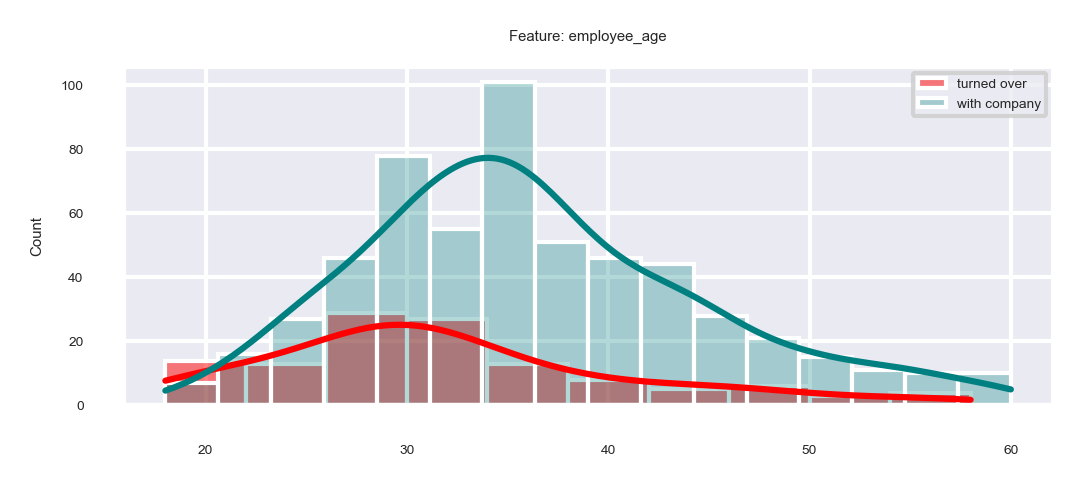

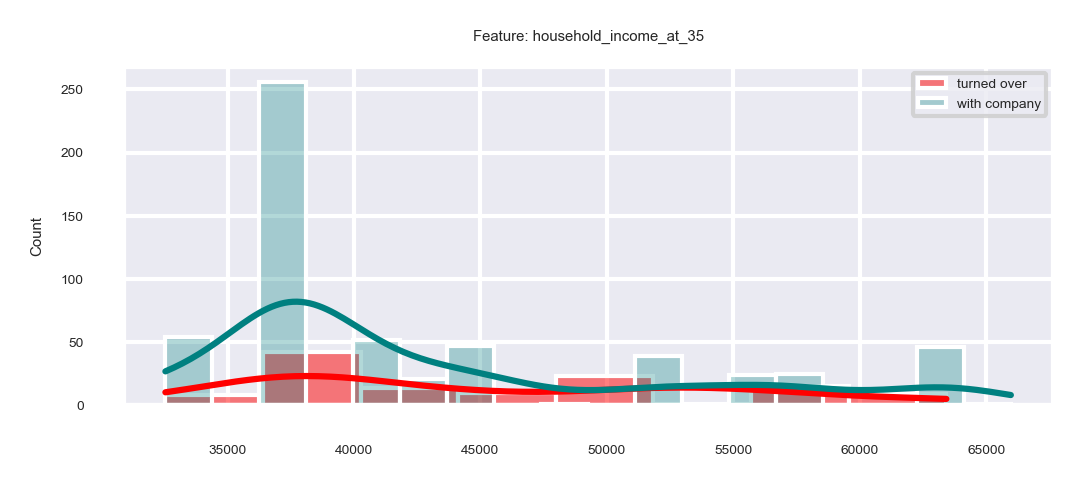

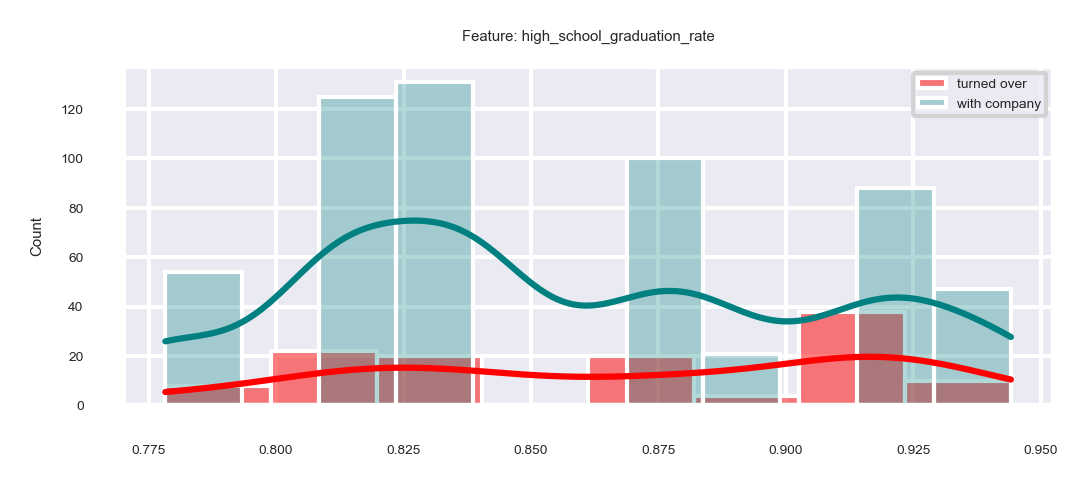

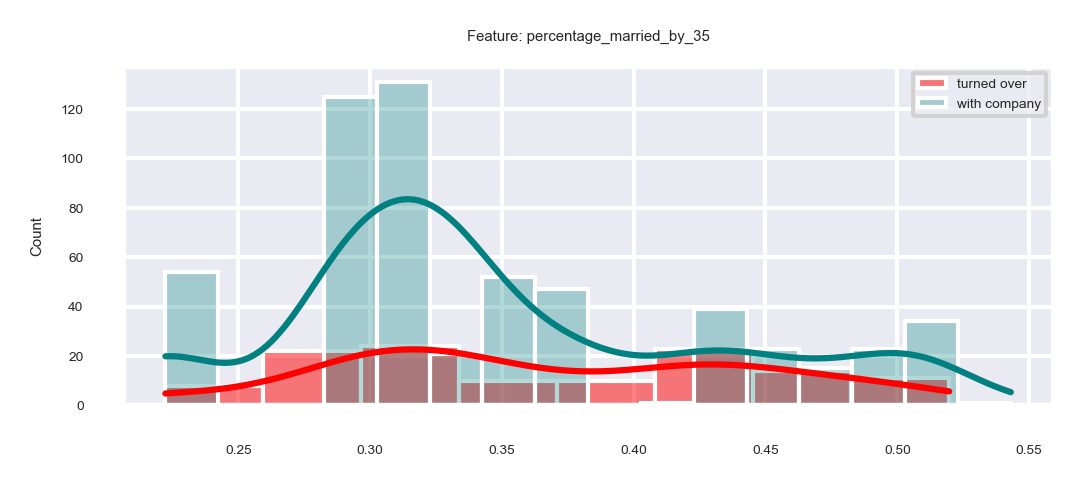

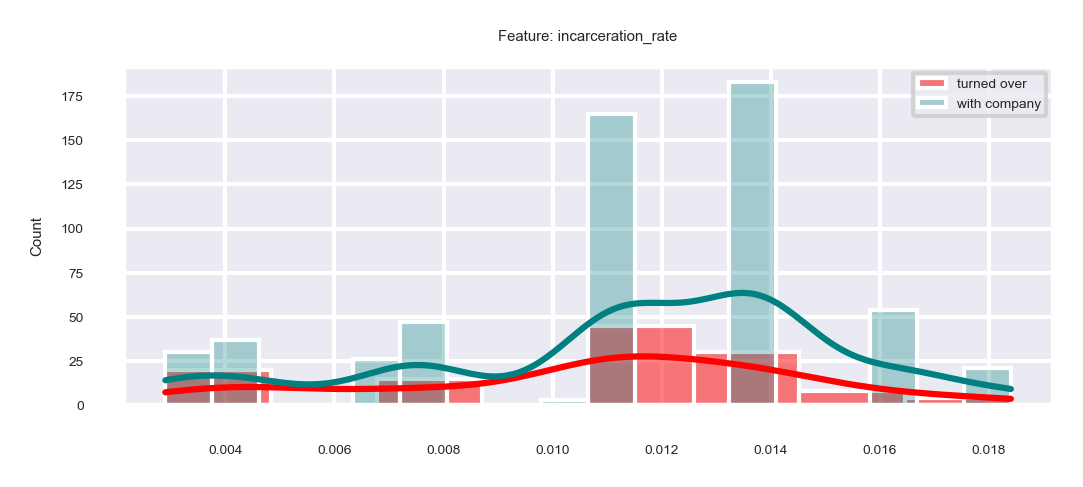

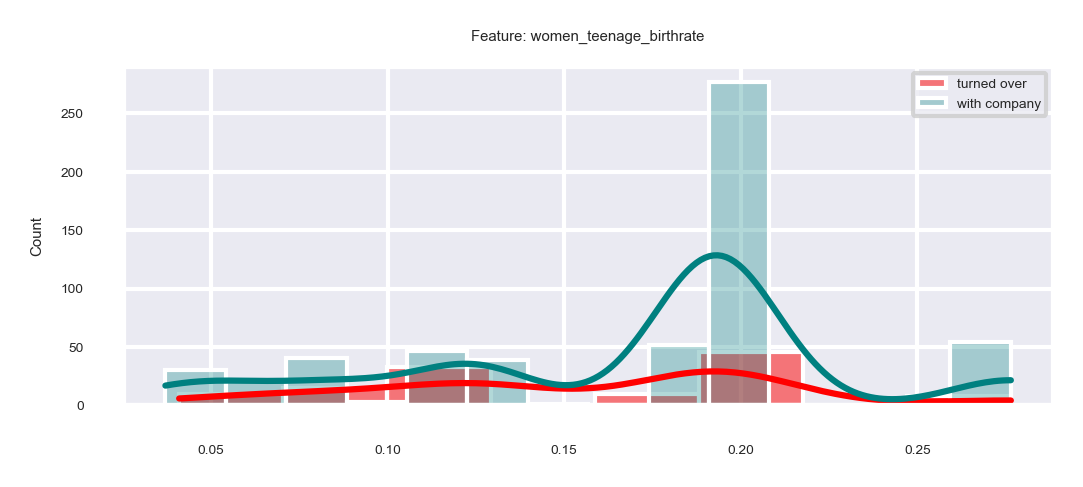

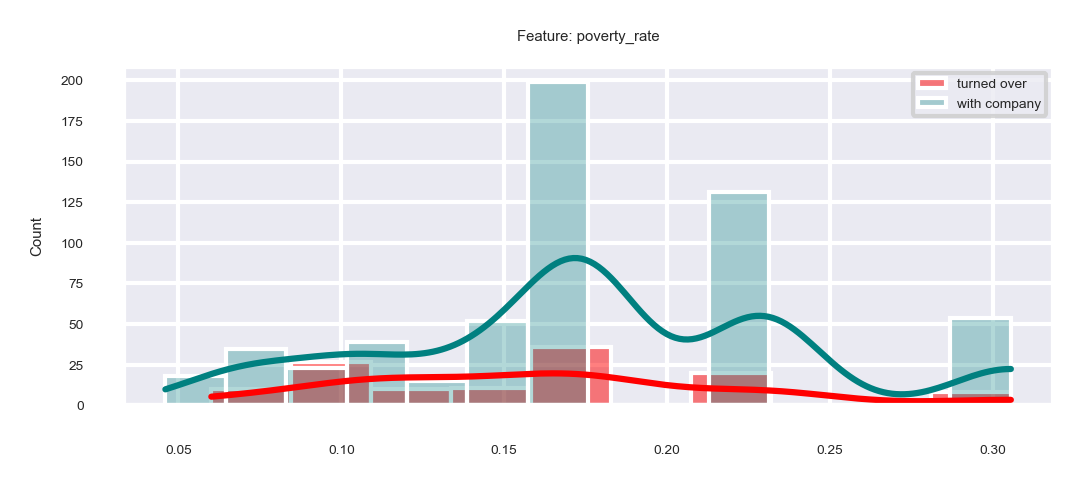

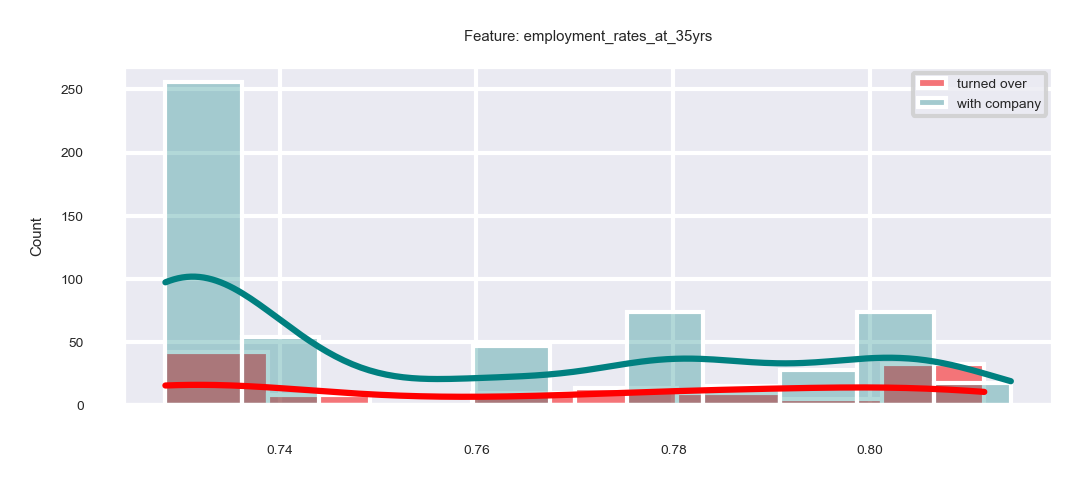

In [21]:
# distribution plot of employee equity / demographic variables

for col in social_lst:
    plt.figure(figsize= (4, 1.5))
    sns.set(font_scale = 0.3, style="darkgrid")

    sns.histplot(train[train["attrition"] == True][col], color="red", alpha = 0.5, label="turned over", kde=True)
    sns.histplot(train[train["attrition"] == False][col], color="teal", alpha = 0.3, label="with company", kde=True)


    plt.title(f'Feature: {col}')
    plt.xlabel(None)
    plt.legend() 
    plt.show()

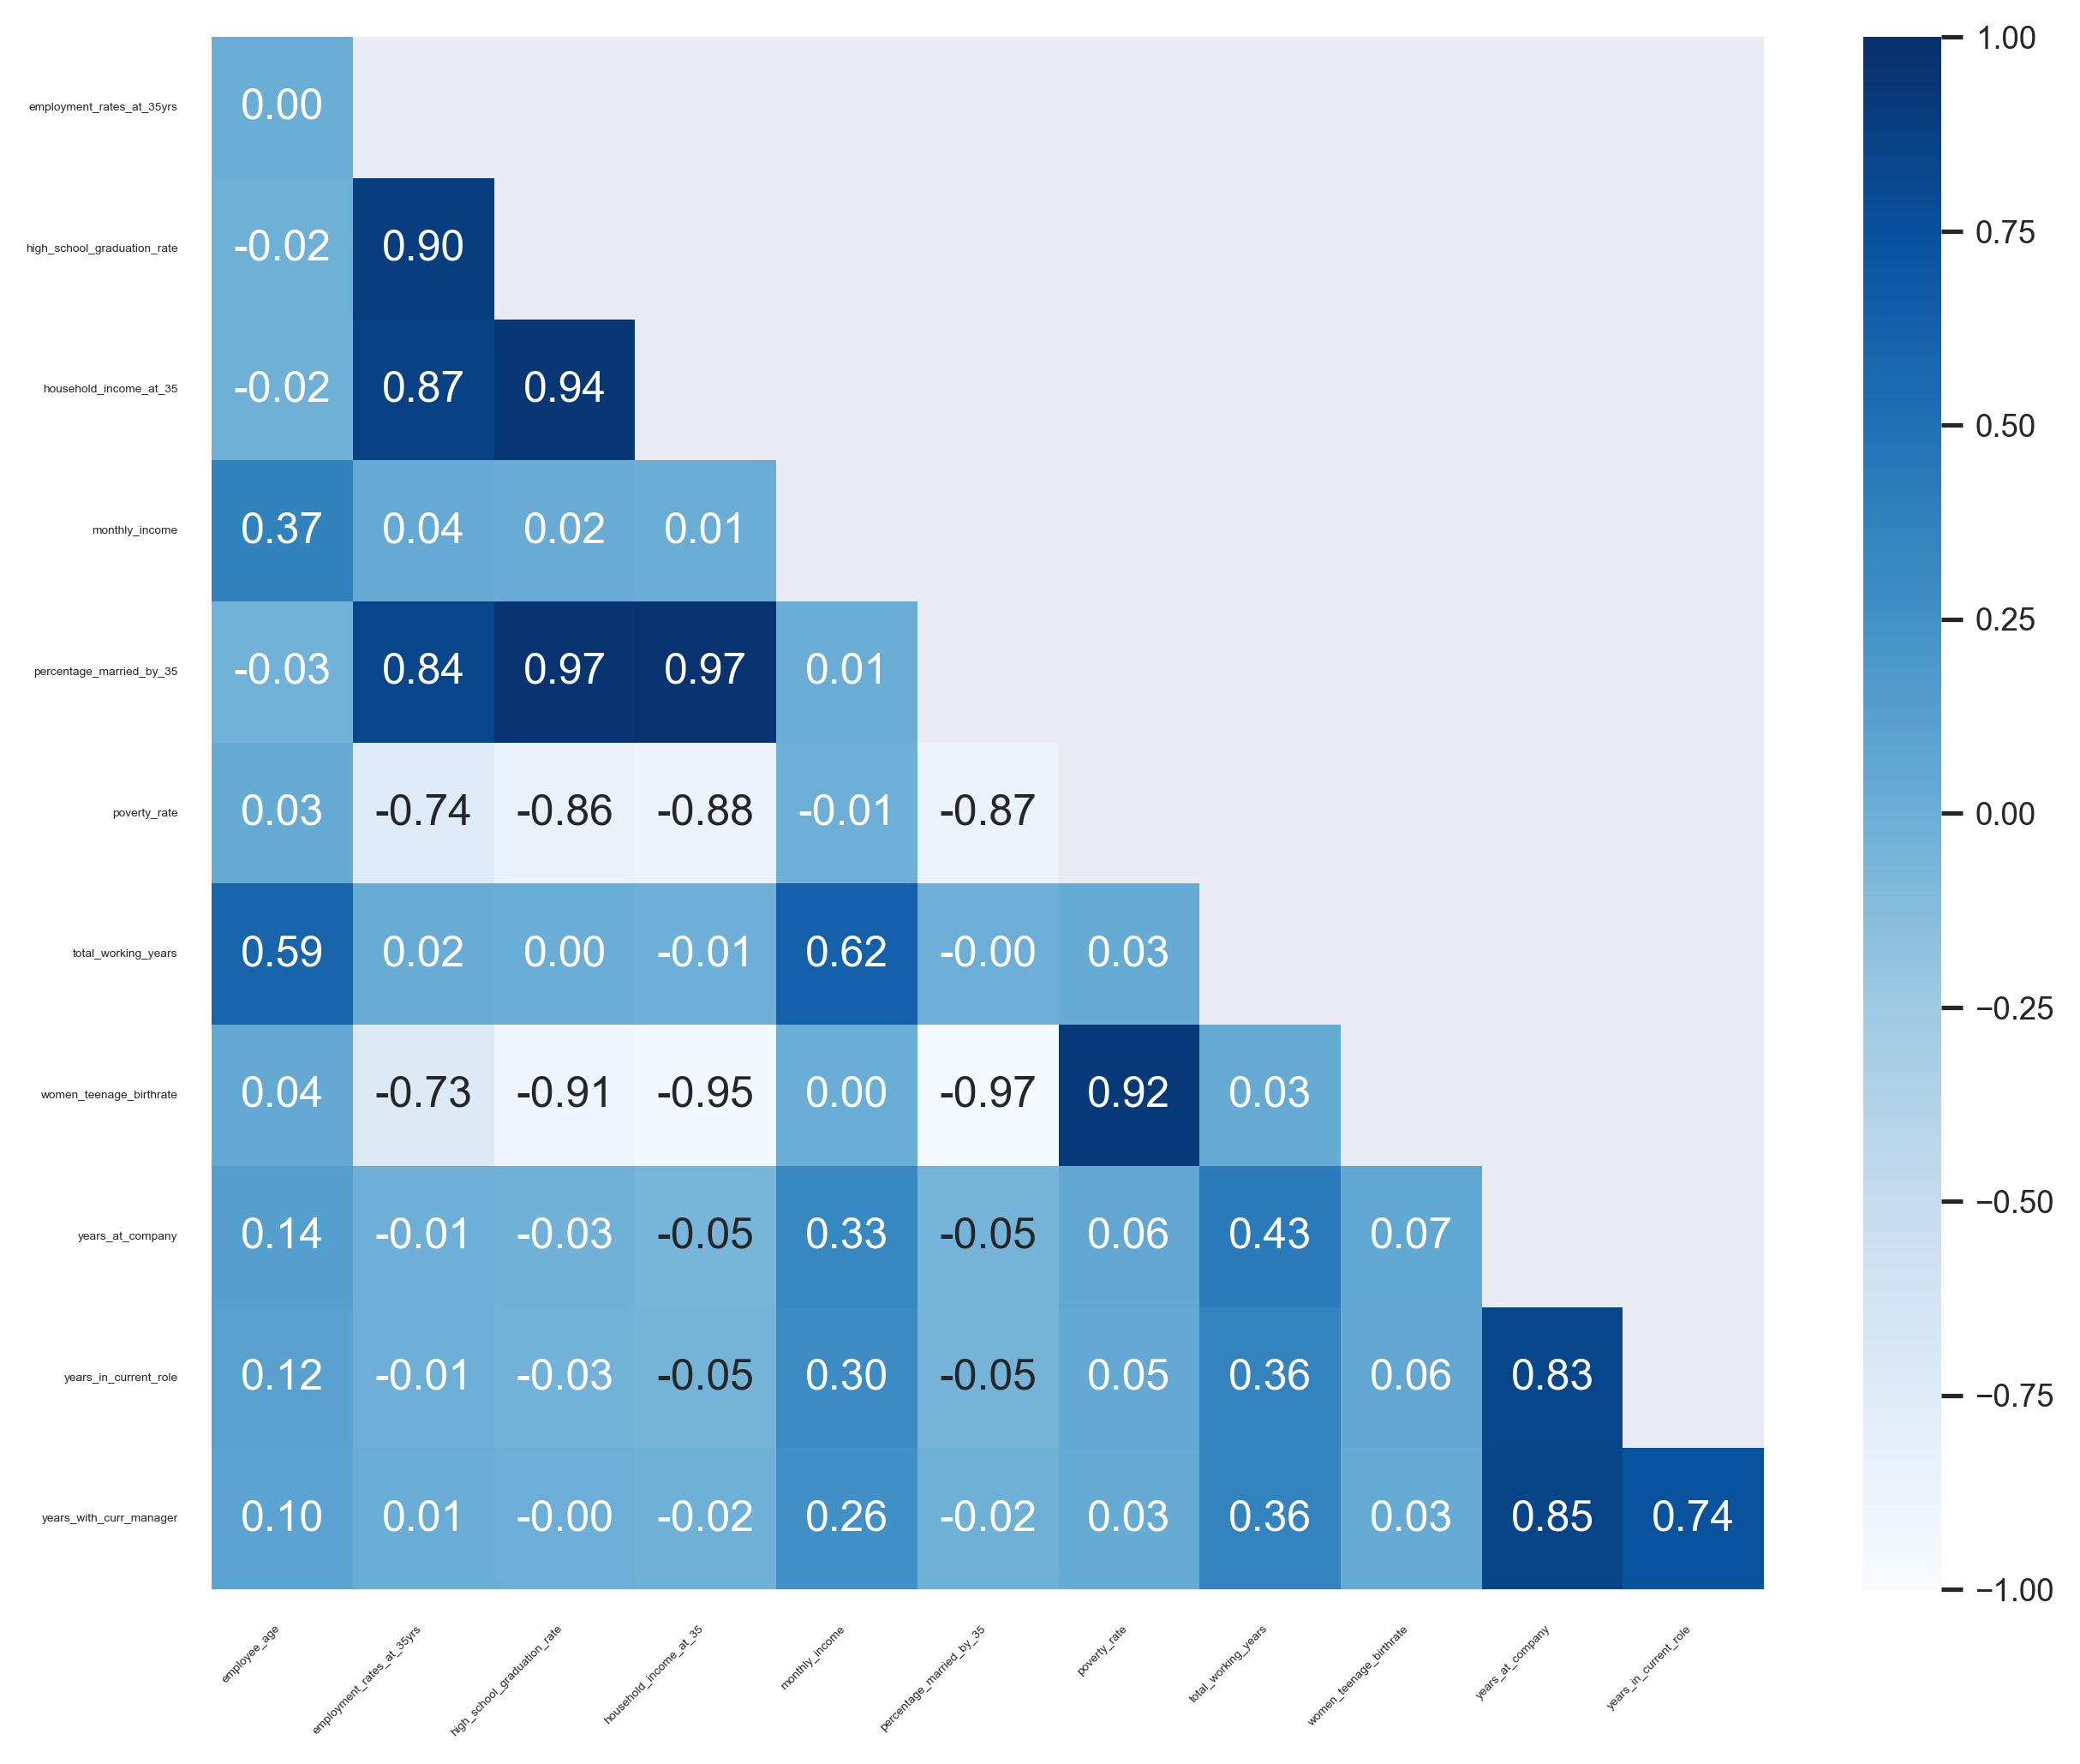

In [22]:
# viewing potential correlation amongst continuous variables

# taking needed variables sample
corr_df = train[[ 
    'employee_age',
    'employment_rates_at_35yrs',
    'high_school_graduation_rate',
    'household_income_at_35',
    'monthly_income',
    'percentage_married_by_35',
    'poverty_rate',
    'total_working_years',
    'women_teenage_birthrate',
    'years_at_company',
    'years_in_current_role',
    'years_with_curr_manager']].reset_index(drop = True)

# returning correlation coefficient 
corr_array = corr_df.corr()

# creating the object and axes
fig, ax = plt.subplots(figsize=(10, 8))
sns.set(font_scale = 0.8, style = "white")

# mask
mask = np.triu(np.ones_like(corr_array, dtype=np.bool))

# adjust mask and df
mask = mask[1:, :-1]
corr = corr_array.iloc[1:,:-1].copy()

g = sns.heatmap(
    corr, 
    mask=mask,
    cmap = "Blues",
    vmin = -1, 
    vmax = 1, 
    annot = True,
    annot_kws={
        'fontsize': 12
    },
    fmt =".2f",
    linewidths = 0,
    square = True)

g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

In [23]:
# continuous variables and evaluating statistical signifance in sample mean vs. population mean

metrics = []

for col in cont_lst:
    pop_mean = train[col].mean()
    sample_col = train[train["attrition"] == True][col]

    t_score, p_value = stats.ttest_1samp(sample_col, pop_mean)

    if p_value < alpha:
        output = {
            "continuous_feature": col,
            "t_score": t_score,
            "p_value": p_value}
        
        metrics.append(output)

    else:
        print(f'Column: {col} is not statistically significant.')
        print("------------------------------------------------------------")

onesample_t_test_scores = pd.DataFrame(metrics)
onesample_t_test_scores.round(4)

Column: incarceration_rate is not statistically significant.
------------------------------------------------------------
Column: percent_salary_hike is not statistically significant.
------------------------------------------------------------
Column: single_parent_frac is not statistically significant.
------------------------------------------------------------
Column: training_times_last_year is not statistically significant.
------------------------------------------------------------
Column: years_since_last_promotion is not statistically significant.
------------------------------------------------------------


continuous_feature  t_score  p_value
0                  employee_age   -4.308    0.000
1     employment_rates_at_35yrs    2.720    0.007
2   high_school_graduation_rate    2.589    0.011
3        household_income_at_35    2.375    0.019
4                monthly_income   -4.642    0.000
5      percentage_married_by_35    2.368    0.019
6                  poverty_rate   -2.410    0.017
7           total_working_years   -5.676    0.000
8       women_teenage_birthrate   -2.124    0.036
9              years_at_company   -5.011    0.000
10        years_in_current_role   -4.312    0.000
11      years_with_curr_manager   -4.406    0.000

----

#### **``Summary: 1-sample T-test Results``**

After hypotheses testing of continuous variables' population mean - I conclude that the following features/variables hold a statistical correlation with employee attrition:

1. age
2. employment rates at 35yrs
3. high school graduation rate
4. household income at 35
5. monthly income
6. percentage married by 35
7. poverty rate
8. total working years
9. women teenage birthrate
10. years at company
11. years in current role
12. years with curr manager

**<u>Follow-up questions/thoughts after analysis:</u>**

There are several variables that I will want to further investigate against the population. For example, are variables such as county percentage of single parents or the total number of years since an employee's last promotion non-linear and therefore would warrant non-parametric/linear relationship testing which may be more suitable for measuring their relationship with attrition. 

----

### **``Hypothesis Tests: Categorical/Discrete Variables``**

**<u>``Chi_Squared Test``</u>**

$H_0$: "There is not a relationship between observed variable outcomes and expected employee turn over."

$H_a$: "There is a relationship between observed variable outcomes and expected employee turn over."

* $alpha$: 1 - Confidence Interval (95% confidence level)
* $\alpha$ = 0.05

In [24]:
# setting an alpha value 

alpha = 0.05

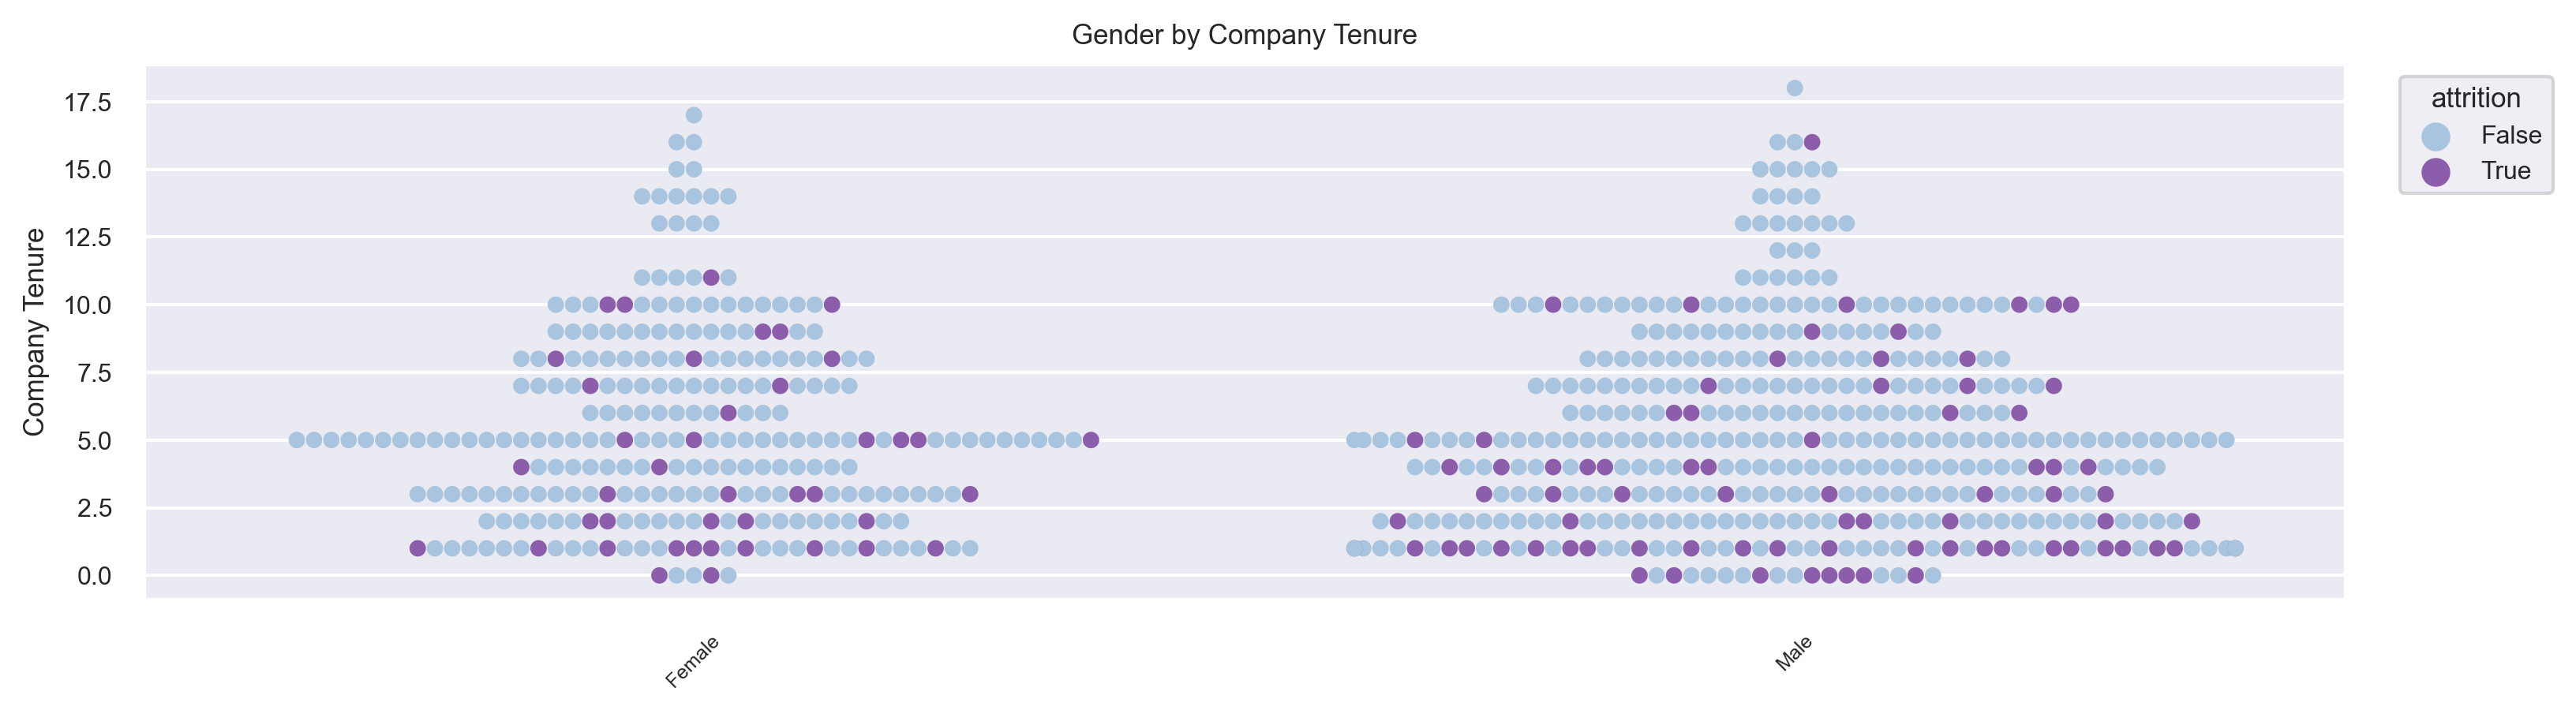

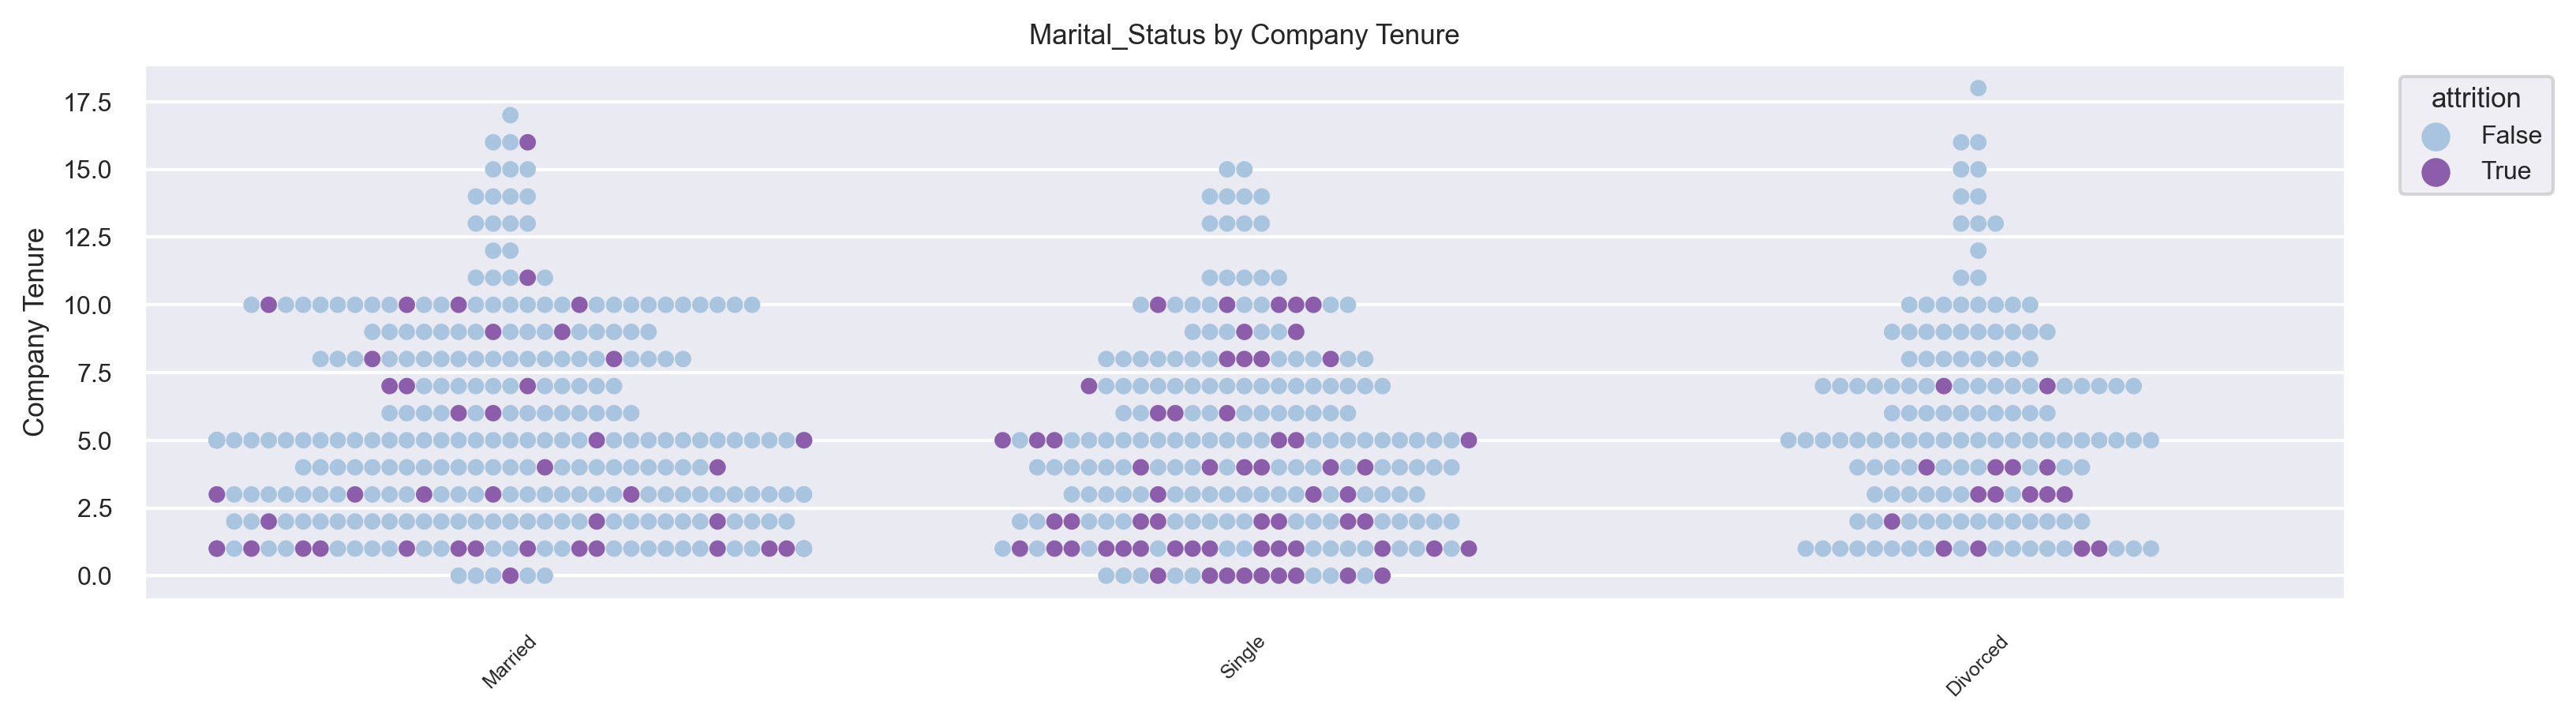

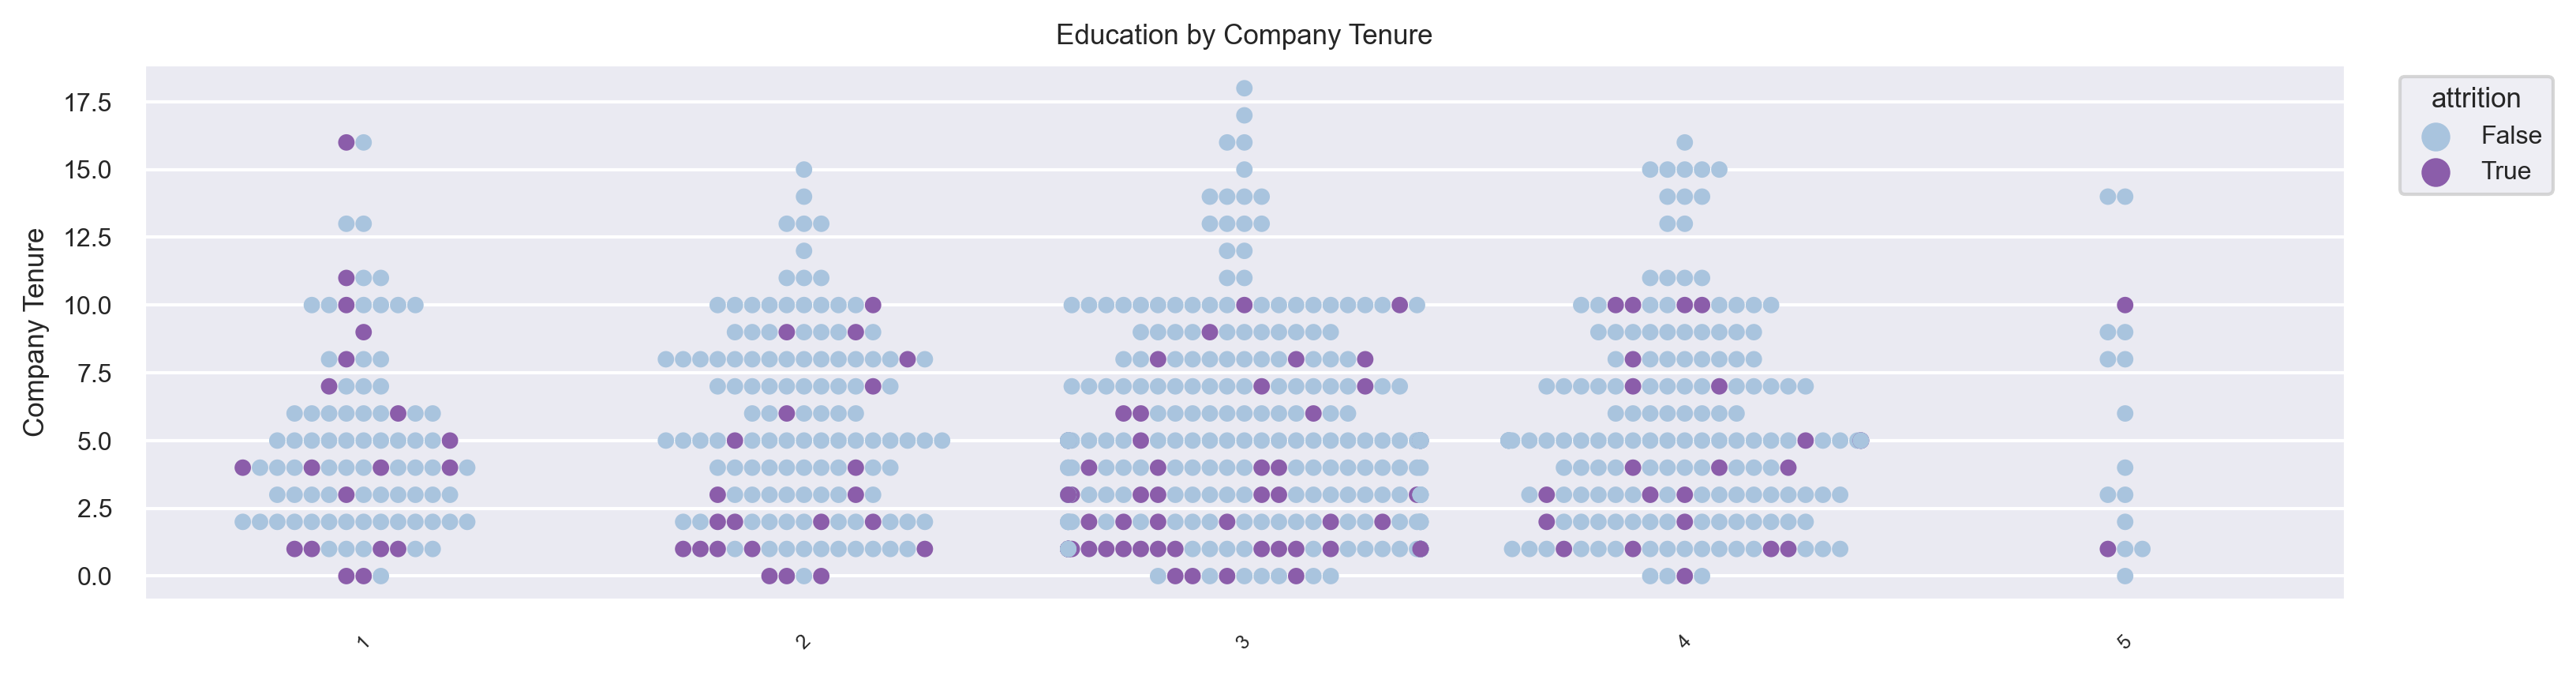

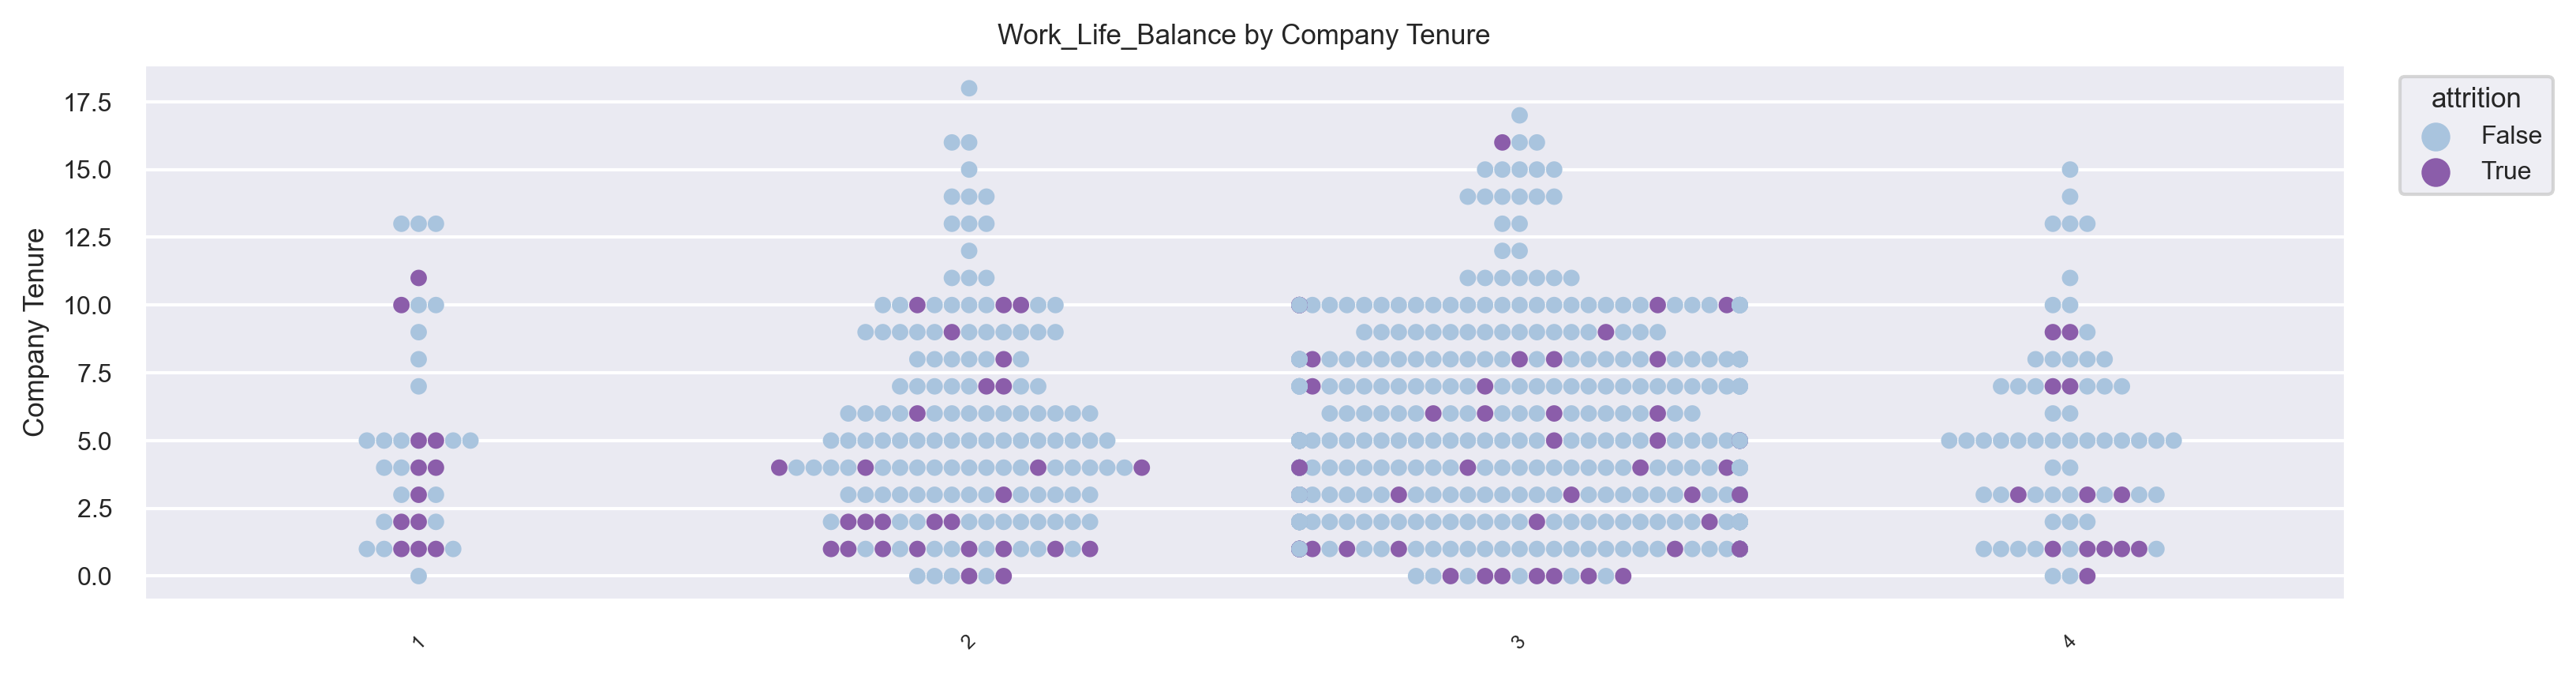

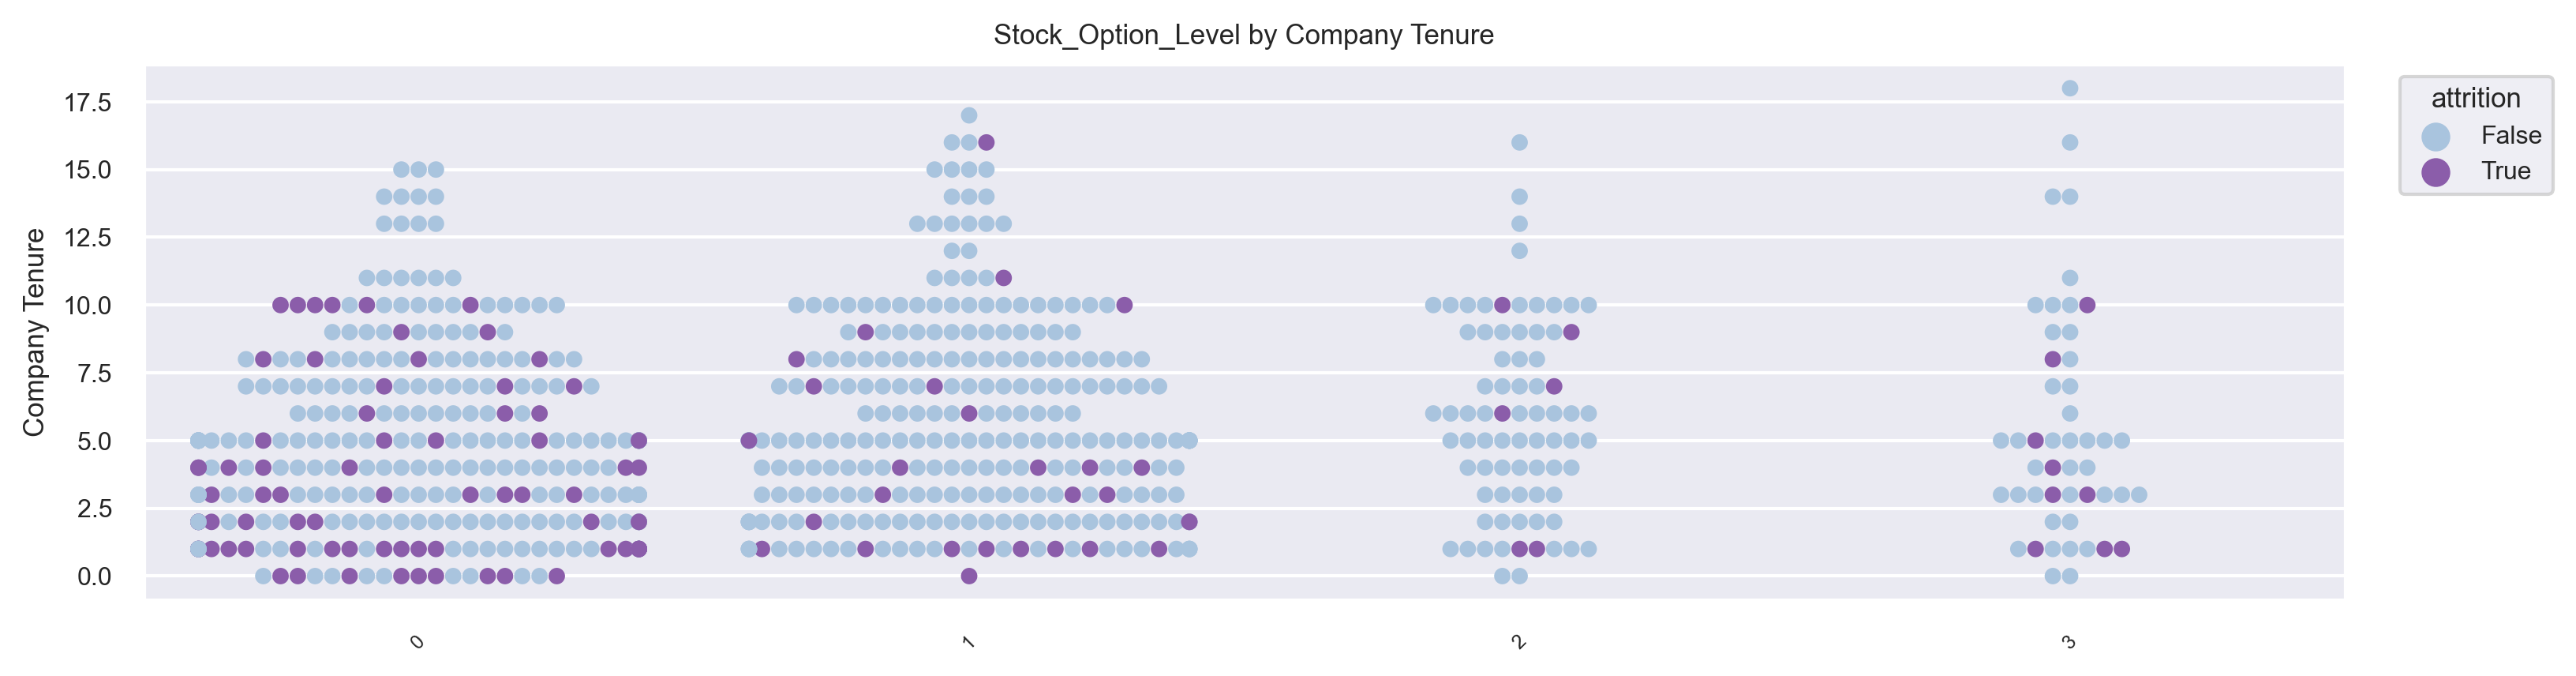

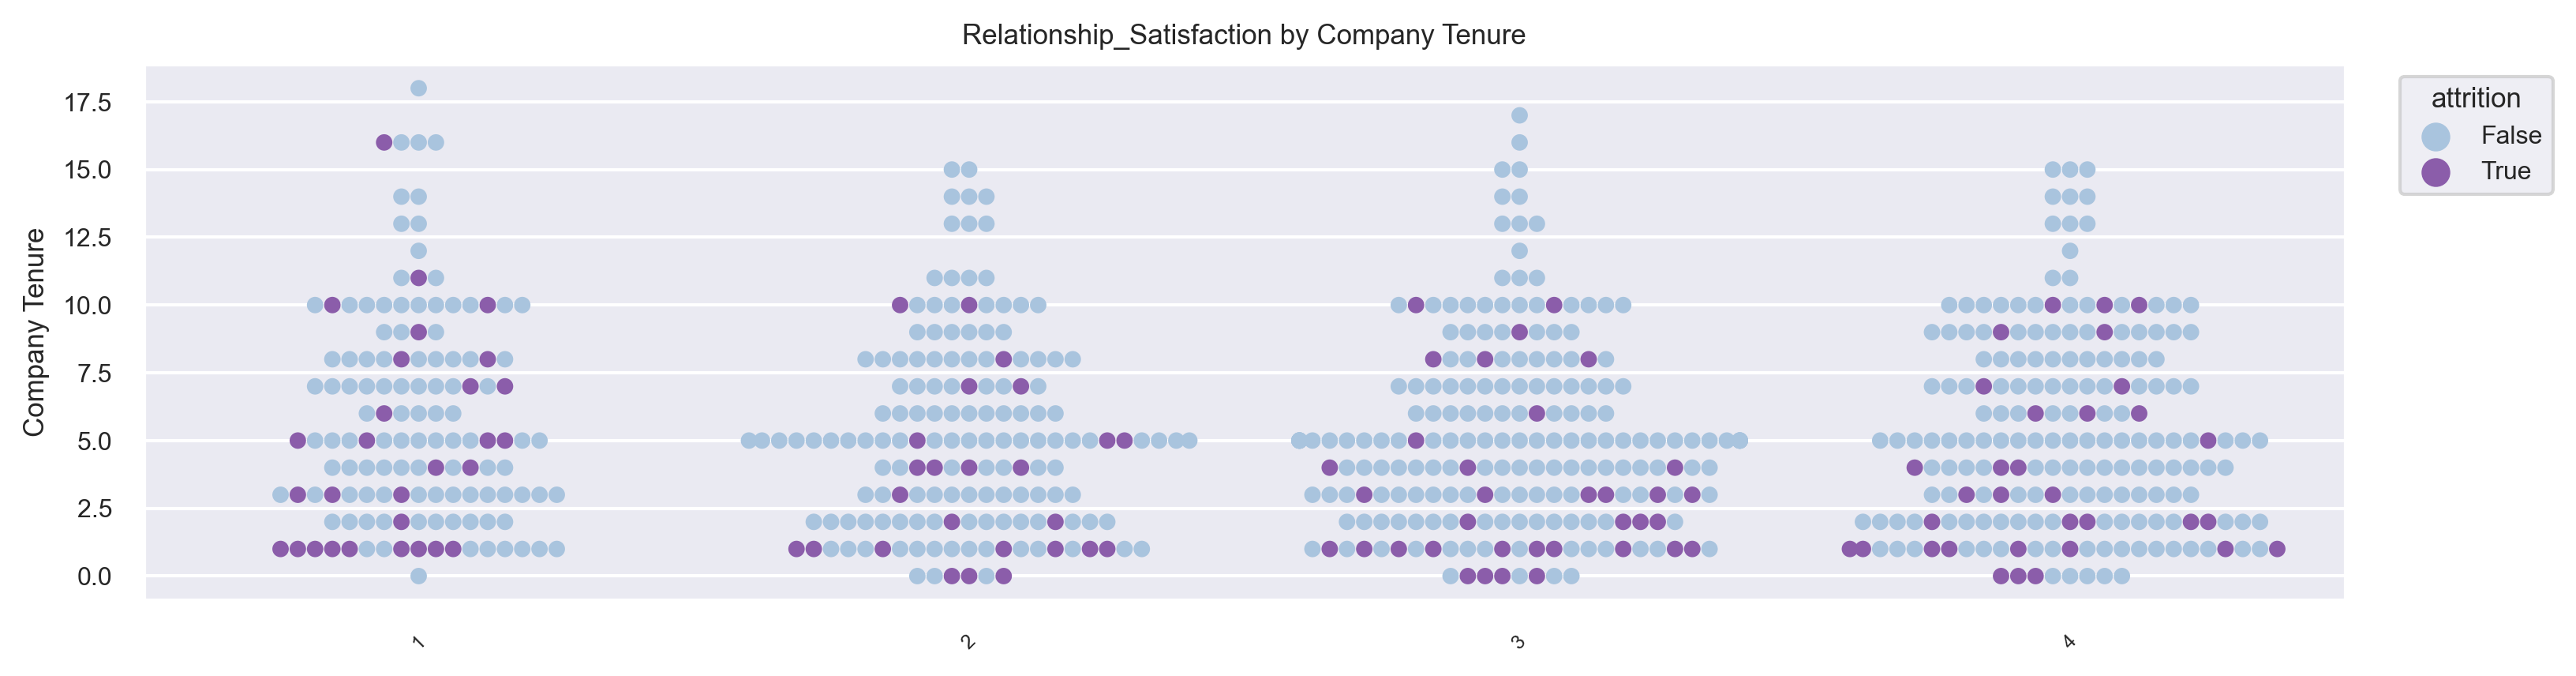

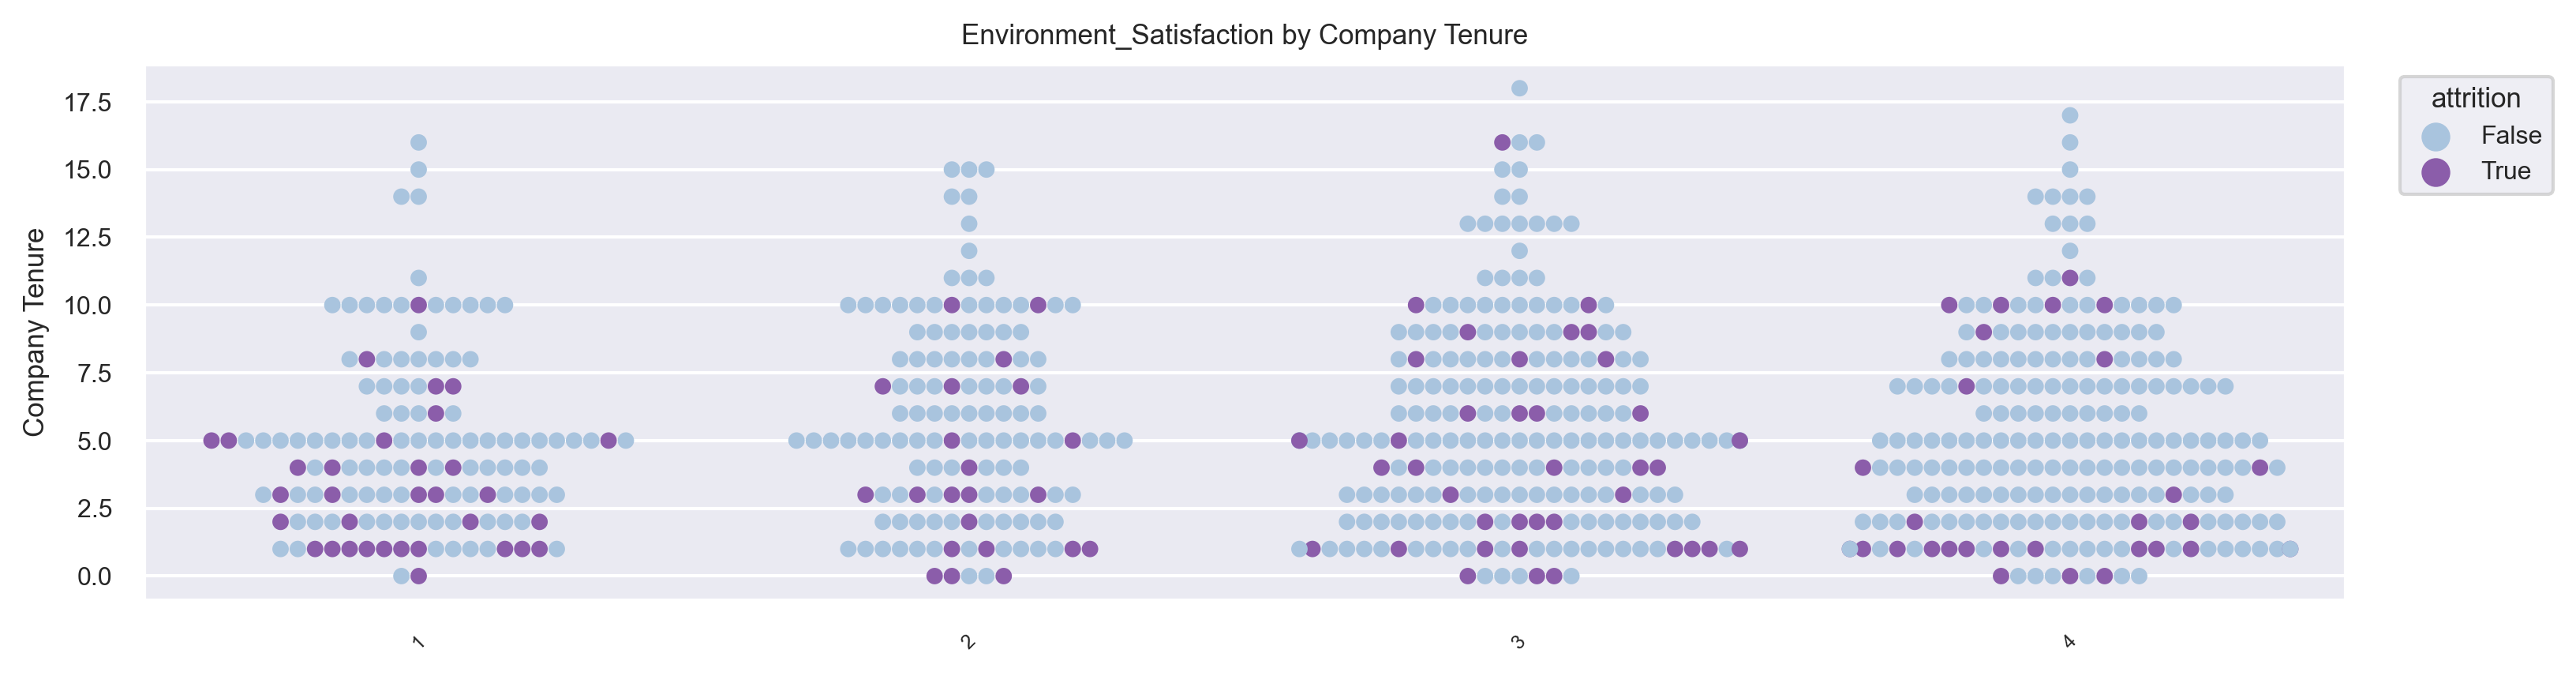

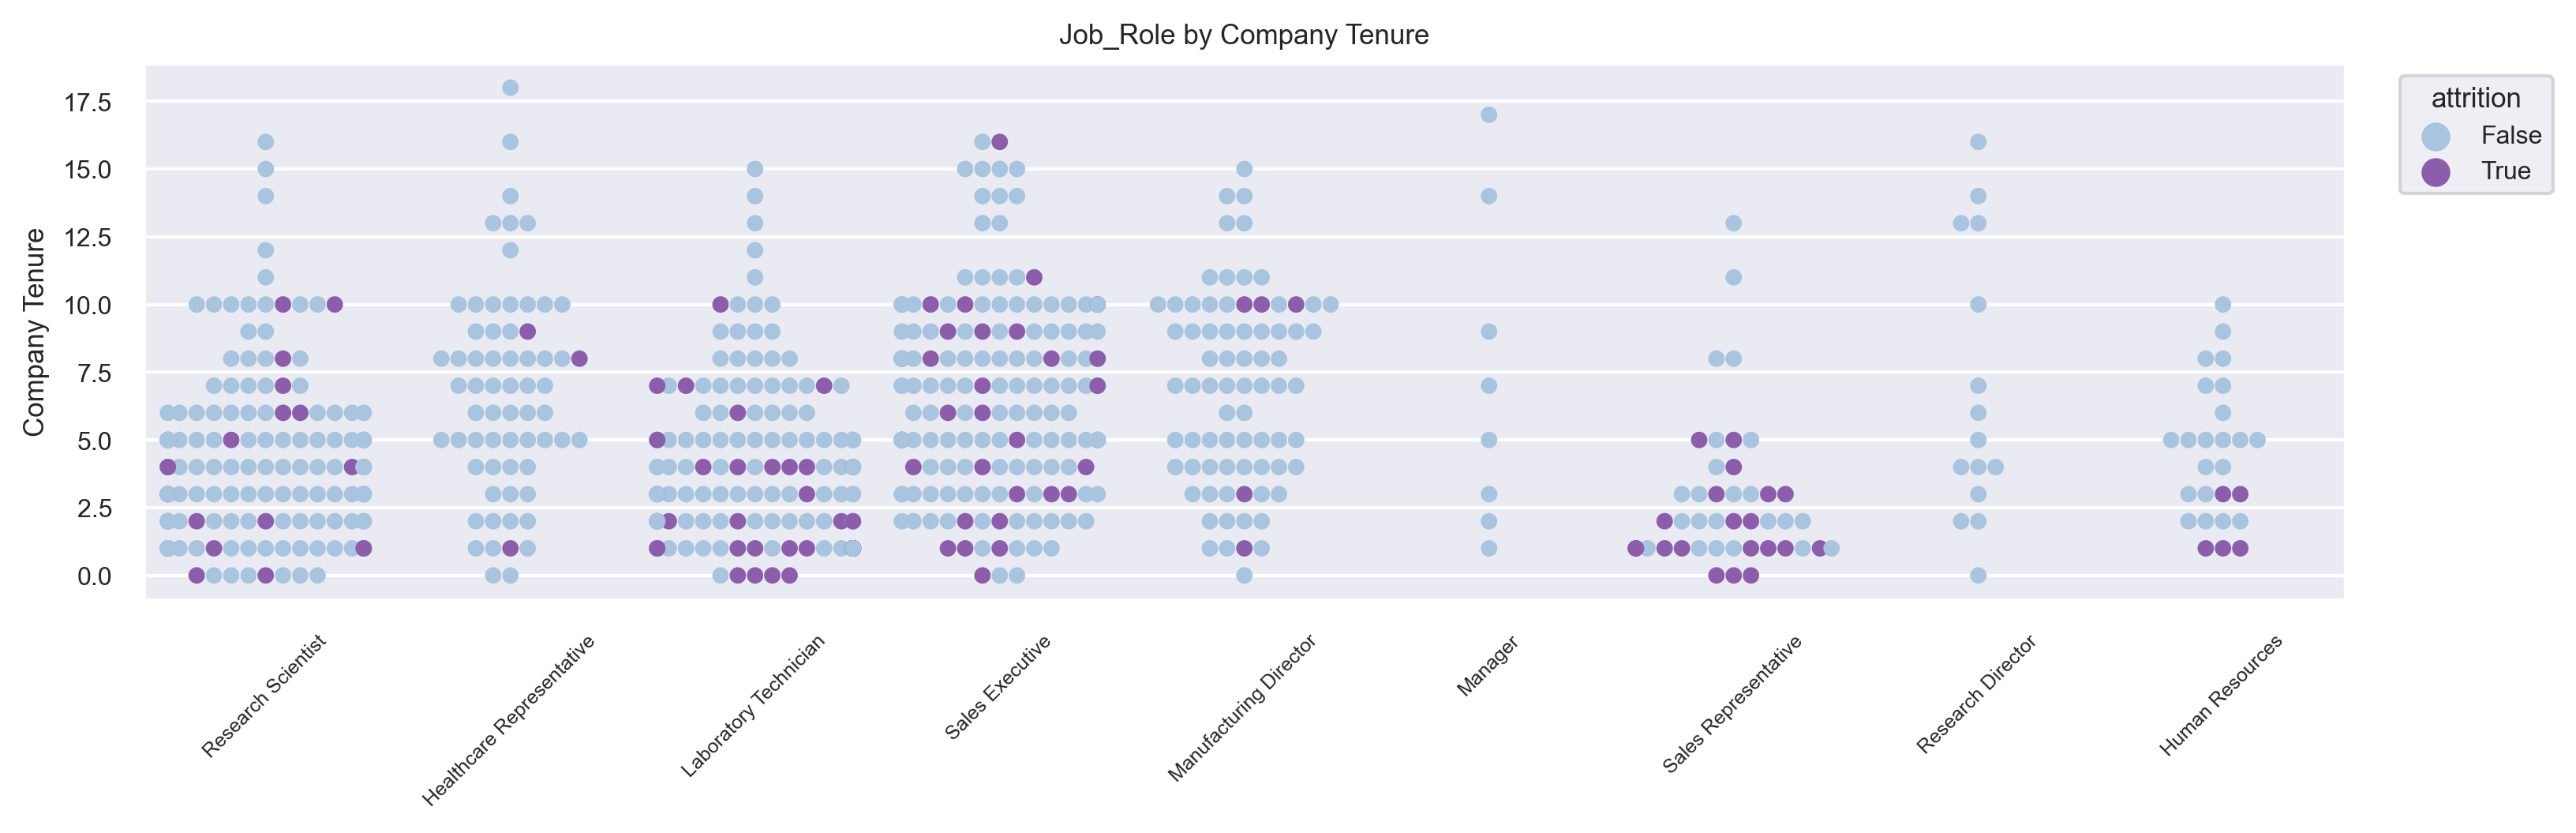

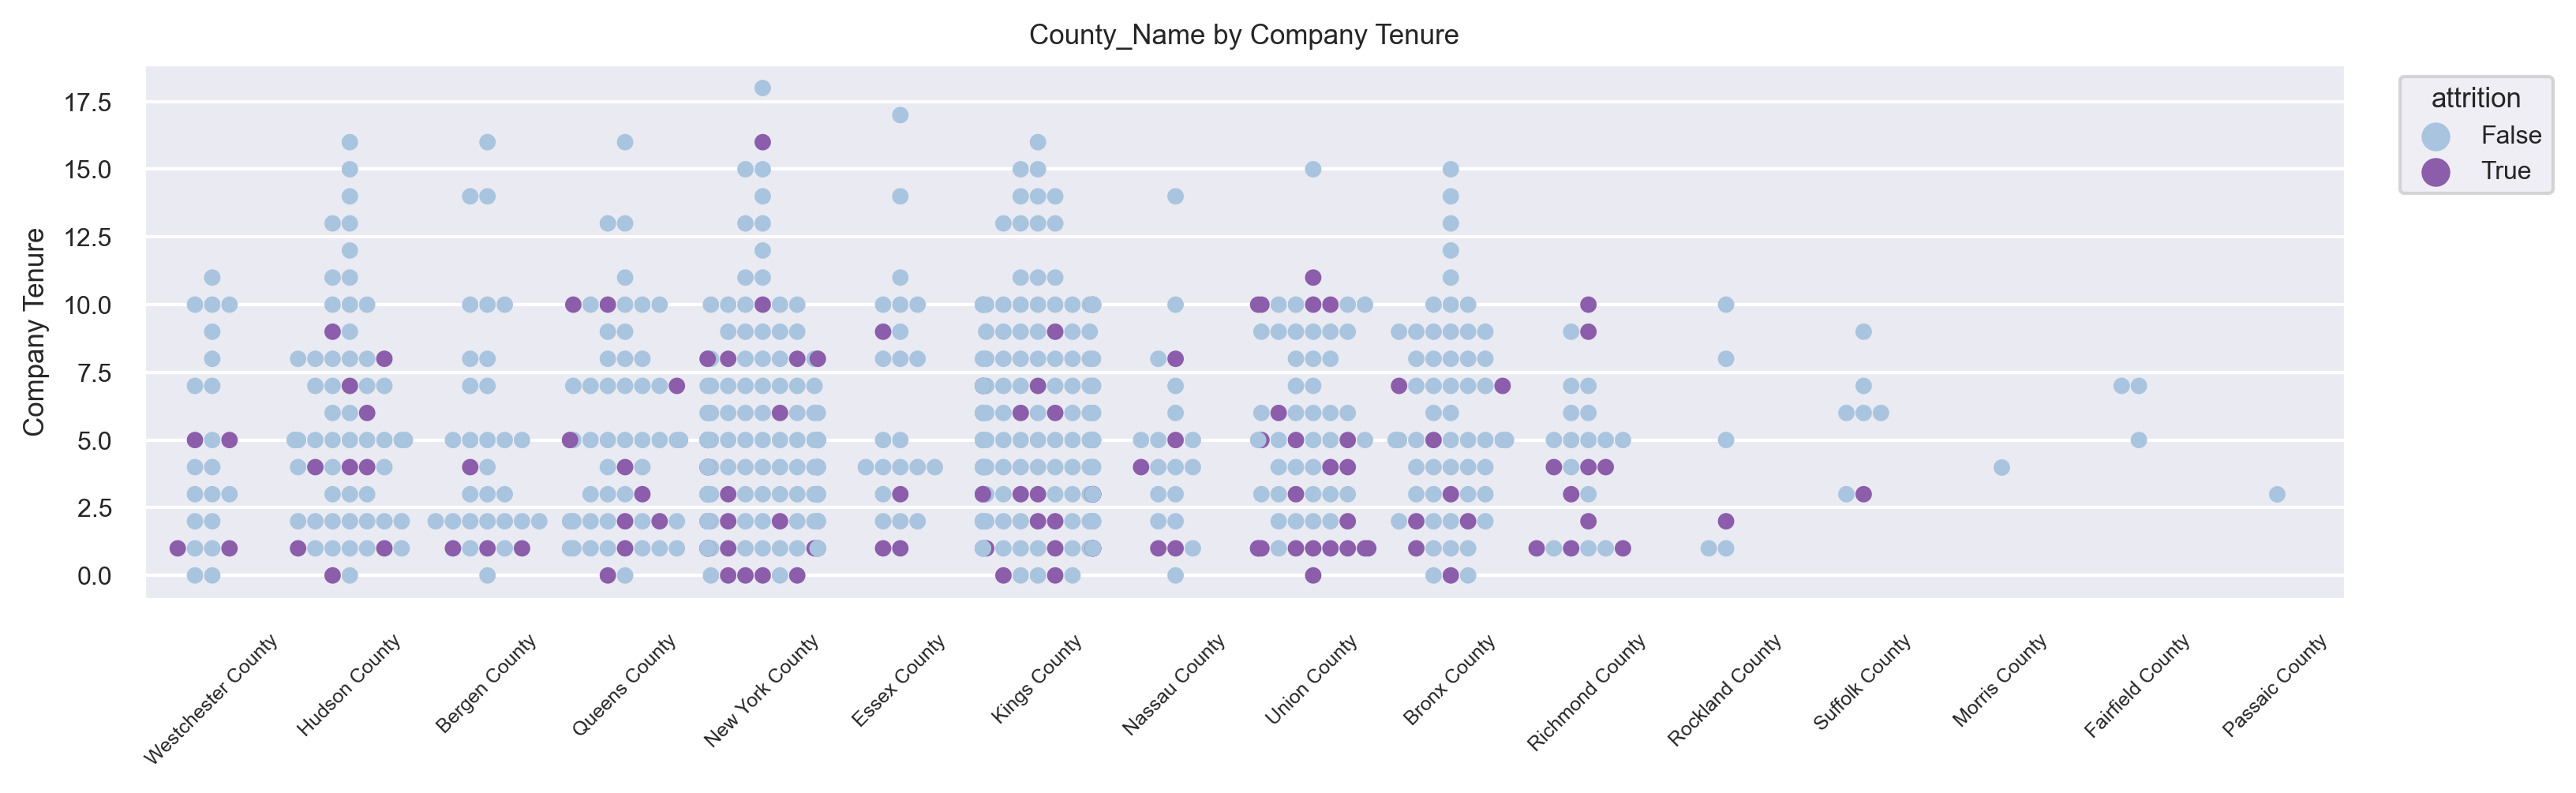

In [25]:
# plotting discrete variable sample by attrition and tenure at the company

disc_sample = [
                'gender',
                'marital_status',
                'education',
                'work_life_balance',
                'stock_option_level',
                'relationship_satisfaction',
                'environment_satisfaction',
                'job_role',
                'county_name']

for col in disc_sample:
    plt.figure(figsize=(12, 3))
    sns.set(font_scale = .7)
    sns.swarmplot(
        x = col, 
        y = "years_at_company", 
        data = train, 
        hue = "attrition", 
        
        palette = "BuPu")

    plt.xlabel(None)
    plt.ylabel("Company Tenure")
    plt.xticks(fontsize = 6, rotation = 45)
    plt.title(f'{col.title()} by Company Tenure')

    plt.legend(
        bbox_to_anchor=(1.1, 1), 
        title = "attrition",
        loc = "upper right")
    plt.show()

In [26]:
# looping through discrete variables and conducting Chi-Squared test on target variable

metrics = []

for col in disc_lst:
    # generating the ChiSquared Test and returning results
    observed = pd.crosstab(index = train[col], columns = train["attrition"], margins = True)

    chi, p_value, degf, exp_values = stats.chi2_contingency(observed)

    if p_value < alpha:
        output = {
            "discrete_feature": col,
            "chi2": chi,
            "degs_of_freedom": degf,
            "p_value": p_value}
        
        metrics.append(output)

    else:
        print(f'variable: {col}')
        print('Not statistically significant.')
        print('---------------------------------')

chi2_results = pd.DataFrame(metrics)
chi2_results.round(5)

variable: county_name
Not statistically significant.
---------------------------------
variable: department
Not statistically significant.
---------------------------------
variable: education
Not statistically significant.
---------------------------------
variable: education_field
Not statistically significant.
---------------------------------
variable: environment_satisfaction
Not statistically significant.
---------------------------------
variable: gender
Not statistically significant.
---------------------------------
variable: job_involvement
Not statistically significant.
---------------------------------
variable: job_satisfaction
Not statistically significant.
---------------------------------
variable: performance_rating
Not statistically significant.
---------------------------------
variable: relationship_satisfaction
Not statistically significant.
---------------------------------
variable: state
Not statistically significant.
---------------------------------
variable: 

discrete_feature   chi2  degs_of_freedom  p_value
0           job_level 28.398                8    0.000
1            job_role 50.725               18    0.000
2      marital_status 21.844                6    0.001
3  stock_option_level 31.937                8    0.000

----

#### **``Summary: Chi_Squared Results``**

After initial discrete/categorical hypotheses testing against the "attrition" target variable - we can conclude that the following features/variables hold a statistical relationship with the target:

- job level
- job role
- marital status
- stock option level

**<u>Follow-up/thoughts after analysis:</u>**

Features such as "job level" and "job role" although initially don't appear to be related, I presume that there may be some relationship amongst an employee's title or role and their salary level at this company. For instance, certain salary levels may only be applicable or tagged to a particular role such as a Research Director or Sales Executive.

I observe that there are only 4 distinct job levels and 9 distinct job roles at this company. In future analysis - I will want to conduct summary statistics and statistical testing across these features to investigate if there is any relationship amongst the independent variables.

In [27]:
# selecting statistically signigicant features for scaling and pre-modeling processing

X_train = prepare.select_stat_variables(X_train)
X_validate = prepare.select_stat_variables(X_validate)
X_test = prepare.select_stat_variables(X_test)

df shape: (688, 16)
df shape: (296, 16)
df shape: (246, 16)


----
#### **``Data Scaling:``**

In [28]:
# pre-scaling df data

X_train.select_dtypes(include = "number").head(2)

employee_age  employment_rates_at_35yrs  high_school_graduation_rate  \
161             56                      0.793                        0.922   
1647            27                      0.779                        0.869   

      household_income_at_35  monthly_income  percentage_married_by_35  \
161                    57101            4963                     0.446   
1647                   41374            3517                     0.345   

      poverty_rate  total_working_years  women_teenage_birthrate  \
161          0.101                    7                    0.088   
1647         0.175                    5                    0.187   

      years_at_company  years_in_current_role  years_with_curr_manager  
161                  5                      4                        3  
1647                 3                      2                        2

In [29]:
# scaling continuous variables using SKlearn's Standard Scaler

X_train = prepare.scaled_data(X_train)
X_validate = prepare.scaled_data(X_validate)

X_train.select_dtypes(include = "number").head(2)

scaled df shape: (688, 16)
scaled df shape: (296, 16)


employee_age  employment_rates_at_35yrs  high_school_graduation_rate  \
161          2.361                      1.130                        1.273   
1647        -0.966                      0.661                        0.209   

      household_income_at_35  monthly_income  percentage_married_by_35  \
161                    1.502          -0.053                     1.205   
1647                  -0.235          -0.536                    -0.068   

      poverty_rate  total_working_years  women_teenage_birthrate  \
161         -1.190               -0.359                   -1.301   
1647        -0.004               -0.732                    0.346   

      years_at_company  years_in_current_role  years_with_curr_manager  
161             -0.080                  0.186                   -0.149  
1647            -0.630                 -0.490                   -0.477

----
#### **``Assigning and Creating Discrete Feature Dummy Variables``**

In [30]:
# applying created function to return transformed dataframes w. dummy variables for modeling

X_train = prepare.get_dummy_df(X_train)
X_validate = prepare.get_dummy_df(X_validate)

# inspecting the transformed dataframe
X_train.head(2)

dummy df shape: (688, 32)
dummy df shape: (296, 32)


employee_age  employment_rates_at_35yrs  high_school_graduation_rate  \
161          2.361                      1.130                        1.273   
1647        -0.966                      0.661                        0.209   

      household_income_at_35  monthly_income  percentage_married_by_35  \
161                    1.502          -0.053                     1.205   
1647                  -0.235          -0.536                    -0.068   

      poverty_rate  total_working_years  women_teenage_birthrate  \
161         -1.190               -0.359                   -1.301   
1647        -0.004               -0.732                    0.346   

      years_at_company  ...  job_role_Research Scientist  \
161             -0.080  ...                         True   
1647            -0.630  ...                         True   

      job_role_Sales Executive  job_role_Sales Representative  \
161                      False                          False   
1647                     False                          False   

      marital_status_Divorced  marital_status_Married  marital_status_Single  \
161                     False                    True                  False   
1647                    False                    True                  False   

      stock_option_level_0  stock_option_level_1  stock_option_level_2  \
161                  False                 False                 False   
1647                  True                 False                 False   

      stock_option_level_3  
161                   True  
1647                 False  

[2 rows x 32 columns]

#### **``Feature Selection:``**

In [31]:
# Using SKlearn's SelectKBest to view rank feature significance for continuous variables

f_selector = SelectKBest(f_regression, k = 12)

cont_df = X_train.select_dtypes(include = "number")

# find the top number of independent variables (X's) correlated with y
f_selector.fit(cont_df, y_train)

# boolean mask of whether the column was selected or not
feature_mask = f_selector.get_support()

# get list of top (2) K features. 
f_feature = cont_df.iloc[:,feature_mask].columns.tolist()

feature_lst = pd.DataFrame(f_feature).rename(columns = {0: "continuous_feature"})
feature_lst

continuous_feature
0                  employee_age
1     employment_rates_at_35yrs
2   high_school_graduation_rate
3        household_income_at_35
4                monthly_income
5      percentage_married_by_35
6                  poverty_rate
7           total_working_years
8       women_teenage_birthrate
9              years_at_company
10        years_in_current_role
11      years_with_curr_manager

In [32]:
# Using SKlearn's SelectKBest to view rank feature significance for discrete variables

f_selector = SelectKBest(chi2, k = 20)

disc_df = X_train.select_dtypes(exclude = "number")

# find the top number of independent variables (X's) correlated with y
f_selector.fit(disc_df, y_train)

# boolean mask of whether the column was selected or not
feature_mask = f_selector.get_support()

# get list of top (2) K features. 
f_feature = disc_df.iloc[:,feature_mask].columns.tolist()

feature_lst = pd.DataFrame(f_feature).rename(columns = {0: "discrete_feature"})
feature_lst

discrete_feature
0                          job_level_1
1                          job_level_2
2                          job_level_3
3                          job_level_4
4   job_role_Healthcare Representative
5             job_role_Human Resources
6       job_role_Laboratory Technician
7                     job_role_Manager
8      job_role_Manufacturing Director
9           job_role_Research Director
10         job_role_Research Scientist
11            job_role_Sales Executive
12       job_role_Sales Representative
13             marital_status_Divorced
14              marital_status_Married
15               marital_status_Single
16                stock_option_level_0
17                stock_option_level_1
18                stock_option_level_2
19                stock_option_level_3

In [33]:
# Using SKlearn's Recursive Feature Elimination - w. Cross Validation (RFECV) to determine best features to model on
# Applying a Random Forest Classifier to determine feature predictive contribution 

cross_validation = RFECV(
    estimator = RandomForestClassifier(random_state = 548),
    min_features_to_select = 5)

cross_validation = cross_validation.fit(X_train, y_train)

rf_features = X_train.columns[cross_validation.support_].tolist()
pd.DataFrame(rf_features).rename(columns = {0: "Features"}).sort_values("Features").reset_index(drop = True)

Features
0                         employee_age
1            employment_rates_at_35yrs
2          high_school_graduation_rate
3               household_income_at_35
4                          job_level_1
5                          job_level_2
6                          job_level_3
7   job_role_Healthcare Representative
8             job_role_Human Resources
9       job_role_Laboratory Technician
10     job_role_Manufacturing Director
11         job_role_Research Scientist
12            job_role_Sales Executive
13       job_role_Sales Representative
14             marital_status_Divorced
15              marital_status_Married
16               marital_status_Single
17                      monthly_income
18            percentage_married_by_35
19                        poverty_rate
20                stock_option_level_0
21                stock_option_level_1
22                stock_option_level_2
23                stock_option_level_3
24                 total_working_years
25             women_teenage_birthrate
26                    years_at_company
27               years_in_current_role
28             years_with_curr_manager

In [34]:
# transforming modeling datasets with RFECV features 

train_model = X_train[rf_features]
validate_model = X_validate[rf_features]

train_model.head(3)

employee_age  employment_rates_at_35yrs  high_school_graduation_rate  \
161          2.361                      1.130                        1.273   
1647        -0.966                      0.661                        0.209   
624          1.214                      1.451                        1.659   

      household_income_at_35  monthly_income  percentage_married_by_35  \
161                    1.502          -0.053                     1.205   
1647                  -0.235          -0.536                    -0.068   
624                    2.200           1.804                     2.001   

      poverty_rate  total_working_years  women_teenage_birthrate  \
161         -1.190               -0.359                   -1.301   
1647        -0.004               -0.732                    0.346   
624         -1.598                3.557                   -2.071   

      years_at_company  ...  job_role_Research Scientist  \
161             -0.080  ...                         True   
1647            -0.630  ...                         True   
624             -0.905  ...                        False   

      job_role_Sales Executive  job_role_Sales Representative  \
161                      False                          False   
1647                     False                          False   
624                      False                          False   

      marital_status_Divorced  marital_status_Married  marital_status_Single  \
161                     False                    True                  False   
1647                    False                    True                  False   
624                     False                    True                  False   

      stock_option_level_0  stock_option_level_1  stock_option_level_2  \
161                  False                 False                 False   
1647                  True                 False                 False   
624                   True                 False                 False   

      stock_option_level_3  
161                   True  
1647                 False  
624                  False  

[3 rows x 29 columns]

----
### **``Modeling``**

``Model Class: Decision Tree``

In [35]:
# model 1A: Decision Tree

metrics = []
leaf_counter = 0

for i in range(1, 16):
    # creating the model
    tree = DecisionTreeClassifier(
        min_samples_leaf = (leaf_counter + 1), 
        max_depth = i,
        random_state=548)

    # increasing leaf counter by 1
    leaf_counter += 1

    # fitting the model
    tree = tree.fit(train_model, y_train)

    # applying the model and evaluating its performance on the training dataset
    in_sample_accuracy = tree.score(train_model, y_train)

    # next, we'll evaluate the model on "out-of-sample" data (validate)
    out_of_sample_accuracy = tree.score(validate_model, y_validate)

    output = {
        "model": "decision_tree", \
        "max_depth": i, \
        "min_sample_leaves": leaf_counter, \
        "train_accuracy": in_sample_accuracy, \
        "validate_accuracy": out_of_sample_accuracy
    }

    metrics.append(output)

df = pd.DataFrame(metrics)
df["percent_change_diff"] = ((df.train_accuracy - df.validate_accuracy) / df.validate_accuracy)
df.round(4)

model  max_depth  min_sample_leaves  train_accuracy  \
0   decision_tree          1                  1           0.827   
1   decision_tree          2                  2           0.837   
2   decision_tree          3                  3           0.839   
3   decision_tree          4                  4           0.856   
4   decision_tree          5                  5           0.866   
5   decision_tree          6                  6           0.884   
6   decision_tree          7                  7           0.869   
7   decision_tree          8                  8           0.861   
8   decision_tree          9                  9           0.862   
9   decision_tree         10                 10           0.856   
10  decision_tree         11                 11           0.856   
11  decision_tree         12                 12           0.852   
12  decision_tree         13                 13           0.849   
13  decision_tree         14                 14           0.849   
14  decision_tree         15                 15           0.849   

    validate_accuracy  percent_change_diff  
0               0.807                0.024  
1               0.814                0.028  
2               0.794                0.056  
3               0.818                0.047  
4               0.790                0.096  
5               0.801                0.104  
6               0.807                0.076  
7               0.807                0.066  
8               0.787                0.095  
9               0.821                0.043  
10              0.821                0.043  
11              0.828                0.029  
12              0.838                0.013  
13              0.838                0.013  
14              0.838                0.013

In [36]:
# model 1B: Decision Tree (reversed sample leaves)

metrics = []
leaf_counter = 21

for i in range(1, 21):
    # creating the model
    tree = DecisionTreeClassifier(
        min_samples_leaf = (leaf_counter - 1), 
        max_depth = i, 
        random_state=548)

    # decreasing leaf counter by 1
    leaf_counter -= 1

    # fitting the model
    tree = tree.fit(train_model, y_train)

    # applying the model and evaluating its performance on the training dataset
    in_sample_accuracy = tree.score(train_model, y_train)

    # next, we'll evaluate the model on "out-of-sample" data (validate)
    out_of_sample_accuracy = tree.score(validate_model, y_validate)

    output = {
        "model": "decision_tree_reversed", \
        "max_depth": i, \
        "min_sample_leaves": leaf_counter, \
        "train_accuracy": in_sample_accuracy, \
        "validate_accuracy": out_of_sample_accuracy
    }

    metrics.append(output)

df = pd.DataFrame(metrics)
df["percent_change_diff"] = ((df.train_accuracy - df.validate_accuracy) / df.validate_accuracy)
df.round(4)

model  max_depth  min_sample_leaves  train_accuracy  \
0   decision_tree_reversed          1                 20           0.827   
1   decision_tree_reversed          2                 19           0.836   
2   decision_tree_reversed          3                 18           0.837   
3   decision_tree_reversed          4                 17           0.843   
4   decision_tree_reversed          5                 16           0.843   
5   decision_tree_reversed          6                 15           0.849   
6   decision_tree_reversed          7                 14           0.849   
7   decision_tree_reversed          8                 13           0.849   
8   decision_tree_reversed          9                 12           0.852   
9   decision_tree_reversed         10                 11           0.856   
10  decision_tree_reversed         11                 10           0.856   
11  decision_tree_reversed         12                  9           0.862   
12  decision_tree_reversed         13                  8           0.866   
13  decision_tree_reversed         14                  7           0.879   
14  decision_tree_reversed         15                  6           0.900   
15  decision_tree_reversed         16                  5           0.905   
16  decision_tree_reversed         17                  4           0.911   
17  decision_tree_reversed         18                  3           0.930   
18  decision_tree_reversed         19                  2           0.951   
19  decision_tree_reversed         20                  1           1.000   

    validate_accuracy  percent_change_diff  
0               0.807                0.024  
1               0.828                0.010  
2               0.807                0.037  
3               0.828                0.018  
4               0.828                0.018  
5               0.838                0.013  
6               0.838                0.013  
7               0.838                0.013  
8               0.828                0.029  
9               0.821                0.043  
10              0.821                0.043  
11              0.787                0.095  
12              0.801                0.082  
13              0.794                0.108  
14              0.780                0.153  
15              0.740                0.224  
16              0.767                0.188  
17              0.740                0.257  
18              0.780                0.218  
19              0.750                0.333

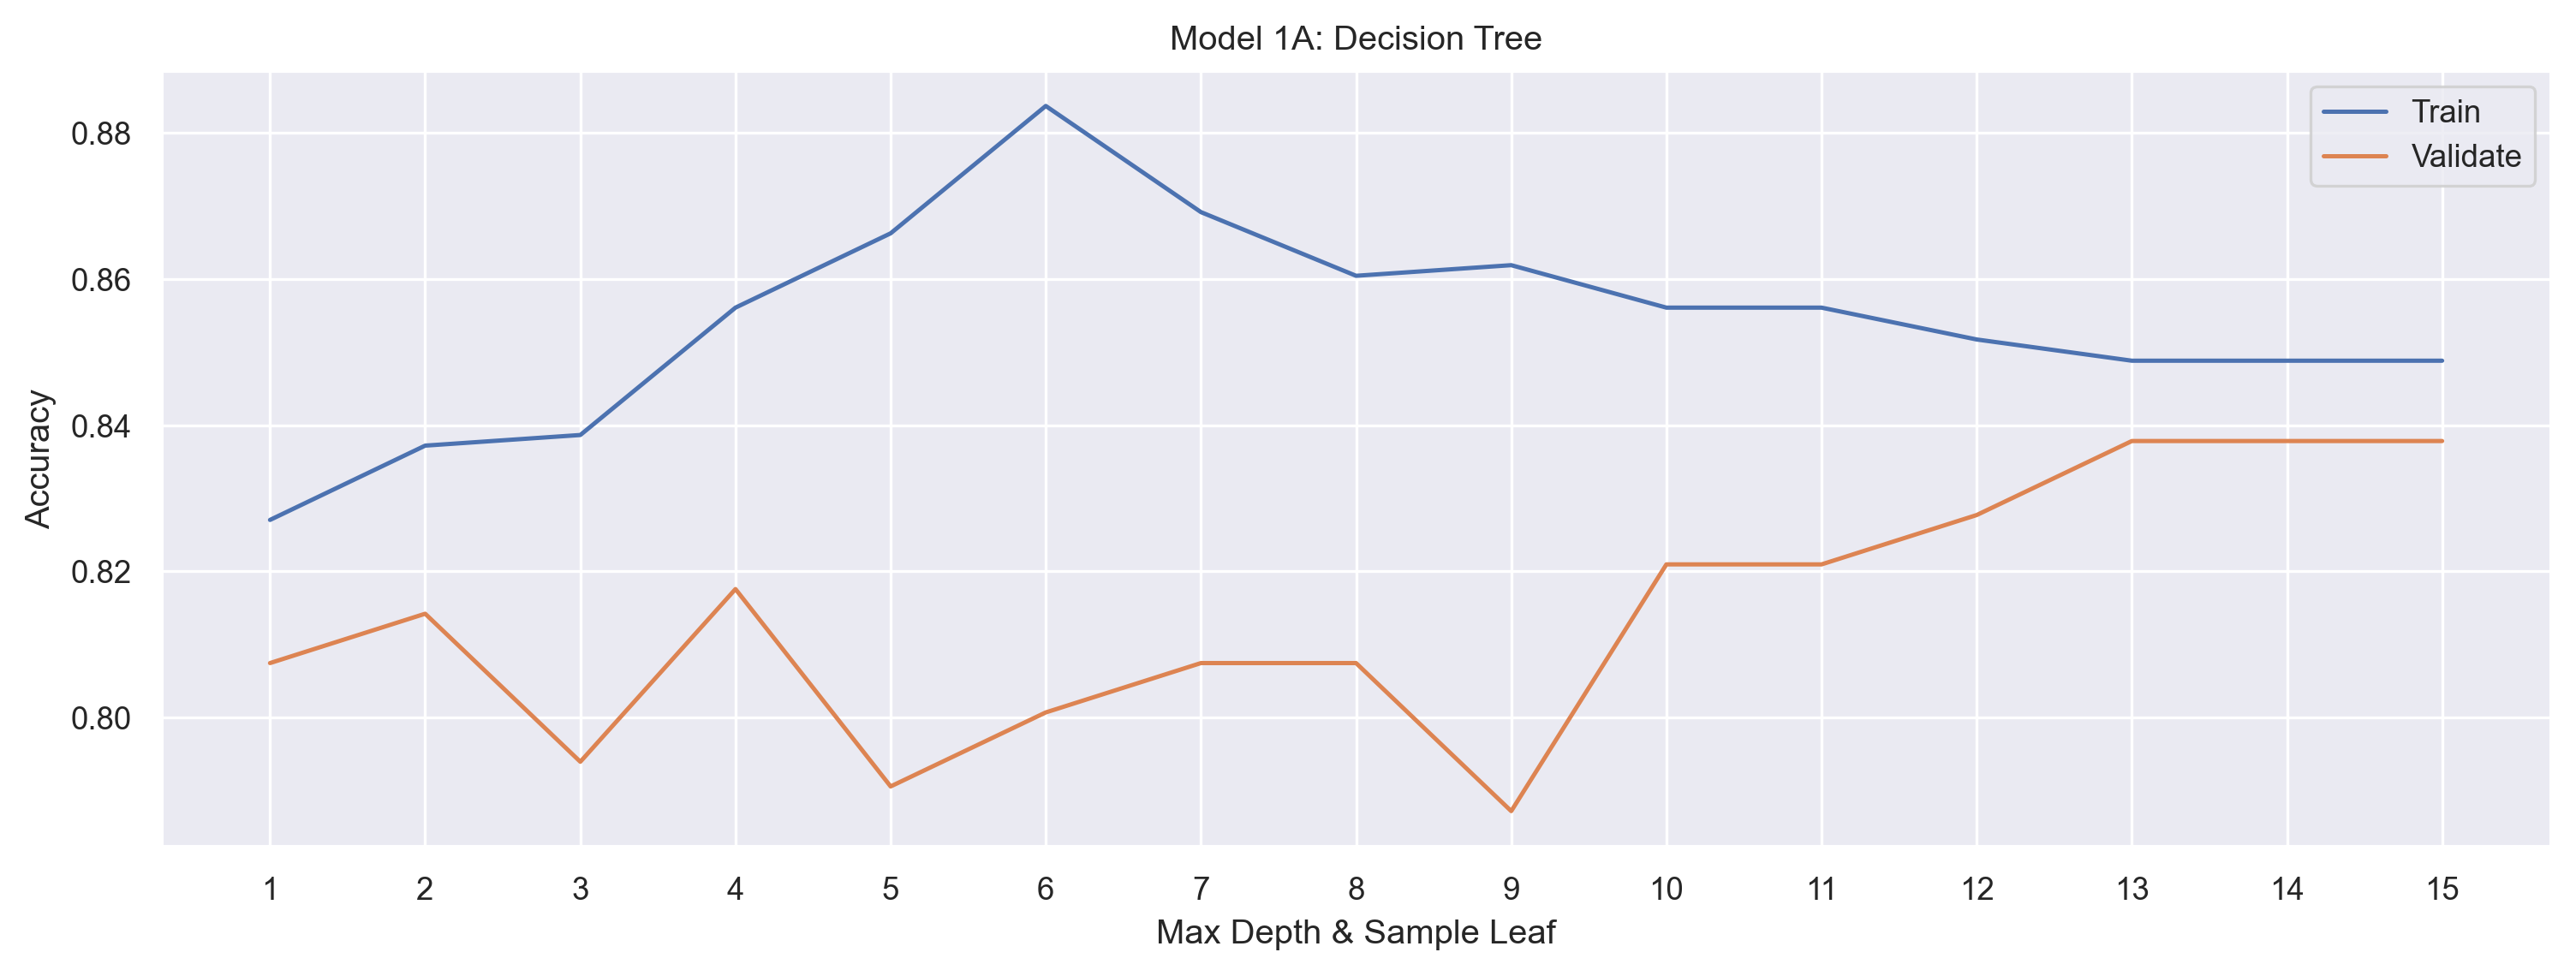

In [37]:
# Decision Tree 1A: comparison across in-sample and out-sample datasets:

sns.set_theme("paper")

i_range = range(1, 16)
train_scores = []
validate_scores = []

for i in i_range:
    tree = DecisionTreeClassifier(
        min_samples_leaf = i, 
        max_depth = i,
        random_state=548)
        
    tree.fit(train_model, y_train)

    train_scores.append(tree.score(train_model, y_train))
    validate_scores.append(tree.score(validate_model, y_validate))


plt.figure(figsize=(12, 4))
plt.title('Model 1A: Decision Tree')
plt.xlabel('Max Depth & Sample Leaf')
plt.ylabel('Accuracy')
plt.plot(i_range, train_scores, label='Train')
plt.plot(i_range, validate_scores, label='Validate')
plt.legend()
plt.xticks(i_range)
plt.show()

``Model Class: K-nearest Neighbor (KNN)``

In [38]:
# model number 2: K-nearest neighbor (KNN)

metrics = []

for k in range(1, 16):
    # creating the model
    knn = KNeighborsClassifier(
                                n_neighbors = k, 
                                weights = 'uniform')

    # fitting the model (on train and only train)
    knn = knn.fit(train_model, y_train)

    # evaluating the model's performance on training dataset
    in_sample_accuracy = knn.score(train_model, y_train)
    
    # evaluating the model on "out-of-sample" data (validate)
    out_of_sample_accuracy = knn.score(validate_model, y_validate)

    output = {
        "num_of_neighbors": k,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy}
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["percent_change_diff"] = ((df.train_accuracy - df.validate_accuracy) / df.train_accuracy)
df.round(4)

num_of_neighbors  train_accuracy  validate_accuracy  percent_change_diff
0                  1           1.000              0.740                0.260
1                  2           0.876              0.804                0.083
2                  3           0.878              0.787                0.103
3                  4           0.852              0.845                0.008
4                  5           0.849              0.831                0.021
5                  6           0.846              0.835                0.014
6                  7           0.855              0.818                0.043
7                  8           0.846              0.841                0.006
8                  9           0.842              0.824                0.021
9                 10           0.845              0.838                0.008
10                11           0.837              0.831                0.007
11                12           0.834              0.831                0.004
12                13           0.836              0.831                0.006
13                14           0.831              0.831                0.000
14                15           0.826              0.828               -0.003

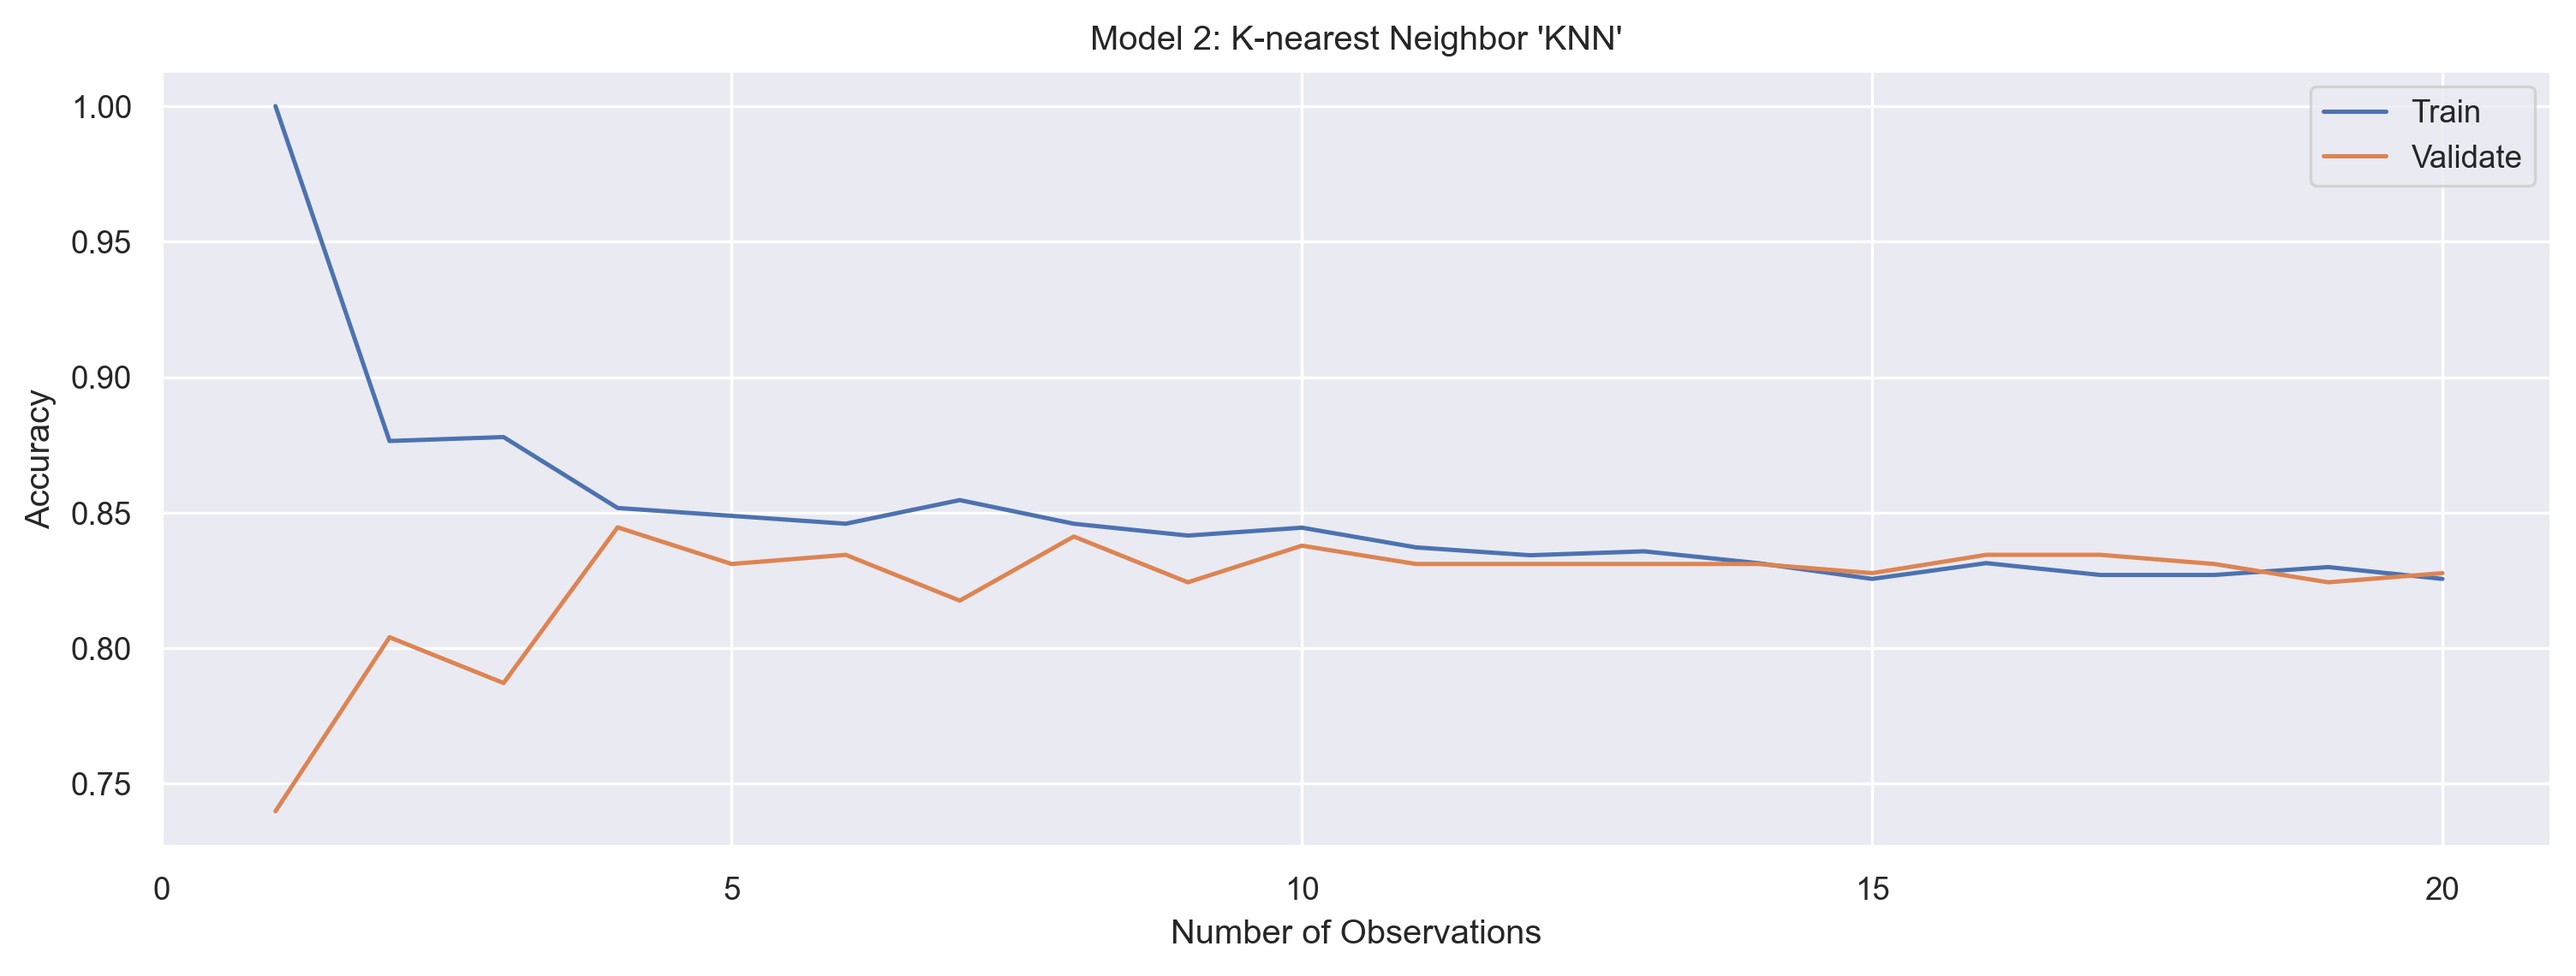

In [39]:
# KNN plot: comparison across in-sample and out-sample datasets:

sns.set_theme("paper")

n_range = range(1, 21)
train_scores = []
validate_scores = []

for n in n_range:
    knn = KNeighborsClassifier(
        n_neighbors = n, 
        weights = 'uniform')

    knn.fit(train_model, y_train)
    train_scores.append(knn.score(train_model, y_train))
    validate_scores.append(knn.score(validate_model, y_validate))

plt.figure(figsize=(12, 4))
plt.title("Model 2: K-nearest Neighbor 'KNN'")
plt.xlabel('Number of Observations')
plt.ylabel('Accuracy')
plt.plot(n_range, train_scores, label='Train')
plt.plot(n_range, validate_scores, label='Validate')
plt.legend()
plt.xticks([0,5,10,15,20])
plt.show()

``Model Class: Logistic Regression``

In [40]:
# model number 3: Logistic Regression

metrics = []

for i in np.linspace(0.1, 1.0, 10):

    # creating the model
    logi = LogisticRegression(
        C = i, 
        random_state=548)

    # fitting the model (on train and only train)
    logi = logi.fit(train_model, y_train)

    # applying the model and evaluating its performance on the training dataset
    in_sample_accuracy = logi.score(train_model, y_train)

    # next, we'll evaluate the model on "out-of-sample" data (validate)
    out_of_sample_accuracy = logi.score(validate_model, y_validate)

    output = {
        "model": "logi_model", \
        "C_parameter": i, \
        "train_accuracy": in_sample_accuracy, \
        "validate_accuracy": out_of_sample_accuracy
    }

    metrics.append(output)

df = pd.DataFrame(metrics)
df["percent_change_diff"] = ((df.train_accuracy - df.validate_accuracy) / df.validate_accuracy)
df.round(4)

model  C_parameter  train_accuracy  validate_accuracy  \
0  logi_model        0.100           0.839              0.838   
1  logi_model        0.200           0.842              0.838   
2  logi_model        0.300           0.842              0.835   
3  logi_model        0.400           0.846              0.831   
4  logi_model        0.500           0.846              0.835   
5  logi_model        0.600           0.845              0.835   
6  logi_model        0.700           0.843              0.835   
7  logi_model        0.800           0.843              0.835   
8  logi_model        0.900           0.843              0.841   
9  logi_model        1.000           0.843              0.841   

   percent_change_diff  
0                0.001  
1                0.004  
2                0.009  
3                0.018  
4                0.014  
5                0.012  
6                0.010  
7                0.010  
8                0.002  
9                0.002

In [41]:
# Logistic Regression Report on Validate

metrics = []

for i in np.linspace(0.1, 1.0, 10):

    # creating the model
    logi = LogisticRegression(
        C = i, 
        random_state=548)

    # fitting the model (on train and only train)
    logi = logi.fit(train_model, y_train)

    # We'll evaluate the model's petreeormance on train, first
    y_predictions = logi.predict(validate_model)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_validate, y_predictions, output_dict=True)
    print(f"With Class Weight: {i.round(2)}")
    print(pd.DataFrame(report))
    
    print()

With Class Weight: 0.1
            False   True  accuracy  macro avg  weighted avg
precision   0.838  0.833     0.838      0.836         0.837
recall      0.996  0.096     0.838      0.546         0.838
f1-score    0.910  0.172     0.838      0.541         0.781
support   244.000 52.000     0.838    296.000       296.000

With Class Weight: 0.2
            False   True  accuracy  macro avg  weighted avg
precision   0.848  0.643     0.838      0.745         0.812
recall      0.980  0.173     0.838      0.576         0.838
f1-score    0.909  0.273     0.838      0.591         0.797
support   244.000 52.000     0.838    296.000       296.000

With Class Weight: 0.3
            False   True  accuracy  macro avg  weighted avg
precision   0.847  0.600     0.834      0.723         0.804
recall      0.975  0.173     0.834      0.574         0.834
f1-score    0.907  0.269     0.834      0.588         0.795
support   244.000 52.000     0.834    296.000       296.000

With Class Weight: 0.4
     

``Model Class: Random Forest``

In [42]:
# model number 4: Random Forest 

metrics = []
leaf_counter = 21

for i in range(1, 21):
    # Make the model
    rf = RandomForestClassifier(
        min_samples_leaf = (leaf_counter-1), 
        max_depth = i,
        random_state=548)

    # update leaf count
    leaf_counter -= 1

    # Fit the model (on train and only train)
    rf = rf.fit(train_model, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = rf.score(train_model, y_train)
    
    # next, we'll evaluate the model on "out-of-sample" data (validate)
    out_of_sample_accuracy = rf.score(validate_model, y_validate)
    
    output = {
        "model": "rf_classifier",
        "max_depth": i, \
        "num_of_sample_leaf": leaf_counter, \
        "train_accuracy": in_sample_accuracy, \
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["percent_change_diff"] = ((df.train_accuracy - df.validate_accuracy) / df.train_accuracy)
df.round(2)


model  max_depth  num_of_sample_leaf  train_accuracy  \
0   rf_classifier          1                  20           0.820   
1   rf_classifier          2                  19           0.830   
2   rf_classifier          3                  18           0.830   
3   rf_classifier          4                  17           0.840   
4   rf_classifier          5                  16           0.840   
5   rf_classifier          6                  15           0.840   
6   rf_classifier          7                  14           0.840   
7   rf_classifier          8                  13           0.840   
8   rf_classifier          9                  12           0.840   
9   rf_classifier         10                  11           0.840   
10  rf_classifier         11                  10           0.850   
11  rf_classifier         12                   9           0.850   
12  rf_classifier         13                   8           0.850   
13  rf_classifier         14                   7           0.860   
14  rf_classifier         15                   6           0.860   
15  rf_classifier         16                   5           0.860   
16  rf_classifier         17                   4           0.870   
17  rf_classifier         18                   3           0.890   
18  rf_classifier         19                   2           0.930   
19  rf_classifier         20                   1           1.000   

    validate_accuracy  percent_change_diff  
0               0.820               -0.000  
1               0.820                0.000  
2               0.820                0.010  
3               0.820                0.010  
4               0.830                0.010  
5               0.830                0.010  
6               0.830                0.010  
7               0.830                0.010  
8               0.840                0.010  
9               0.840                0.010  
10              0.830                0.010  
11              0.840                0.010  
12              0.830                0.020  
13              0.830                0.030  
14              0.840                0.020  
15              0.830                0.030  
16              0.830                0.040  
17              0.820                0.070  
18              0.830                0.110  
19              0.830                0.170

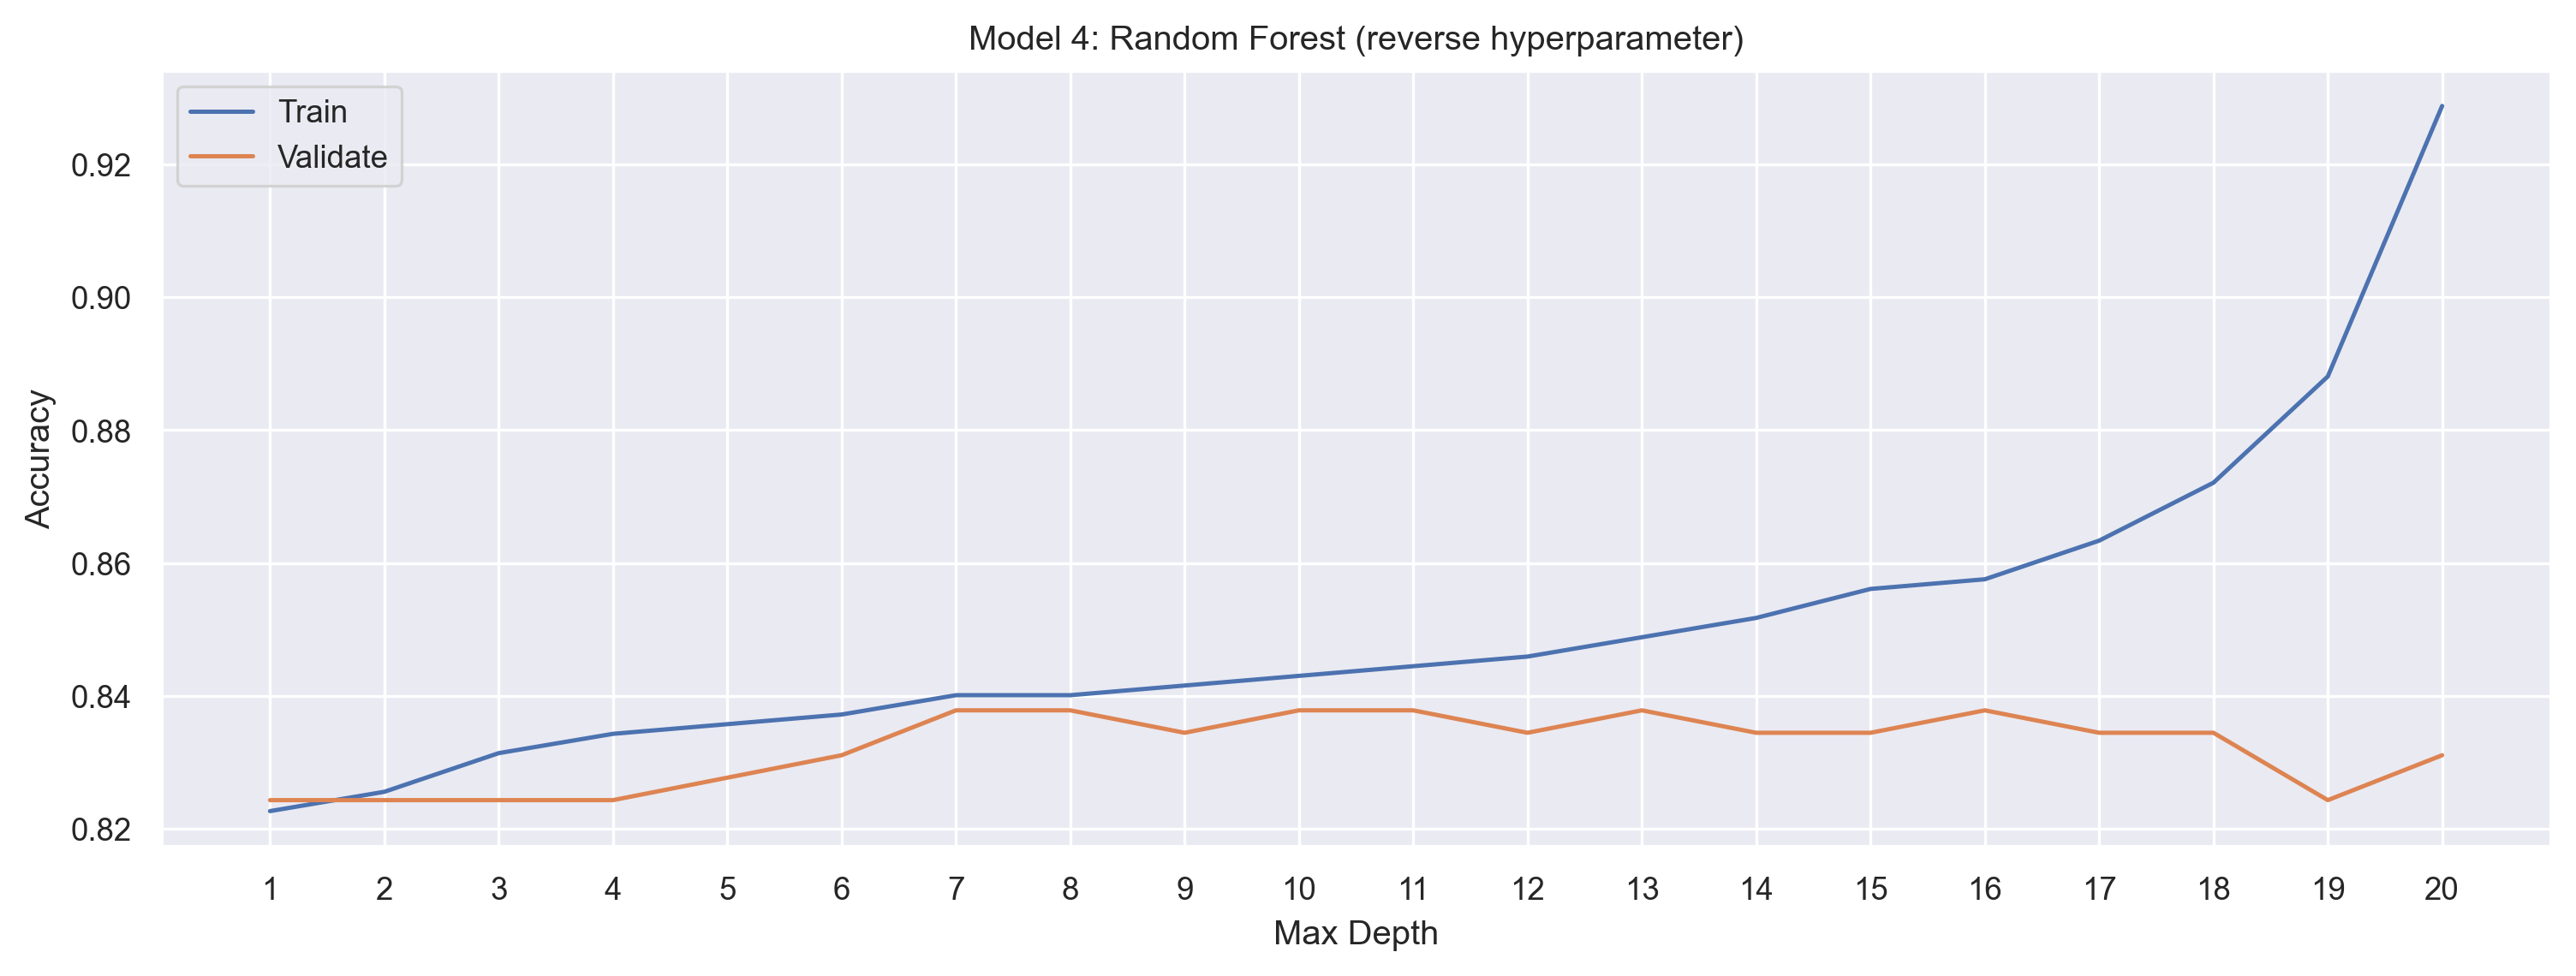

In [43]:
# Random Forest plot: comparison across in-sample and out-sample datasets:

sns.set_theme("paper")

i_range = range(1, 21)
leaf_counter = 21
train_scores = []
validate_scores = []

for i in i_range:
    rf = RandomForestClassifier(
        min_samples_leaf = leaf_counter, 
        max_depth = i,
        random_state=548)
        
    # update leaf counter
    leaf_counter -= 1

    rf.fit(train_model, y_train)

    train_scores.append(rf.score(train_model, y_train))
    validate_scores.append(rf.score(validate_model, y_validate))


plt.figure(figsize=(12, 4))
plt.title('Model 4: Random Forest (reverse hyperparameter)')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.plot(i_range, train_scores, label='Train')
plt.plot(i_range, validate_scores, label='Validate')
plt.legend()
plt.xticks(i_range)
plt.show()

----
#### **``Summary: Modeling``**

After comparing all six (6) unique models, I concluded that the following models resulted in the best predictive overall accuracy performance:

**Logistic Regression (1): C = 1.0**

- ~84% predictive accuracy
- relative training set diff. ~0%

**Logistic Regression (2): C = 0.9**

- ~84% predictive accuracy
- relative training set diff. ~%0

**Decision Tree (1): depth of 13, and min sample leaf of 13**

- ~84% predictive accuracy
- relative training set diff. ~1% (+)

**Decision Tree (2): depth of 7, and min sample leaf of 14**

- ~84% predictive accuracy
- relative training set diff. ~1% (+)

**Random Forest: depth of 7, and min sample leaf of 14**

- ~84% predictive accuracy
- relative training set diff. ~1% (+)

**K-nearest Neighbor (KNN): k = 4**

- ~84% predictive accuracy
- relative training set diff. ~1% (+)

**K-nearest Neighbor (KNN): k = 10**

- ~84% predictive accuracy
- relative training set diff. ~1% (+)

-----

**<u>``Model Evaluation``</u>**

After evaluating all the models tested, I chose to deploy the Logistic Regression model for the following reasons:

- Ease of understanding/interpretation
- May be most flexible to deploy/maintain over time
- compared to decision tree or random forest models, the logistic regression predictability accuracy may be less dependent on commonly collected information

In [44]:
# deploying the Logistic Regression w/C of 1.0 on Test Dataset
# scaling the test dataset

X_test = prepare.scaled_data(X_test)
X_test.head(3)

scaled df shape: (246, 16)


job_level                   job_role marital_status stock_option_level  \
1763         2  Healthcare Representative        Married                  1   
1954         2  Healthcare Representative        Married                  1   
1301         1         Research Scientist         Single                  0   

      employee_age  employment_rates_at_35yrs  high_school_graduation_rate  \
1763        -0.524                      1.780                        1.800   
1954        -0.649                     -0.989                       -0.933   
1301        -0.774                     -0.880                       -0.417   

      household_income_at_35  monthly_income  percentage_married_by_35  \
1763                   2.336           0.105                     1.994   
1954                  -0.621           0.134                    -0.775   
1301                  -0.691          -1.068                    -0.377   

      poverty_rate  total_working_years  women_teenage_birthrate  \
1763        -1.885                0.304                   -1.973   
1954        -0.033               -0.507                    0.414   
1301         0.865               -0.709                    0.484   

      years_at_company  years_in_current_role  years_with_curr_manager  
1763             0.380                 -1.135                    1.166  
1954            -0.134                 -0.176                   -0.479  
1301            -0.648                 -0.495                   -0.479

In [45]:
# assigning dummy variables

X_test = prepare.get_dummy_df(X_test)
X_test.head(3)

dummy df shape: (246, 32)


employee_age  employment_rates_at_35yrs  high_school_graduation_rate  \
1763        -0.524                      1.780                        1.800   
1954        -0.649                     -0.989                       -0.933   
1301        -0.774                     -0.880                       -0.417   

      household_income_at_35  monthly_income  percentage_married_by_35  \
1763                   2.336           0.105                     1.994   
1954                  -0.621           0.134                    -0.775   
1301                  -0.691          -1.068                    -0.377   

      poverty_rate  total_working_years  women_teenage_birthrate  \
1763        -1.885                0.304                   -1.973   
1954        -0.033               -0.507                    0.414   
1301         0.865               -0.709                    0.484   

      years_at_company  ...  job_role_Research Scientist  \
1763             0.380  ...                        False   
1954            -0.134  ...                        False   
1301            -0.648  ...                         True   

      job_role_Sales Executive  job_role_Sales Representative  \
1763                     False                          False   
1954                     False                          False   
1301                     False                          False   

      marital_status_Divorced  marital_status_Married  marital_status_Single  \
1763                    False                    True                  False   
1954                    False                    True                  False   
1301                    False                   False                   True   

      stock_option_level_0  stock_option_level_1  stock_option_level_2  \
1763                 False                  True                 False   
1954                 False                  True                 False   
1301                  True                 False                 False   

      stock_option_level_3  
1763                 False  
1954                 False  
1301                 False  

[3 rows x 32 columns]

In [46]:
# selecting features to model on

test_model = X_test[rf_features]
test_model.head(3)

employee_age  employment_rates_at_35yrs  high_school_graduation_rate  \
1763        -0.524                      1.780                        1.800   
1954        -0.649                     -0.989                       -0.933   
1301        -0.774                     -0.880                       -0.417   

      household_income_at_35  monthly_income  percentage_married_by_35  \
1763                   2.336           0.105                     1.994   
1954                  -0.621           0.134                    -0.775   
1301                  -0.691          -1.068                    -0.377   

      poverty_rate  total_working_years  women_teenage_birthrate  \
1763        -1.885                0.304                   -1.973   
1954        -0.033               -0.507                    0.414   
1301         0.865               -0.709                    0.484   

      years_at_company  ...  job_role_Research Scientist  \
1763             0.380  ...                        False   
1954            -0.134  ...                        False   
1301            -0.648  ...                         True   

      job_role_Sales Executive  job_role_Sales Representative  \
1763                     False                          False   
1954                     False                          False   
1301                     False                          False   

      marital_status_Divorced  marital_status_Married  marital_status_Single  \
1763                    False                    True                  False   
1954                    False                    True                  False   
1301                    False                   False                   True   

      stock_option_level_0  stock_option_level_1  stock_option_level_2  \
1763                 False                  True                 False   
1954                 False                  True                 False   
1301                  True                 False                 False   

      stock_option_level_3  
1763                 False  
1954                 False  
1301                 False  

[3 rows x 29 columns]

In [47]:
# creating the model and scoring against all three datasets

# creating the model
logi_final = LogisticRegression(
            C = 1, 
            random_state=548)

# fitting the model (on train dataset)
logi_final = logi_final.fit(train_model, y_train)

# applying the model and evaluating its performance on all three (3) datasets

train_accuracy = logi_final.score(train_model, y_train)
validate_accuracy = logi_final.score(validate_model, y_validate)
test_accuracy = logi_final.score(test_model, y_test)

In [48]:
# returning final results including relative difference test dataset 

train_diff = (baseline_train - train_accuracy)/train_accuracy
val_diff = (train_accuracy - validate_accuracy)/validate_accuracy
test_diff = (validate_accuracy - test_accuracy)/test_accuracy

pd.DataFrame({
    'dataset': ["baseline", "train", "validate", "test (final)"], 
    "accuracy": [baseline_train, train_accuracy, validate_accuracy, test_accuracy], 
    "relative_difference": [0, train_diff, val_diff, test_diff]})

dataset  accuracy  relative_difference
0      baseline     0.823                0.000
1         train     0.843               -0.024
2      validate     0.841                0.002
3  test (final)     0.813                0.035

----
``deploying model on full dataset``

In [49]:
# importing and cleaning a new dataset

df = acquire.get_employee_df()
df = prepare.clean_employee_df(df)
df = prepare.df_outliers(df)

initial df shape: (1470, 46)
shape after cleaning: (1470, 34)
shape after outliers: (1230, 34)


In [50]:
# creating outcomes/attrition series

outcomes = df["attrition"]
outcomes.head()

1     True
2    False
4     True
5    False
7    False
Name: attrition, dtype: bool

In [51]:
# creating confusion matrix on entire dataset 

df = df.drop(columns = "attrition")
df.head()

employee_age  monthly_income  percent_salary_hike  total_working_years  \
1            41            5993                   11                    8   
2            49            5130                   23                   10   
4            37            2090                   15                    7   
5            33            2909                   11                    8   
7            27            3468                   12                    6   

   training_times_last_year  years_at_company  household_income_at_35  \
1                         0                 6                   37229   
2                         3                10                   32542   
4                         3                 0                   37229   
5                         3                 8                   37229   
7                         3                 2                   37826   

   high_school_graduation_rate  percentage_married_by_35  incarceration_rate  \
1                        0.838                     0.320               0.014   
2                        0.778                     0.222               0.016   
4                        0.838                     0.320               0.014   
5                        0.838                     0.320               0.014   
7                        0.813                     0.290               0.011   

   ...               job_role  job_satisfaction  marital_status  \
1  ...        Sales Executive                 4          Single   
2  ...     Research Scientist                 2         Married   
4  ...  Laboratory Technician                 3          Single   
5  ...     Research Scientist                 3         Married   
7  ...  Laboratory Technician                 2         Married   

   performance_rating  relationship_satisfaction state stock_option_level  \
1                   3                          1    NY                  0   
2                   4                          4    NY                  1   
4                   3                          2    NY                  0   
5                   3                          3    NY                  0   
7                   3                          4    NY                  1   

  work_life_balance years_in_current_role years_with_curr_manager  
1                 1                     4                       5  
2                 3                     7                       7  
4                 3                     0                       0  
5                 3                     7                       0  
7                 3                     2                       2  

[5 rows x 33 columns]

In [52]:
# scaling df and generating dummy variables

df = prepare.scaled_data(df)
df = prepare.get_dummy_df(df)

scaled df shape: (1230, 33)
dummy df shape: (1230, 49)


In [53]:
# selecting model features from which to make predictions on

df = df[rf_features]
df.head()

employee_age  employment_rates_at_35yrs  high_school_graduation_rate  \
1         0.672                     -0.905                       -0.441   
2         1.611                     -0.574                       -1.645   
4         0.202                     -0.905                       -0.441   
5        -0.267                     -0.905                       -0.441   
7        -0.972                     -1.014                       -0.945   

   household_income_at_35  monthly_income  percentage_married_by_35  \
1                  -0.704           0.309                    -0.398   
2                  -1.225           0.015                    -1.643   
4                  -0.704          -1.022                    -0.398   
5                  -0.704          -0.743                    -0.398   
7                  -0.638          -0.552                    -0.776   

   poverty_rate  total_working_years  women_teenage_birthrate  \
1         0.866               -0.170                    0.499   
2         2.086                0.215                    1.847   
4         0.866               -0.362                    0.499   
5         0.866               -0.170                    0.499   
7        -0.015               -0.555                    0.433   

   years_at_company  ...  job_role_Research Scientist  \
1             0.170  ...                        False   
2             1.248  ...                         True   
4            -1.447  ...                        False   
5             0.709  ...                         True   
7            -0.908  ...                        False   

   job_role_Sales Executive  job_role_Sales Representative  \
1                      True                          False   
2                     False                          False   
4                     False                          False   
5                     False                          False   
7                     False                          False   

   marital_status_Divorced  marital_status_Married  marital_status_Single  \
1                    False                   False                   True   
2                    False                    True                  False   
4                    False                   False                   True   
5                    False                    True                  False   
7                    False                    True                  False   

   stock_option_level_0  stock_option_level_1  stock_option_level_2  \
1                  True                 False                 False   
2                 False                  True                 False   
4                  True                 False                 False   
5                  True                 False                 False   
7                 False                  True                 False   

   stock_option_level_3  
1                 False  
2                 False  
4                 False  
5                 False  
7                 False  

[5 rows x 29 columns]

In [69]:
# generating predictions

predictions = logi_final.predict(df)
predictions[0:21]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False])

In [68]:
# calculating accuracies 

TN, FP, FN, TP = confusion_matrix(outcomes, predictions).ravel()
ALL = TP + FP + FN + TN

print(f'Accuracy: {((TN+TP)/ALL).round(3)}')
print(f'True Negative: {TN}')
print(f'False Positive: {FP}')
print(f'False Negative: {FN}')
print(f'True Positive: {TP}')

Accuracy: 0.835
True Negative: 983
False Positive: 30
False Negative: 173
True Positive: 44


<Figure size 1500x900 with 0 Axes>

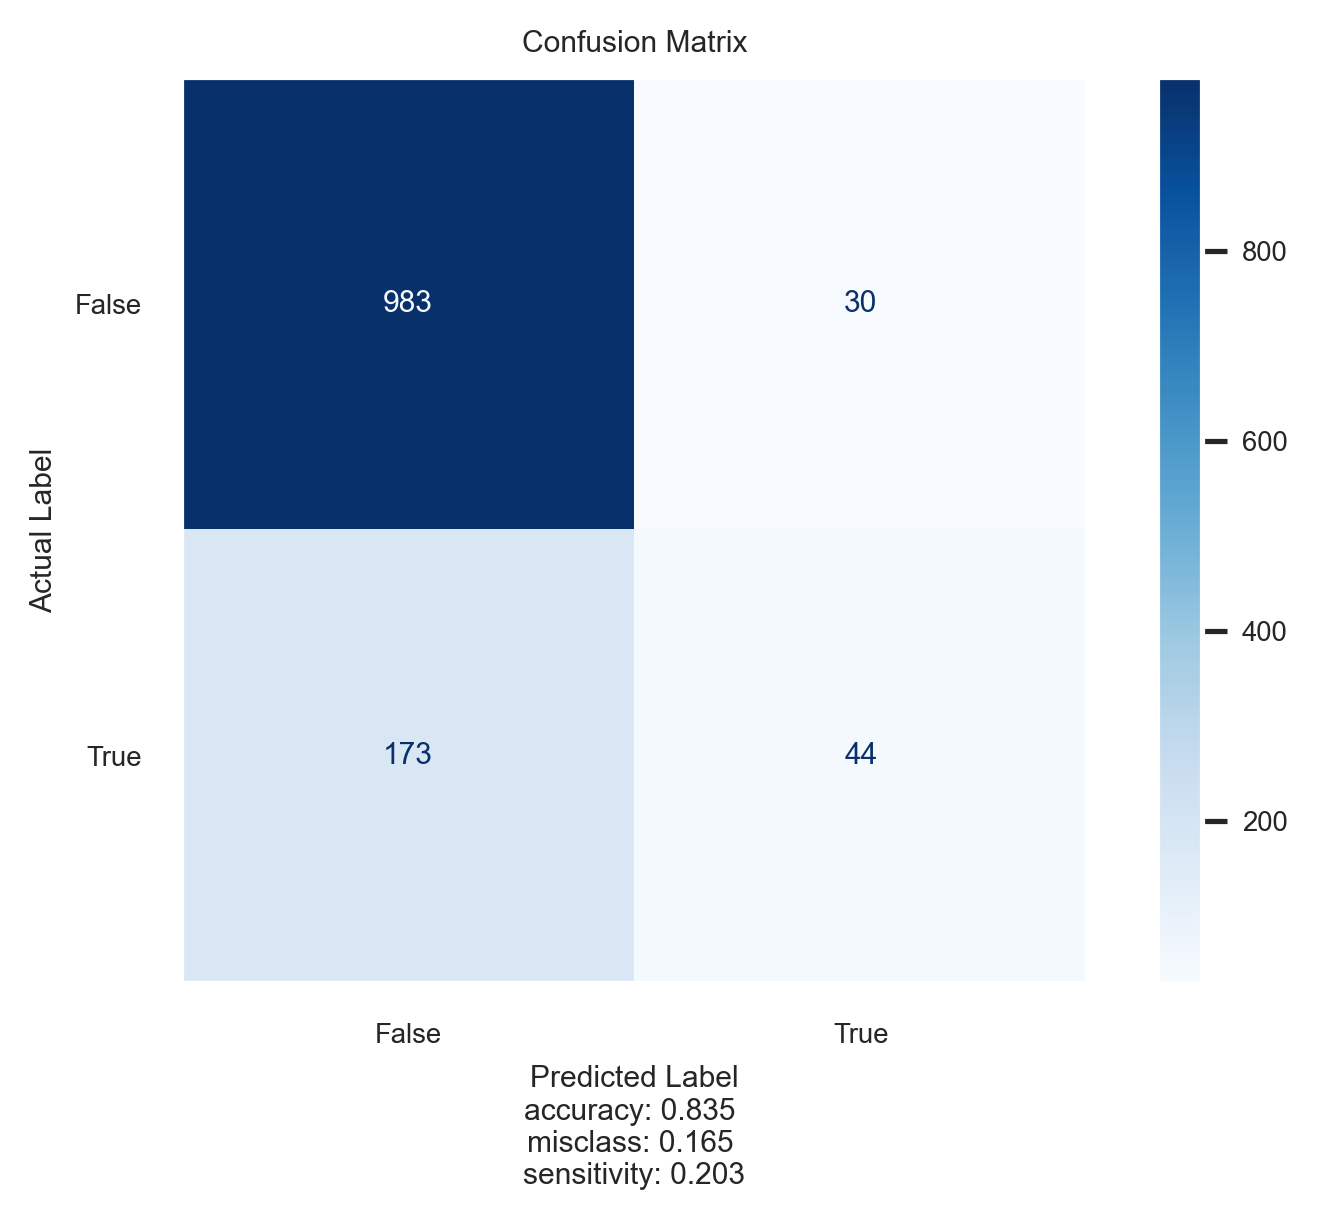

In [74]:
# confusion matrix on full dataset

accuracy = (TN+TP)/ALL
misclass = (FP+FN)/ALL
sensitivity = TP/(TP+FN)

plt.figure(figsize = (5, 3))
sns.set(font_scale = 0.6)

plot_confusion_matrix(
    logi_final, 
    df, 
    outcomes,
    cmap = "Blues")

plt.grid(None)

plt.title("Confusion Matrix")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label\naccuracy: {:0.3f} \nmisclass: {:0.3f} \nsensitivity: {:0.3f}'.format(accuracy, misclass, sensitivity))

plt.show()

In [75]:
# final accuracy report on ibm dataset

ALL = TP + FP + FN + TN

accuracy = (TP + TN)/ALL
true_positive_rate = sensitivity = recall = power = TP/(TP+FN)
precision = PPV = TP/(TP+FP)
f1_score = 2*(precision*recall)/(precision+recall)

false_positive_rate = false_alarm_ratio = fallout = FP/(FP+TN)
true_negative_rate = specificity = selectivity = TN/(TN+FP)
false_negative_rate = miss_rate = FN/(FN+TP)

support_pos = TP + FN
support_neg = FP + TN

indx_lst = [
        "Accuracy", 
        "True Positive Rate/Sensitivity/Recall/Power", 
        "False Positive Rate/False Alarm Ratio/Fall-out", 
        "True Negative Rate/Specificity/Selectivity", 
        "False Negative Rate/Miss Rate", 
        "Precision/PPV", 
        "F1 Score", 
        "Support (False)", 
        "Support (True)"
        ]

metric = [
        accuracy.round(4),
        true_positive_rate.round(4),
        false_positive_rate.round(4),
        true_negative_rate.round(4),
        false_negative_rate.round(4),
        precision.round(4),
        f1_score.round(4),
        support_neg.round(4),
        support_pos.round(4)
]

performance_report = pd.DataFrame(metric, indx_lst).rename(columns = {0: "Performance"})
performance_report

Performance
Accuracy                                              0.835
True Positive Rate/Sensitivity/Recall/Power           0.203
False Positive Rate/False Alarm Ratio/Fall-out        0.030
True Negative Rate/Specificity/Selectivity            0.970
False Negative Rate/Miss Rate                         0.797
Precision/PPV                                         0.595
F1 Score                                              0.302
Support (False)                                    1013.000
Support (True)                                      217.000